In [1]:
!pip install ripser transformers accelerate torch numpy pandas tqdm networkx hf_transfer

In [2]:
from huggingface_hub import login
login()

In [3]:
import torch
from transformers import AutoModelForCausalLM, AutoTokenizer
import numpy as np
import pandas as pd
import ripser
from ripser import ripser
from tqdm import tqdm
import math
import numpy as geek
import networkx as nx

def find_highest_finite_value_comprehension(data):
    """Finds the highest value in a list, ignoring inf values, using list comprehension."""
    finite_values = [x for x in data if not math.isinf(x)]
    return max(finite_values) if finite_values else -math.inf

def get_second_value_ignoring_inf(data):
    """
    Returns the second non-inf value in a list.

    Args:
      data: A list of numerical values.

    Returns:
      The second non-inf value in the list, or None if not found.
    """
    non_inf_values = [x for x in data if not math.isinf(x)]
    if len(non_inf_values) < 2:
        return None
    return non_inf_values[1]

def get_llama_attention(text, model, tokenizer):
    """Extract attention matrix from Llama model"""
    inputs = tokenizer(text, return_tensors='pt', truncation=True, padding=True, max_length=512)
    
    # Move inputs to the same device as model
    device = next(model.parameters()).device
    inputs = {k: v.to(device) for k, v in inputs.items()}
    
    with torch.no_grad():
        outputs = model(**inputs, output_attentions=True)
    
    # Get attention matrices and move to CPU
    attention_matrices = torch.stack(outputs.attentions).cpu()
    
    # Average across layers and heads
    attention_matrix = attention_matrices.mean(dim=0).mean(dim=1).squeeze().numpy()
    
    # Zero out the diagonal to focus on token-to-token relationships
    np.fill_diagonal(attention_matrix, 0)
    
    # Make symmetric for undirected graph
    attention_matrix = (attention_matrix + attention_matrix.T) / 2
    
    # Debug: print attention statistics
    print(f"Attention shape: {attention_matrix.shape}, min: {attention_matrix.min():.6f}, max: {attention_matrix.max():.6f}, mean: {attention_matrix.mean():.6f}")
    
    return attention_matrix

def build_graph(attention_matrix, threshold=None, percentile=50):
    """
    Build graph from attention matrix.
    If threshold is None, use percentile-based threshold instead.
    """
    graph = nx.Graph()
    num_nodes = attention_matrix.shape[0]
    
    # Add all nodes first
    graph.add_nodes_from(range(num_nodes))
    
    # Get upper triangle values (excluding diagonal)
    upper_triangle_indices = np.triu_indices(num_nodes, k=1)
    upper_triangle_values = attention_matrix[upper_triangle_indices]
    
    # Filter out zeros and NaNs for percentile calculation
    non_zero_values = upper_triangle_values[upper_triangle_values > 0]
    non_zero_values = non_zero_values[~np.isnan(non_zero_values)]
    
    # Use percentile-based threshold if not specified
    if threshold is None:
        if len(non_zero_values) > 0:
            try:
                threshold = np.percentile(non_zero_values, percentile)
                if np.isnan(threshold) or threshold == 0:
                    # Fallback to a small fraction of max value
                    threshold = np.max(non_zero_values) * 0.1
                    print(f"Using fallback threshold (10% of max): {threshold:.6f}")
                else:
                    print(f"Using percentile-based threshold: {threshold:.6f} ({percentile}th percentile)")
                print(f"Non-zero values: {len(non_zero_values)}/{len(upper_triangle_values)} ({100*len(non_zero_values)/len(upper_triangle_values):.1f}%)")
                print(f"Value range: [{np.min(non_zero_values):.6f}, {np.max(non_zero_values):.6f}]")
            except:
                threshold = 0.001
                print(f"Error calculating percentile, using default threshold: {threshold}")
        else:
            threshold = 0.0
            print(f"WARNING: No non-zero attention values found!")
    else:
        print(f"Using fixed threshold: {threshold}")
    
    edge_count = 0
    for i in range(num_nodes):
        for j in range(i + 1, num_nodes):
            if attention_matrix[i, j] > threshold:
                graph.add_edge(i, j, weight=attention_matrix[i, j])
                edge_count += 1
    
    print(f"Graph created: {num_nodes} nodes, {edge_count} edges")
    
    if edge_count == 0:
        print(f"WARNING: No edges created! Threshold was {threshold:.6f}, max value was {upper_triangle_values.max():.6f}")
    
    return graph

def process_texts(texts, model_name="meta-llama/Llama-3.1-8B"):
    """Process texts using Llama model for attention extraction"""
    tokenizer = AutoTokenizer.from_pretrained(model_name)
    model = AutoModelForCausalLM.from_pretrained(
        model_name,
        torch_dtype=torch.float16,
        device_map="auto",
        low_cpu_mem_usage=True,
        attn_implementation="eager"
    )
    
    if tokenizer.pad_token is None:
        tokenizer.pad_token = tokenizer.eos_token

    data = []
    for text in tqdm(texts):
        try:
            attention_matrix = get_llama_attention(text, model, tokenizer)
            graph = build_graph(attention_matrix, threshold=None, percentile=50)
            tda_features = compute_tda_features(graph)
            data.append(tda_features)
        except Exception as e:
            print(f"Error processing text: {e}")
            data.append([0] * 12)

    columns = ["Num_0dim", "Max_0dim", "Max_0dim_Minus_Second", "Mean_0dim", "betti_curve_0", "persistence_entropy_0",
               "Num_1dim", "Max_1dim", "Max_1dim_Minus_Second", "Mean_1dim", "betti_curve_1", "persistence_entropy_1"]
    return pd.DataFrame(data, columns=columns)

def compute_tda_features(graph):
    adjacency_matrix = nx.to_numpy_array(graph)
    
    # Check if graph is empty or has no edges
    if adjacency_matrix.shape[0] == 0 or np.sum(adjacency_matrix) == 0:
        print("Empty graph, returning zero features")
        return [0] * 12
    
    # Use distance matrix for ripser
    distance_matrix = 1 - adjacency_matrix  # Convert similarity to distance
    np.fill_diagonal(distance_matrix, 0)  # Ensure diagonal is 0
    
    diagrams = ripser(distance_matrix, maxdim=1, distance_matrix=True)['dgms']
    
    # Rest of the function remains the same...
    h0 = diagrams[0]
    h1 = diagrams[1] if len(diagrams) > 1 else np.array([])

    num_h0 = geek.count_nonzero(np.round(h0))
    highest_h0 = find_highest_finite_value_comprehension(h0[:, 1] - h0[:, 0]) if num_h0 > 0 else 0
    Second_highest_h0 = get_second_value_ignoring_inf(h0[:, 1] - h0[:, 0]) if num_h0 > 1 else 0
    highest_minus_second_h0 = highest_h0 - Second_highest_h0 if num_h0 > 1 else 0

    h0[np.isinf(h0)] = 0
    mean_h0 = np.mean(h0) if num_h0 > 0 else 0

    num_h1 = geek.count_nonzero(np.round(h1))
    highest_h1 = find_highest_finite_value_comprehension(h1[:, 1] - h1[:, 0]) if num_h1 > 0 else 0
    second_highest_h1 = get_second_value_ignoring_inf(h1[:, 1] - h1[:, 0]) if num_h1 > 1 else 0
    highest_minus_second_h1 = highest_h1 - second_highest_h1 if num_h1 > 1 else 0

    h1[np.isinf(h1)] = 0
    mean_h1 = np.mean(h1) if num_h1 > 0 else 0

    h0_persistences = np.sort(h0[:, 1] - h0[:, 0]) if num_h0 > 1 else np.array([0])
    h1_persistences = np.sort(h1[:, 1] - h1[:, 0]) if num_h1 > 1 else np.array([0])

    sum_persistence_0 = np.sum(h0_persistences) if len(h0_persistences) > 0 else 0
    sum_persistence_1 = np.sum(h1_persistences) if len(h1_persistences) > 0 else 0
    persistence_entropy_0 = -np.sum(h0_persistences * np.log(h0_persistences + 1e-10)) if len(h0_persistences) > 0 else 0
    persistence_entropy_1 = -np.sum(h1_persistences * np.log(h1_persistences + 1e-10)) if len(h1_persistences) > 0 else 0
    betti_curve_0 = len(h0_persistences)
    betti_curve_1 = len(h1_persistences)

    return [num_h0, highest_h0, highest_minus_second_h0, mean_h0, betti_curve_0, persistence_entropy_0,
            num_h1, highest_h1, highest_minus_second_h1, mean_h1, betti_curve_1, persistence_entropy_1]

In [4]:
texts = ["This is a test sentence.", "Another example of text processing."]
df = process_texts(texts)
print(df)

`torch_dtype` is deprecated! Use `dtype` instead!
/usr/local/lib/python3.12/dist-packages/accelerate/utils/modeling.py:1566: UserWarning: Current model requires 128 bytes of buffer for offloaded layers, which seems does not fit any GPU's remaining memory. If you are experiencing a OOM later, please consider using offload_buffers=True.
  warnings.warn(


Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

 50%|█████     | 1/2 [00:00<00:00,  1.52it/s]

Attention shape: (7, 7), min: 0.000000, max: 0.471680, mean: 0.115845
Using percentile-based threshold: 0.015762 (50th percentile)
Non-zero values: 21/21 (100.0%)
Value range: [0.006226, 0.471680]
Graph created: 7 nodes, 10 edges


100%|██████████| 2/2 [00:01<00:00,  1.61it/s]

Attention shape: (7, 7), min: 0.000000, max: 0.476318, mean: 0.115540
Using percentile-based threshold: 0.018997 (50th percentile)
Non-zero values: 21/21 (100.0%)
Value range: [0.008690, 0.476318]
Graph created: 7 nodes, 10 edges


   Num_0dim  Max_0dim  Max_0dim_Minus_Second  Mean_0dim  betti_curve_0  \
0         7  0.611816               0.067627   0.241752              7   
1         7  0.611816               0.065674   0.242536              7   

   persistence_entropy_0  Num_1dim  Max_1dim  Max_1dim_Minus_Second  \
0               1.933568         0         0                      0   
1               1.928764         0         0                      0   

   Mean_1dim  betti_curve_1  persistence_entropy_1  
0          0              1                   -0.0  
1          0              1                   -0.0  


In [5]:
!pip install pyarrow fastparquet datasets

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


In [7]:
import pyarrow
import pyarrow.parquet as pq
from datasets import load_dataset

# Load the dataset
ds = load_dataset("nyu-mll/blimp", "adjunct_island", split="train")

# Convert to pandas
blimp = ds.to_pandas()

# Get 500 good and 500 bad sentences
good_sentences = blimp['sentence_good'][0:500]
bad_sentences = blimp['sentence_bad'][0:500]

# Process with Llama TDA
print("Processing good sentences...")
good_tda = process_texts(good_sentences)

print("Processing bad sentences...")
bad_tda = process_texts(bad_sentences)

adjunct_island/train-00000-of-00001.parq(…):   0%|          | 0.00/62.2k [00:00<?, ?B/s]

Generating train split:   0%|          | 0/1000 [00:00<?, ? examples/s]

Processing good sentences...


/usr/local/lib/python3.12/dist-packages/accelerate/utils/modeling.py:1566: UserWarning: Current model requires 128 bytes of buffer for offloaded layers, which seems does not fit any GPU's remaining memory. If you are experiencing a OOM later, please consider using offload_buffers=True.
  warnings.warn(


Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 1/500 [00:00<07:00,  1.19it/s]

Attention shape: (9, 9), min: 0.000000, max: 0.477539, mean: 0.092957
Using percentile-based threshold: 0.015011 (50th percentile)
Non-zero values: 36/36 (100.0%)
Value range: [0.002487, 0.477539]
Graph created: 9 nodes, 18 edges


  0%|          | 2/500 [00:01<07:42,  1.08it/s]

Attention shape: (13, 13), min: 0.000000, max: 0.475098, mean: 0.067322
Using percentile-based threshold: 0.012142 (50th percentile)
Non-zero values: 78/78 (100.0%)
Value range: [0.002327, 0.475098]
Graph created: 13 nodes, 39 edges


  1%|          | 3/500 [00:02<07:29,  1.11it/s]

Attention shape: (9, 9), min: 0.000000, max: 0.477539, mean: 0.093262
Using percentile-based threshold: 0.014652 (50th percentile)
Non-zero values: 36/36 (100.0%)
Value range: [0.002901, 0.477539]
Graph created: 9 nodes, 18 edges


  1%|          | 4/500 [00:03<08:44,  1.06s/it]

Attention shape: (10, 10), min: 0.000000, max: 0.477539, mean: 0.085022
Using percentile-based threshold: 0.013733 (50th percentile)
Non-zero values: 45/45 (100.0%)
Value range: [0.002865, 0.477539]
Graph created: 10 nodes, 22 edges


  1%|          | 5/500 [00:05<09:45,  1.18s/it]

Attention shape: (14, 14), min: 0.000000, max: 0.475098, mean: 0.062927
Using percentile-based threshold: 0.011520 (50th percentile)
Non-zero values: 91/91 (100.0%)
Value range: [0.001880, 0.475098]
Graph created: 14 nodes, 45 edges


  1%|          | 6/500 [00:06<08:39,  1.05s/it]

Attention shape: (10, 10), min: 0.000000, max: 0.477539, mean: 0.085083
Using percentile-based threshold: 0.013245 (50th percentile)
Non-zero values: 45/45 (100.0%)
Value range: [0.002199, 0.477539]
Graph created: 10 nodes, 22 edges


  1%|▏         | 7/500 [00:06<07:57,  1.03it/s]

Attention shape: (10, 10), min: 0.000000, max: 0.477539, mean: 0.085022
Using percentile-based threshold: 0.014313 (50th percentile)
Non-zero values: 45/45 (100.0%)
Value range: [0.003704, 0.477539]
Graph created: 10 nodes, 22 edges


  2%|▏         | 8/500 [00:07<07:47,  1.05it/s]

Attention shape: (12, 12), min: 0.000000, max: 0.475098, mean: 0.072327
Using percentile-based threshold: 0.015659 (50th percentile)
Non-zero values: 66/66 (100.0%)
Value range: [0.004089, 0.475098]
Graph created: 12 nodes, 33 edges


  2%|▏         | 9/500 [00:08<07:10,  1.14it/s]

Attention shape: (9, 9), min: 0.000000, max: 0.477539, mean: 0.092957
Using percentile-based threshold: 0.015862 (50th percentile)
Non-zero values: 36/36 (100.0%)
Value range: [0.003017, 0.477539]
Graph created: 9 nodes, 18 edges


  2%|▏         | 10/500 [00:09<07:08,  1.14it/s]

Attention shape: (11, 11), min: 0.000000, max: 0.475098, mean: 0.078308
Using percentile-based threshold: 0.012741 (50th percentile)
Non-zero values: 55/55 (100.0%)
Value range: [0.002623, 0.475098]
Graph created: 11 nodes, 27 edges


  2%|▏         | 11/500 [00:10<07:01,  1.16it/s]

Attention shape: (11, 11), min: 0.000000, max: 0.477539, mean: 0.078186
Using percentile-based threshold: 0.013519 (50th percentile)
Non-zero values: 55/55 (100.0%)
Value range: [0.002195, 0.477539]
Graph created: 11 nodes, 27 edges


  2%|▏         | 12/500 [00:11<07:01,  1.16it/s]

Attention shape: (11, 11), min: 0.000000, max: 0.475098, mean: 0.077759
Using percentile-based threshold: 0.013168 (50th percentile)
Non-zero values: 55/55 (100.0%)
Value range: [0.002590, 0.475098]
Graph created: 11 nodes, 27 edges


  3%|▎         | 13/500 [00:12<06:56,  1.17it/s]

Attention shape: (11, 11), min: 0.000000, max: 0.475098, mean: 0.077942
Using percentile-based threshold: 0.013901 (50th percentile)
Non-zero values: 55/55 (100.0%)
Value range: [0.003807, 0.475098]
Graph created: 11 nodes, 27 edges


  3%|▎         | 14/500 [00:12<06:41,  1.21it/s]

Attention shape: (9, 9), min: 0.000000, max: 0.477539, mean: 0.093079
Using percentile-based threshold: 0.015312 (50th percentile)
Non-zero values: 36/36 (100.0%)
Value range: [0.003956, 0.477539]
Graph created: 9 nodes, 18 edges


  3%|▎         | 15/500 [00:13<06:52,  1.17it/s]

Attention shape: (12, 12), min: 0.000000, max: 0.477539, mean: 0.072266
Using percentile-based threshold: 0.013363 (50th percentile)
Non-zero values: 66/66 (100.0%)
Value range: [0.004402, 0.477539]
Graph created: 12 nodes, 33 edges


  3%|▎         | 16/500 [00:14<06:49,  1.18it/s]

Attention shape: (11, 11), min: 0.000000, max: 0.475098, mean: 0.078064
Using percentile-based threshold: 0.012817 (50th percentile)
Non-zero values: 55/55 (100.0%)
Value range: [0.002684, 0.475098]
Graph created: 11 nodes, 27 edges


  3%|▎         | 17/500 [00:15<06:41,  1.20it/s]

Attention shape: (10, 10), min: 0.000000, max: 0.477539, mean: 0.085144
Using percentile-based threshold: 0.012001 (50th percentile)
Non-zero values: 45/45 (100.0%)
Value range: [0.003433, 0.477539]
Graph created: 10 nodes, 22 edges


  4%|▎         | 18/500 [00:16<06:47,  1.18it/s]

Attention shape: (10, 10), min: 0.000000, max: 0.477539, mean: 0.084900
Using percentile-based threshold: 0.014793 (50th percentile)
Non-zero values: 45/45 (100.0%)
Value range: [0.003057, 0.477539]
Graph created: 10 nodes, 22 edges


  4%|▍         | 19/500 [00:17<06:50,  1.17it/s]

Attention shape: (11, 11), min: 0.000000, max: 0.475098, mean: 0.078003
Using percentile-based threshold: 0.013519 (50th percentile)
Non-zero values: 55/55 (100.0%)
Value range: [0.002689, 0.475098]
Graph created: 11 nodes, 27 edges


  4%|▍         | 20/500 [00:17<06:46,  1.18it/s]

Attention shape: (11, 11), min: 0.000000, max: 0.475098, mean: 0.077942
Using percentile-based threshold: 0.013069 (50th percentile)
Non-zero values: 55/55 (100.0%)
Value range: [0.004246, 0.475098]
Graph created: 11 nodes, 27 edges


  4%|▍         | 21/500 [00:18<07:09,  1.12it/s]

Attention shape: (11, 11), min: 0.000000, max: 0.477539, mean: 0.078064
Using percentile-based threshold: 0.010590 (50th percentile)
Non-zero values: 55/55 (100.0%)
Value range: [0.002758, 0.477539]
Graph created: 11 nodes, 27 edges


  4%|▍         | 22/500 [00:19<06:41,  1.19it/s]

Attention shape: (9, 9), min: 0.000000, max: 0.477539, mean: 0.093262
Using percentile-based threshold: 0.016041 (50th percentile)
Non-zero values: 36/36 (100.0%)
Value range: [0.002951, 0.477539]
Graph created: 9 nodes, 18 edges


  5%|▍         | 23/500 [00:20<07:02,  1.13it/s]

Attention shape: (13, 13), min: 0.000000, max: 0.477539, mean: 0.067261
Using percentile-based threshold: 0.009464 (50th percentile)
Non-zero values: 78/78 (100.0%)
Value range: [0.002026, 0.477539]
Graph created: 13 nodes, 39 edges


  5%|▍         | 24/500 [00:21<06:48,  1.17it/s]

Attention shape: (10, 10), min: 0.000000, max: 0.477539, mean: 0.085083
Using percentile-based threshold: 0.014473 (50th percentile)
Non-zero values: 45/45 (100.0%)
Value range: [0.003878, 0.477539]
Graph created: 10 nodes, 22 edges


  5%|▌         | 25/500 [00:22<07:06,  1.11it/s]

Attention shape: (13, 13), min: 0.000000, max: 0.475098, mean: 0.067322
Using percentile-based threshold: 0.010998 (50th percentile)
Non-zero values: 78/78 (100.0%)
Value range: [0.003094, 0.475098]
Graph created: 13 nodes, 39 edges


  5%|▌         | 26/500 [00:23<07:07,  1.11it/s]

Attention shape: (12, 12), min: 0.000000, max: 0.475098, mean: 0.072449
Using percentile-based threshold: 0.013138 (50th percentile)
Non-zero values: 66/66 (100.0%)
Value range: [0.001989, 0.475098]
Graph created: 12 nodes, 33 edges


  5%|▌         | 27/500 [00:24<07:01,  1.12it/s]

Attention shape: (11, 11), min: 0.000000, max: 0.477539, mean: 0.078308
Using percentile-based threshold: 0.012070 (50th percentile)
Non-zero values: 55/55 (100.0%)
Value range: [0.002232, 0.477539]
Graph created: 11 nodes, 27 edges


  6%|▌         | 28/500 [00:25<07:03,  1.11it/s]

Attention shape: (12, 12), min: 0.000000, max: 0.477539, mean: 0.072449
Using percentile-based threshold: 0.010685 (50th percentile)
Non-zero values: 66/66 (100.0%)
Value range: [0.002729, 0.477539]
Graph created: 12 nodes, 33 edges


  6%|▌         | 29/500 [00:25<06:48,  1.15it/s]

Attention shape: (10, 10), min: 0.000000, max: 0.475098, mean: 0.085083
Using percentile-based threshold: 0.015450 (50th percentile)
Non-zero values: 45/45 (100.0%)
Value range: [0.003353, 0.475098]
Graph created: 10 nodes, 22 edges


  6%|▌         | 30/500 [00:26<06:42,  1.17it/s]

Attention shape: (11, 11), min: 0.000000, max: 0.475098, mean: 0.077942
Using percentile-based threshold: 0.013992 (50th percentile)
Non-zero values: 55/55 (100.0%)
Value range: [0.004391, 0.475098]
Graph created: 11 nodes, 27 edges


  6%|▌         | 31/500 [00:27<06:32,  1.20it/s]

Attention shape: (10, 10), min: 0.000000, max: 0.475098, mean: 0.084839
Using percentile-based threshold: 0.017578 (50th percentile)
Non-zero values: 45/45 (100.0%)
Value range: [0.004383, 0.475098]
Graph created: 10 nodes, 22 edges


  6%|▋         | 32/500 [00:28<06:36,  1.18it/s]

Attention shape: (11, 11), min: 0.000000, max: 0.477539, mean: 0.078247
Using percentile-based threshold: 0.011612 (50th percentile)
Non-zero values: 55/55 (100.0%)
Value range: [0.003174, 0.477539]
Graph created: 11 nodes, 27 edges


  7%|▋         | 33/500 [00:29<06:23,  1.22it/s]

Attention shape: (10, 10), min: 0.000000, max: 0.477539, mean: 0.085083
Using percentile-based threshold: 0.013191 (50th percentile)
Non-zero values: 45/45 (100.0%)
Value range: [0.003399, 0.477539]
Graph created: 10 nodes, 22 edges


  7%|▋         | 34/500 [00:30<06:39,  1.17it/s]

Attention shape: (12, 12), min: 0.000000, max: 0.475098, mean: 0.072266
Using percentile-based threshold: 0.011478 (50th percentile)
Non-zero values: 66/66 (100.0%)
Value range: [0.001791, 0.475098]
Graph created: 12 nodes, 33 edges


  7%|▋         | 35/500 [00:30<06:29,  1.19it/s]

Attention shape: (10, 10), min: 0.000000, max: 0.477539, mean: 0.085266
Using percentile-based threshold: 0.015686 (50th percentile)
Non-zero values: 45/45 (100.0%)
Value range: [0.001700, 0.477539]
Graph created: 10 nodes, 22 edges


  7%|▋         | 36/500 [00:31<06:16,  1.23it/s]

Attention shape: (10, 10), min: 0.000000, max: 0.475098, mean: 0.085144
Using percentile-based threshold: 0.013260 (50th percentile)
Non-zero values: 45/45 (100.0%)
Value range: [0.002781, 0.475098]
Graph created: 10 nodes, 22 edges


  7%|▋         | 37/500 [00:32<06:35,  1.17it/s]

Attention shape: (12, 12), min: 0.000000, max: 0.477539, mean: 0.072327
Using percentile-based threshold: 0.013172 (50th percentile)
Non-zero values: 66/66 (100.0%)
Value range: [0.003252, 0.477539]
Graph created: 12 nodes, 33 edges


  8%|▊         | 38/500 [00:33<06:28,  1.19it/s]

Attention shape: (10, 10), min: 0.000000, max: 0.477539, mean: 0.084961
Using percentile-based threshold: 0.014450 (50th percentile)
Non-zero values: 45/45 (100.0%)
Value range: [0.002464, 0.477539]
Graph created: 10 nodes, 22 edges


  8%|▊         | 39/500 [00:34<06:42,  1.15it/s]

Attention shape: (12, 12), min: 0.000000, max: 0.475098, mean: 0.072021
Using percentile-based threshold: 0.011051 (50th percentile)
Non-zero values: 66/66 (100.0%)
Value range: [0.002701, 0.475098]
Graph created: 12 nodes, 33 edges


  8%|▊         | 40/500 [00:35<06:40,  1.15it/s]

Attention shape: (11, 11), min: 0.000000, max: 0.475098, mean: 0.077698
Using percentile-based threshold: 0.012924 (50th percentile)
Non-zero values: 55/55 (100.0%)
Value range: [0.003735, 0.475098]
Graph created: 11 nodes, 27 edges


  8%|▊         | 41/500 [00:36<06:34,  1.16it/s]

Attention shape: (11, 11), min: 0.000000, max: 0.477539, mean: 0.078186
Using percentile-based threshold: 0.012779 (50th percentile)
Non-zero values: 55/55 (100.0%)
Value range: [0.002560, 0.477539]
Graph created: 11 nodes, 27 edges


  8%|▊         | 42/500 [00:37<06:48,  1.12it/s]

Attention shape: (12, 12), min: 0.000000, max: 0.475098, mean: 0.072266
Using percentile-based threshold: 0.013569 (50th percentile)
Non-zero values: 66/66 (100.0%)
Value range: [0.004852, 0.475098]
Graph created: 12 nodes, 33 edges


  9%|▊         | 43/500 [00:37<06:33,  1.16it/s]

Attention shape: (10, 10), min: 0.000000, max: 0.477539, mean: 0.084778
Using percentile-based threshold: 0.014465 (50th percentile)
Non-zero values: 45/45 (100.0%)
Value range: [0.003294, 0.477539]
Graph created: 10 nodes, 22 edges


  9%|▉         | 44/500 [00:38<06:28,  1.17it/s]

Attention shape: (11, 11), min: 0.000000, max: 0.477539, mean: 0.078064
Using percentile-based threshold: 0.013901 (50th percentile)
Non-zero values: 55/55 (100.0%)
Value range: [0.003836, 0.477539]
Graph created: 11 nodes, 27 edges


  9%|▉         | 45/500 [00:39<06:31,  1.16it/s]

Attention shape: (11, 11), min: 0.000000, max: 0.475098, mean: 0.078247
Using percentile-based threshold: 0.014114 (50th percentile)
Non-zero values: 55/55 (100.0%)
Value range: [0.002712, 0.475098]
Graph created: 11 nodes, 27 edges


  9%|▉         | 46/500 [00:40<06:20,  1.19it/s]

Attention shape: (10, 10), min: 0.000000, max: 0.477539, mean: 0.085022
Using percentile-based threshold: 0.014252 (50th percentile)
Non-zero values: 45/45 (100.0%)
Value range: [0.002565, 0.477539]
Graph created: 10 nodes, 22 edges


  9%|▉         | 47/500 [00:41<06:41,  1.13it/s]

Attention shape: (12, 12), min: 0.000000, max: 0.475098, mean: 0.072205
Using percentile-based threshold: 0.013294 (50th percentile)
Non-zero values: 66/66 (100.0%)
Value range: [0.002184, 0.475098]
Graph created: 12 nodes, 33 edges


 10%|▉         | 48/500 [00:42<06:34,  1.15it/s]

Attention shape: (11, 11), min: 0.000000, max: 0.477539, mean: 0.078308
Using percentile-based threshold: 0.011414 (50th percentile)
Non-zero values: 55/55 (100.0%)
Value range: [0.003042, 0.477539]
Graph created: 11 nodes, 27 edges


 10%|▉         | 49/500 [00:43<06:33,  1.15it/s]

Attention shape: (11, 11), min: 0.000000, max: 0.475098, mean: 0.078125
Using percentile-based threshold: 0.012573 (50th percentile)
Non-zero values: 55/55 (100.0%)
Value range: [0.003706, 0.475098]
Graph created: 11 nodes, 27 edges


 10%|█         | 50/500 [00:43<06:10,  1.21it/s]

Attention shape: (9, 9), min: 0.000000, max: 0.475098, mean: 0.092957
Using percentile-based threshold: 0.014202 (50th percentile)
Non-zero values: 36/36 (100.0%)
Value range: [0.004261, 0.475098]
Graph created: 9 nodes, 18 edges


 10%|█         | 51/500 [00:44<06:05,  1.23it/s]

Attention shape: (10, 10), min: 0.000000, max: 0.475098, mean: 0.084900
Using percentile-based threshold: 0.013252 (50th percentile)
Non-zero values: 45/45 (100.0%)
Value range: [0.002480, 0.475098]
Graph created: 10 nodes, 22 edges


 10%|█         | 52/500 [00:45<06:07,  1.22it/s]

Attention shape: (11, 11), min: 0.000000, max: 0.477539, mean: 0.077942
Using percentile-based threshold: 0.010582 (50th percentile)
Non-zero values: 55/55 (100.0%)
Value range: [0.002462, 0.477539]
Graph created: 11 nodes, 27 edges


 11%|█         | 53/500 [00:46<06:01,  1.24it/s]

Attention shape: (10, 10), min: 0.000000, max: 0.477539, mean: 0.084961
Using percentile-based threshold: 0.016235 (50th percentile)
Non-zero values: 45/45 (100.0%)
Value range: [0.004028, 0.477539]
Graph created: 10 nodes, 22 edges


 11%|█         | 54/500 [00:47<06:11,  1.20it/s]

Attention shape: (11, 11), min: 0.000000, max: 0.477539, mean: 0.078125
Using percentile-based threshold: 0.013161 (50th percentile)
Non-zero values: 55/55 (100.0%)
Value range: [0.002977, 0.477539]
Graph created: 11 nodes, 27 edges


 11%|█         | 55/500 [00:47<06:19,  1.17it/s]

Attention shape: (11, 11), min: 0.000000, max: 0.475098, mean: 0.077820
Using percentile-based threshold: 0.015038 (50th percentile)
Non-zero values: 55/55 (100.0%)
Value range: [0.003716, 0.475098]
Graph created: 11 nodes, 27 edges


 11%|█         | 56/500 [00:48<06:11,  1.20it/s]

Attention shape: (10, 10), min: 0.000000, max: 0.477539, mean: 0.084839
Using percentile-based threshold: 0.013985 (50th percentile)
Non-zero values: 45/45 (100.0%)
Value range: [0.003654, 0.477539]
Graph created: 10 nodes, 22 edges


 11%|█▏        | 57/500 [00:49<05:54,  1.25it/s]

Attention shape: (9, 9), min: 0.000000, max: 0.477539, mean: 0.093079
Using percentile-based threshold: 0.014763 (50th percentile)
Non-zero values: 36/36 (100.0%)
Value range: [0.002439, 0.477539]
Graph created: 9 nodes, 18 edges


 12%|█▏        | 58/500 [00:50<05:57,  1.24it/s]

Attention shape: (10, 10), min: 0.000000, max: 0.477539, mean: 0.084900
Using percentile-based threshold: 0.014030 (50th percentile)
Non-zero values: 45/45 (100.0%)
Value range: [0.002359, 0.477539]
Graph created: 10 nodes, 22 edges


 12%|█▏        | 59/500 [00:51<06:15,  1.17it/s]

Attention shape: (12, 12), min: 0.000000, max: 0.475098, mean: 0.072083
Using percentile-based threshold: 0.011208 (50th percentile)
Non-zero values: 66/66 (100.0%)
Value range: [0.002987, 0.475098]
Graph created: 12 nodes, 33 edges


 12%|█▏        | 60/500 [00:52<06:12,  1.18it/s]

Attention shape: (11, 11), min: 0.000000, max: 0.475098, mean: 0.078125
Using percentile-based threshold: 0.013451 (50th percentile)
Non-zero values: 55/55 (100.0%)
Value range: [0.003963, 0.475098]
Graph created: 11 nodes, 27 edges


 12%|█▏        | 61/500 [00:52<06:03,  1.21it/s]

Attention shape: (10, 10), min: 0.000000, max: 0.477539, mean: 0.084961
Using percentile-based threshold: 0.014099 (50th percentile)
Non-zero values: 45/45 (100.0%)
Value range: [0.003702, 0.477539]
Graph created: 10 nodes, 22 edges


 12%|█▏        | 62/500 [00:53<06:40,  1.09it/s]

Attention shape: (15, 15), min: 0.000000, max: 0.475098, mean: 0.059143
Using percentile-based threshold: 0.011787 (50th percentile)
Non-zero values: 105/105 (100.0%)
Value range: [0.002817, 0.475098]
Graph created: 15 nodes, 52 edges


 13%|█▎        | 63/500 [00:54<06:49,  1.07it/s]

Attention shape: (13, 13), min: 0.000000, max: 0.477539, mean: 0.067078
Using percentile-based threshold: 0.013905 (50th percentile)
Non-zero values: 78/78 (100.0%)
Value range: [0.003845, 0.477539]
Graph created: 13 nodes, 39 edges


 13%|█▎        | 64/500 [00:55<06:39,  1.09it/s]

Attention shape: (11, 11), min: 0.000000, max: 0.475098, mean: 0.077942
Using percentile-based threshold: 0.014435 (50th percentile)
Non-zero values: 55/55 (100.0%)
Value range: [0.002098, 0.475098]
Graph created: 11 nodes, 27 edges


 13%|█▎        | 65/500 [00:56<06:48,  1.06it/s]

Attention shape: (13, 13), min: 0.000000, max: 0.475098, mean: 0.067322
Using percentile-based threshold: 0.012226 (50th percentile)
Non-zero values: 78/78 (100.0%)
Value range: [0.002392, 0.475098]
Graph created: 13 nodes, 39 edges


 13%|█▎        | 66/500 [00:57<06:44,  1.07it/s]

Attention shape: (12, 12), min: 0.000000, max: 0.477539, mean: 0.072205
Using percentile-based threshold: 0.010895 (50th percentile)
Non-zero values: 66/66 (100.0%)
Value range: [0.002058, 0.477539]
Graph created: 12 nodes, 33 edges


 13%|█▎        | 67/500 [00:58<06:30,  1.11it/s]

Attention shape: (11, 11), min: 0.000000, max: 0.475098, mean: 0.077942
Using percentile-based threshold: 0.012672 (50th percentile)
Non-zero values: 55/55 (100.0%)
Value range: [0.003380, 0.475098]
Graph created: 11 nodes, 27 edges


 14%|█▎        | 68/500 [00:59<06:09,  1.17it/s]

Attention shape: (9, 9), min: 0.000000, max: 0.477539, mean: 0.093201
Using percentile-based threshold: 0.013634 (50th percentile)
Non-zero values: 36/36 (100.0%)
Value range: [0.001815, 0.477539]
Graph created: 9 nodes, 18 edges


 14%|█▍        | 69/500 [01:00<06:58,  1.03it/s]

Attention shape: (11, 11), min: 0.000000, max: 0.477539, mean: 0.078186
Using percentile-based threshold: 0.014755 (50th percentile)
Non-zero values: 55/55 (100.0%)
Value range: [0.003393, 0.477539]
Graph created: 11 nodes, 27 edges


 14%|█▍        | 70/500 [01:01<07:25,  1.04s/it]

Attention shape: (12, 12), min: 0.000000, max: 0.477539, mean: 0.072449
Using percentile-based threshold: 0.010914 (50th percentile)
Non-zero values: 66/66 (100.0%)
Value range: [0.003054, 0.477539]
Graph created: 12 nodes, 33 edges


 14%|█▍        | 71/500 [01:02<06:53,  1.04it/s]

Attention shape: (10, 10), min: 0.000000, max: 0.477539, mean: 0.084717
Using percentile-based threshold: 0.014328 (50th percentile)
Non-zero values: 45/45 (100.0%)
Value range: [0.002785, 0.477539]
Graph created: 10 nodes, 22 edges


 14%|█▍        | 72/500 [01:03<06:30,  1.10it/s]

Attention shape: (10, 10), min: 0.000000, max: 0.475098, mean: 0.085022
Using percentile-based threshold: 0.014786 (50th percentile)
Non-zero values: 45/45 (100.0%)
Value range: [0.002871, 0.475098]
Graph created: 10 nodes, 22 edges


 15%|█▍        | 73/500 [01:04<06:29,  1.10it/s]

Attention shape: (12, 12), min: 0.000000, max: 0.475098, mean: 0.072144
Using percentile-based threshold: 0.011528 (50th percentile)
Non-zero values: 66/66 (100.0%)
Value range: [0.001865, 0.475098]
Graph created: 12 nodes, 33 edges


 15%|█▍        | 74/500 [01:05<06:23,  1.11it/s]

Attention shape: (11, 11), min: 0.000000, max: 0.475098, mean: 0.078064
Using percentile-based threshold: 0.012146 (50th percentile)
Non-zero values: 55/55 (100.0%)
Value range: [0.003216, 0.475098]
Graph created: 11 nodes, 27 edges


 15%|█▌        | 75/500 [01:05<06:14,  1.14it/s]

Attention shape: (11, 11), min: 0.000000, max: 0.475098, mean: 0.077942
Using percentile-based threshold: 0.013969 (50th percentile)
Non-zero values: 55/55 (100.0%)
Value range: [0.003706, 0.475098]
Graph created: 11 nodes, 27 edges


 15%|█▌        | 76/500 [01:06<06:17,  1.12it/s]

Attention shape: (12, 12), min: 0.000000, max: 0.475098, mean: 0.072021
Using percentile-based threshold: 0.014076 (50th percentile)
Non-zero values: 66/66 (100.0%)
Value range: [0.002138, 0.475098]
Graph created: 12 nodes, 33 edges


 15%|█▌        | 77/500 [01:07<06:44,  1.05it/s]

Attention shape: (13, 13), min: 0.000000, max: 0.475098, mean: 0.067139
Using percentile-based threshold: 0.012535 (50th percentile)
Non-zero values: 78/78 (100.0%)
Value range: [0.001722, 0.475098]
Graph created: 13 nodes, 39 edges


 16%|█▌        | 78/500 [01:08<06:22,  1.10it/s]

Attention shape: (10, 10), min: 0.000000, max: 0.475098, mean: 0.084778
Using percentile-based threshold: 0.015396 (50th percentile)
Non-zero values: 45/45 (100.0%)
Value range: [0.005196, 0.475098]
Graph created: 10 nodes, 22 edges


 16%|█▌        | 79/500 [01:09<06:08,  1.14it/s]

Attention shape: (10, 10), min: 0.000000, max: 0.477539, mean: 0.085083
Using percentile-based threshold: 0.016144 (50th percentile)
Non-zero values: 45/45 (100.0%)
Value range: [0.002886, 0.477539]
Graph created: 10 nodes, 22 edges


 16%|█▌        | 80/500 [01:10<06:06,  1.15it/s]

Attention shape: (11, 11), min: 0.000000, max: 0.477539, mean: 0.078064
Using percentile-based threshold: 0.013695 (50th percentile)
Non-zero values: 55/55 (100.0%)
Value range: [0.003494, 0.477539]
Graph created: 11 nodes, 27 edges


 16%|█▌        | 81/500 [01:11<06:00,  1.16it/s]

Attention shape: (11, 11), min: 0.000000, max: 0.475098, mean: 0.077942
Using percentile-based threshold: 0.013306 (50th percentile)
Non-zero values: 55/55 (100.0%)
Value range: [0.002932, 0.475098]
Graph created: 11 nodes, 27 edges


 16%|█▋        | 82/500 [01:12<06:01,  1.16it/s]

Attention shape: (11, 11), min: 0.000000, max: 0.475098, mean: 0.078003
Using percentile-based threshold: 0.012749 (50th percentile)
Non-zero values: 55/55 (100.0%)
Value range: [0.002851, 0.475098]
Graph created: 11 nodes, 27 edges


 17%|█▋        | 83/500 [01:13<06:16,  1.11it/s]

Attention shape: (13, 13), min: 0.000000, max: 0.475098, mean: 0.067322
Using percentile-based threshold: 0.011868 (50th percentile)
Non-zero values: 78/78 (100.0%)
Value range: [0.002741, 0.475098]
Graph created: 13 nodes, 39 edges


 17%|█▋        | 84/500 [01:13<06:07,  1.13it/s]

Attention shape: (11, 11), min: 0.000000, max: 0.477539, mean: 0.078491
Using percentile-based threshold: 0.012581 (50th percentile)
Non-zero values: 55/55 (100.0%)
Value range: [0.002975, 0.477539]
Graph created: 11 nodes, 27 edges


 17%|█▋        | 85/500 [01:14<05:49,  1.19it/s]

Attention shape: (9, 9), min: 0.000000, max: 0.477539, mean: 0.092896
Using percentile-based threshold: 0.016113 (50th percentile)
Non-zero values: 36/36 (100.0%)
Value range: [0.003506, 0.477539]
Graph created: 9 nodes, 18 edges


 17%|█▋        | 86/500 [01:15<05:37,  1.23it/s]

Attention shape: (10, 10), min: 0.000000, max: 0.477539, mean: 0.084900
Using percentile-based threshold: 0.014343 (50th percentile)
Non-zero values: 45/45 (100.0%)
Value range: [0.003128, 0.477539]
Graph created: 10 nodes, 22 edges


 17%|█▋        | 87/500 [01:16<05:43,  1.20it/s]

Attention shape: (11, 11), min: 0.000000, max: 0.477539, mean: 0.077820
Using percentile-based threshold: 0.013351 (50th percentile)
Non-zero values: 55/55 (100.0%)
Value range: [0.002632, 0.477539]
Graph created: 11 nodes, 27 edges


 18%|█▊        | 88/500 [01:17<05:27,  1.26it/s]

Attention shape: (9, 9), min: 0.000000, max: 0.477539, mean: 0.093262
Using percentile-based threshold: 0.014816 (50th percentile)
Non-zero values: 36/36 (100.0%)
Value range: [0.002253, 0.477539]
Graph created: 9 nodes, 18 edges


 18%|█▊        | 89/500 [01:17<05:41,  1.20it/s]

Attention shape: (12, 12), min: 0.000000, max: 0.475098, mean: 0.072083
Using percentile-based threshold: 0.011295 (50th percentile)
Non-zero values: 66/66 (100.0%)
Value range: [0.003910, 0.475098]
Graph created: 12 nodes, 33 edges


 18%|█▊        | 90/500 [01:18<05:36,  1.22it/s]

Attention shape: (10, 10), min: 0.000000, max: 0.475098, mean: 0.084778
Using percentile-based threshold: 0.018967 (50th percentile)
Non-zero values: 45/45 (100.0%)
Value range: [0.001895, 0.475098]
Graph created: 10 nodes, 22 edges


 18%|█▊        | 91/500 [01:19<05:41,  1.20it/s]

Attention shape: (11, 11), min: 0.000000, max: 0.475098, mean: 0.078003
Using percentile-based threshold: 0.015007 (50th percentile)
Non-zero values: 55/55 (100.0%)
Value range: [0.001875, 0.475098]
Graph created: 11 nodes, 27 edges


 18%|█▊        | 92/500 [01:20<05:35,  1.22it/s]

Attention shape: (10, 10), min: 0.000000, max: 0.475098, mean: 0.084839
Using percentile-based threshold: 0.013329 (50th percentile)
Non-zero values: 45/45 (100.0%)
Value range: [0.003641, 0.475098]
Graph created: 10 nodes, 22 edges


 19%|█▊        | 93/500 [01:21<05:26,  1.25it/s]

Attention shape: (10, 10), min: 0.000000, max: 0.475098, mean: 0.084717
Using percentile-based threshold: 0.012543 (50th percentile)
Non-zero values: 45/45 (100.0%)
Value range: [0.005676, 0.475098]
Graph created: 10 nodes, 22 edges


 19%|█▉        | 94/500 [01:22<05:37,  1.20it/s]

Attention shape: (12, 12), min: 0.000000, max: 0.475098, mean: 0.072327
Using percentile-based threshold: 0.013718 (50th percentile)
Non-zero values: 66/66 (100.0%)
Value range: [0.002567, 0.475098]
Graph created: 12 nodes, 33 edges


 19%|█▉        | 95/500 [01:23<06:15,  1.08it/s]

Attention shape: (10, 10), min: 0.000000, max: 0.477539, mean: 0.085022
Using percentile-based threshold: 0.012253 (50th percentile)
Non-zero values: 45/45 (100.0%)
Value range: [0.002916, 0.477539]
Graph created: 10 nodes, 22 edges


 19%|█▉        | 96/500 [01:24<06:12,  1.09it/s]

Attention shape: (12, 12), min: 0.000000, max: 0.477539, mean: 0.072266
Using percentile-based threshold: 0.011730 (50th percentile)
Non-zero values: 66/66 (100.0%)
Value range: [0.002581, 0.477539]
Graph created: 12 nodes, 33 edges


 19%|█▉        | 97/500 [01:25<06:09,  1.09it/s]

Attention shape: (12, 12), min: 0.000000, max: 0.475098, mean: 0.072266
Using percentile-based threshold: 0.011059 (50th percentile)
Non-zero values: 66/66 (100.0%)
Value range: [0.001961, 0.475098]
Graph created: 12 nodes, 33 edges


 20%|█▉        | 98/500 [01:25<05:53,  1.14it/s]

Attention shape: (10, 10), min: 0.000000, max: 0.477539, mean: 0.084961
Using percentile-based threshold: 0.014771 (50th percentile)
Non-zero values: 45/45 (100.0%)
Value range: [0.003086, 0.477539]
Graph created: 10 nodes, 22 edges


 20%|█▉        | 99/500 [01:26<05:47,  1.16it/s]

Attention shape: (11, 11), min: 0.000000, max: 0.475098, mean: 0.078064
Using percentile-based threshold: 0.014168 (50th percentile)
Non-zero values: 55/55 (100.0%)
Value range: [0.004539, 0.475098]
Graph created: 11 nodes, 27 edges


 20%|██        | 100/500 [01:27<05:51,  1.14it/s]

Attention shape: (12, 12), min: 0.000000, max: 0.477539, mean: 0.072021
Using percentile-based threshold: 0.011593 (50th percentile)
Non-zero values: 66/66 (100.0%)
Value range: [0.002399, 0.477539]
Graph created: 12 nodes, 33 edges


 20%|██        | 101/500 [01:28<06:03,  1.10it/s]

Attention shape: (13, 13), min: 0.000000, max: 0.475098, mean: 0.067261
Using percentile-based threshold: 0.011795 (50th percentile)
Non-zero values: 78/78 (100.0%)
Value range: [0.003162, 0.475098]
Graph created: 13 nodes, 39 edges


 20%|██        | 102/500 [01:29<05:38,  1.17it/s]

Attention shape: (9, 9), min: 0.000000, max: 0.477539, mean: 0.092712
Using percentile-based threshold: 0.015179 (50th percentile)
Non-zero values: 36/36 (100.0%)
Value range: [0.004120, 0.477539]
Graph created: 9 nodes, 18 edges


 21%|██        | 103/500 [01:30<05:40,  1.17it/s]

Attention shape: (11, 11), min: 0.000000, max: 0.477539, mean: 0.078186
Using percentile-based threshold: 0.013435 (50th percentile)
Non-zero values: 55/55 (100.0%)
Value range: [0.002544, 0.477539]
Graph created: 11 nodes, 27 edges


 21%|██        | 104/500 [01:30<05:31,  1.19it/s]

Attention shape: (10, 10), min: 0.000000, max: 0.477539, mean: 0.084778
Using percentile-based threshold: 0.013374 (50th percentile)
Non-zero values: 45/45 (100.0%)
Value range: [0.003529, 0.477539]
Graph created: 10 nodes, 22 edges


 21%|██        | 105/500 [01:31<05:25,  1.21it/s]

Attention shape: (10, 10), min: 0.000000, max: 0.475098, mean: 0.084778
Using percentile-based threshold: 0.013985 (50th percentile)
Non-zero values: 45/45 (100.0%)
Value range: [0.004047, 0.475098]
Graph created: 10 nodes, 22 edges


 21%|██        | 106/500 [01:32<05:34,  1.18it/s]

Attention shape: (12, 12), min: 0.000000, max: 0.475098, mean: 0.072266
Using percentile-based threshold: 0.013660 (50th percentile)
Non-zero values: 66/66 (100.0%)
Value range: [0.004303, 0.475098]
Graph created: 12 nodes, 33 edges


 21%|██▏       | 107/500 [01:33<05:27,  1.20it/s]

Attention shape: (10, 10), min: 0.000000, max: 0.477539, mean: 0.085083
Using percentile-based threshold: 0.015671 (50th percentile)
Non-zero values: 45/45 (100.0%)
Value range: [0.002724, 0.477539]
Graph created: 10 nodes, 22 edges


 22%|██▏       | 108/500 [01:34<05:26,  1.20it/s]

Attention shape: (11, 11), min: 0.000000, max: 0.475098, mean: 0.078186
Using percentile-based threshold: 0.013588 (50th percentile)
Non-zero values: 55/55 (100.0%)
Value range: [0.002279, 0.475098]
Graph created: 11 nodes, 27 edges


 22%|██▏       | 109/500 [01:35<05:34,  1.17it/s]

Attention shape: (11, 11), min: 0.000000, max: 0.477539, mean: 0.077759
Using percentile-based threshold: 0.011963 (50th percentile)
Non-zero values: 55/55 (100.0%)
Value range: [0.001722, 0.477539]
Graph created: 11 nodes, 27 edges


 22%|██▏       | 110/500 [01:35<05:23,  1.21it/s]

Attention shape: (9, 9), min: 0.000000, max: 0.477539, mean: 0.093079
Using percentile-based threshold: 0.018837 (50th percentile)
Non-zero values: 36/36 (100.0%)
Value range: [0.004478, 0.477539]
Graph created: 9 nodes, 18 edges


 22%|██▏       | 111/500 [01:36<05:41,  1.14it/s]

Attention shape: (13, 13), min: 0.000000, max: 0.475098, mean: 0.067078
Using percentile-based threshold: 0.012093 (50th percentile)
Non-zero values: 78/78 (100.0%)
Value range: [0.003119, 0.475098]
Graph created: 13 nodes, 39 edges


 22%|██▏       | 112/500 [01:37<05:35,  1.16it/s]

Attention shape: (11, 11), min: 0.000000, max: 0.477539, mean: 0.078186
Using percentile-based threshold: 0.012215 (50th percentile)
Non-zero values: 55/55 (100.0%)
Value range: [0.001919, 0.477539]
Graph created: 11 nodes, 27 edges


 23%|██▎       | 113/500 [01:38<05:27,  1.18it/s]

Attention shape: (10, 10), min: 0.000000, max: 0.477539, mean: 0.084900
Using percentile-based threshold: 0.016312 (50th percentile)
Non-zero values: 45/45 (100.0%)
Value range: [0.002552, 0.477539]
Graph created: 10 nodes, 22 edges


 23%|██▎       | 114/500 [01:39<05:30,  1.17it/s]

Attention shape: (11, 11), min: 0.000000, max: 0.477539, mean: 0.078125
Using percentile-based threshold: 0.013184 (50th percentile)
Non-zero values: 55/55 (100.0%)
Value range: [0.003422, 0.477539]
Graph created: 11 nodes, 27 edges


 23%|██▎       | 115/500 [01:40<05:13,  1.23it/s]

Attention shape: (9, 9), min: 0.000000, max: 0.477539, mean: 0.093140
Using percentile-based threshold: 0.017014 (50th percentile)
Non-zero values: 36/36 (100.0%)
Value range: [0.004238, 0.477539]
Graph created: 9 nodes, 18 edges


 23%|██▎       | 116/500 [01:41<05:23,  1.19it/s]

Attention shape: (12, 12), min: 0.000000, max: 0.475098, mean: 0.072388
Using percentile-based threshold: 0.014400 (50th percentile)
Non-zero values: 66/66 (100.0%)
Value range: [0.003693, 0.475098]
Graph created: 12 nodes, 33 edges


 23%|██▎       | 117/500 [01:41<05:26,  1.17it/s]

Attention shape: (11, 11), min: 0.000000, max: 0.477539, mean: 0.078003
Using percentile-based threshold: 0.012276 (50th percentile)
Non-zero values: 55/55 (100.0%)
Value range: [0.002441, 0.477539]
Graph created: 11 nodes, 27 edges


 24%|██▎       | 118/500 [01:42<05:18,  1.20it/s]

Attention shape: (10, 10), min: 0.000000, max: 0.477539, mean: 0.084839
Using percentile-based threshold: 0.013763 (50th percentile)
Non-zero values: 45/45 (100.0%)
Value range: [0.003754, 0.477539]
Graph created: 10 nodes, 22 edges


 24%|██▍       | 119/500 [01:43<05:13,  1.22it/s]

Attention shape: (10, 10), min: 0.000000, max: 0.477539, mean: 0.084961
Using percentile-based threshold: 0.012283 (50th percentile)
Non-zero values: 45/45 (100.0%)
Value range: [0.002972, 0.477539]
Graph created: 10 nodes, 22 edges


 24%|██▍       | 120/500 [01:44<04:59,  1.27it/s]

Attention shape: (9, 9), min: 0.000000, max: 0.475098, mean: 0.092651
Using percentile-based threshold: 0.017250 (50th percentile)
Non-zero values: 36/36 (100.0%)
Value range: [0.004250, 0.475098]
Graph created: 9 nodes, 18 edges


 24%|██▍       | 121/500 [01:45<05:03,  1.25it/s]

Attention shape: (11, 11), min: 0.000000, max: 0.475098, mean: 0.077942
Using percentile-based threshold: 0.012589 (50th percentile)
Non-zero values: 55/55 (100.0%)
Value range: [0.002628, 0.475098]
Graph created: 11 nodes, 27 edges


 24%|██▍       | 122/500 [01:45<05:08,  1.23it/s]

Attention shape: (10, 10), min: 0.000000, max: 0.475098, mean: 0.084839
Using percentile-based threshold: 0.012779 (50th percentile)
Non-zero values: 45/45 (100.0%)
Value range: [0.002274, 0.475098]
Graph created: 10 nodes, 22 edges


 25%|██▍       | 123/500 [01:47<06:03,  1.04it/s]

Attention shape: (11, 11), min: 0.000000, max: 0.477539, mean: 0.078064
Using percentile-based threshold: 0.013618 (50th percentile)
Non-zero values: 55/55 (100.0%)
Value range: [0.002344, 0.477539]
Graph created: 11 nodes, 27 edges


 25%|██▍       | 124/500 [01:48<06:35,  1.05s/it]

Attention shape: (10, 10), min: 0.000000, max: 0.475098, mean: 0.084961
Using percentile-based threshold: 0.014458 (50th percentile)
Non-zero values: 45/45 (100.0%)
Value range: [0.003057, 0.475098]
Graph created: 10 nodes, 22 edges


 25%|██▌       | 125/500 [01:49<07:27,  1.19s/it]

Attention shape: (12, 12), min: 0.000000, max: 0.477539, mean: 0.072327
Using percentile-based threshold: 0.013821 (50th percentile)
Non-zero values: 66/66 (100.0%)
Value range: [0.003063, 0.477539]
Graph created: 12 nodes, 33 edges


 25%|██▌       | 126/500 [01:50<06:44,  1.08s/it]

Attention shape: (9, 9), min: 0.000000, max: 0.477539, mean: 0.092957
Using percentile-based threshold: 0.014622 (50th percentile)
Non-zero values: 36/36 (100.0%)
Value range: [0.003271, 0.477539]
Graph created: 9 nodes, 18 edges


 25%|██▌       | 127/500 [01:51<06:02,  1.03it/s]

Attention shape: (9, 9), min: 0.000000, max: 0.477539, mean: 0.093262
Using percentile-based threshold: 0.015945 (50th percentile)
Non-zero values: 36/36 (100.0%)
Value range: [0.002411, 0.477539]
Graph created: 9 nodes, 18 edges


 26%|██▌       | 128/500 [01:52<05:50,  1.06it/s]

Attention shape: (11, 11), min: 0.000000, max: 0.477539, mean: 0.078064
Using percentile-based threshold: 0.013908 (50th percentile)
Non-zero values: 55/55 (100.0%)
Value range: [0.003254, 0.477539]
Graph created: 11 nodes, 27 edges


 26%|██▌       | 129/500 [01:53<05:24,  1.14it/s]

Attention shape: (9, 9), min: 0.000000, max: 0.477539, mean: 0.093140
Using percentile-based threshold: 0.016518 (50th percentile)
Non-zero values: 36/36 (100.0%)
Value range: [0.002743, 0.477539]
Graph created: 9 nodes, 18 edges


 26%|██▌       | 130/500 [01:53<05:15,  1.17it/s]

Attention shape: (10, 10), min: 0.000000, max: 0.477539, mean: 0.085083
Using percentile-based threshold: 0.013161 (50th percentile)
Non-zero values: 45/45 (100.0%)
Value range: [0.003313, 0.477539]
Graph created: 10 nodes, 22 edges


 26%|██▌       | 131/500 [01:54<04:59,  1.23it/s]

Attention shape: (9, 9), min: 0.000000, max: 0.477539, mean: 0.093323
Using percentile-based threshold: 0.017670 (50th percentile)
Non-zero values: 36/36 (100.0%)
Value range: [0.004581, 0.477539]
Graph created: 9 nodes, 18 edges


 26%|██▋       | 132/500 [01:55<04:56,  1.24it/s]

Attention shape: (10, 10), min: 0.000000, max: 0.475098, mean: 0.084900
Using percentile-based threshold: 0.012306 (50th percentile)
Non-zero values: 45/45 (100.0%)
Value range: [0.003351, 0.475098]
Graph created: 10 nodes, 22 edges


 27%|██▋       | 133/500 [01:56<04:55,  1.24it/s]

Attention shape: (10, 10), min: 0.000000, max: 0.475098, mean: 0.084595
Using percentile-based threshold: 0.013039 (50th percentile)
Non-zero values: 45/45 (100.0%)
Value range: [0.004490, 0.475098]
Graph created: 10 nodes, 22 edges


 27%|██▋       | 134/500 [01:57<04:55,  1.24it/s]

Attention shape: (10, 10), min: 0.000000, max: 0.475098, mean: 0.084900
Using percentile-based threshold: 0.016296 (50th percentile)
Non-zero values: 45/45 (100.0%)
Value range: [0.005028, 0.475098]
Graph created: 10 nodes, 22 edges


 27%|██▋       | 135/500 [01:57<04:48,  1.26it/s]

Attention shape: (9, 9), min: 0.000000, max: 0.477539, mean: 0.092957
Using percentile-based threshold: 0.011982 (50th percentile)
Non-zero values: 36/36 (100.0%)
Value range: [0.004253, 0.477539]
Graph created: 9 nodes, 18 edges


 27%|██▋       | 136/500 [01:59<05:45,  1.05it/s]

Attention shape: (10, 10), min: 0.000000, max: 0.475098, mean: 0.084656
Using percentile-based threshold: 0.014610 (50th percentile)
Non-zero values: 45/45 (100.0%)
Value range: [0.002525, 0.475098]
Graph created: 10 nodes, 22 edges


 27%|██▋       | 137/500 [02:00<06:01,  1.01it/s]

Attention shape: (10, 10), min: 0.000000, max: 0.477539, mean: 0.085144
Using percentile-based threshold: 0.015213 (50th percentile)
Non-zero values: 45/45 (100.0%)
Value range: [0.002220, 0.477539]
Graph created: 10 nodes, 22 edges


 28%|██▊       | 138/500 [02:01<05:49,  1.04it/s]

Attention shape: (10, 10), min: 0.000000, max: 0.477539, mean: 0.085266
Using percentile-based threshold: 0.014366 (50th percentile)
Non-zero values: 45/45 (100.0%)
Value range: [0.002125, 0.477539]
Graph created: 10 nodes, 22 edges


 28%|██▊       | 139/500 [02:02<05:42,  1.05it/s]

Attention shape: (11, 11), min: 0.000000, max: 0.477539, mean: 0.078064
Using percentile-based threshold: 0.014862 (50th percentile)
Non-zero values: 55/55 (100.0%)
Value range: [0.003290, 0.477539]
Graph created: 11 nodes, 27 edges


 28%|██▊       | 140/500 [02:02<05:35,  1.07it/s]

Attention shape: (11, 11), min: 0.000000, max: 0.475098, mean: 0.077820
Using percentile-based threshold: 0.015244 (50th percentile)
Non-zero values: 55/55 (100.0%)
Value range: [0.004078, 0.475098]
Graph created: 11 nodes, 27 edges


 28%|██▊       | 141/500 [02:03<05:22,  1.11it/s]

Attention shape: (10, 10), min: 0.000000, max: 0.477539, mean: 0.084778
Using percentile-based threshold: 0.014908 (50th percentile)
Non-zero values: 45/45 (100.0%)
Value range: [0.003098, 0.477539]
Graph created: 10 nodes, 22 edges


 28%|██▊       | 142/500 [02:04<05:40,  1.05it/s]

Attention shape: (14, 14), min: 0.000000, max: 0.475098, mean: 0.063049
Using percentile-based threshold: 0.009872 (50th percentile)
Non-zero values: 91/91 (100.0%)
Value range: [0.002747, 0.475098]
Graph created: 14 nodes, 45 edges


 29%|██▊       | 143/500 [02:05<05:35,  1.06it/s]

Attention shape: (12, 12), min: 0.000000, max: 0.477539, mean: 0.072449
Using percentile-based threshold: 0.010471 (50th percentile)
Non-zero values: 66/66 (100.0%)
Value range: [0.001968, 0.477539]
Graph created: 12 nodes, 33 edges


 29%|██▉       | 144/500 [02:06<05:23,  1.10it/s]

Attention shape: (11, 11), min: 0.000000, max: 0.477539, mean: 0.078186
Using percentile-based threshold: 0.012024 (50th percentile)
Non-zero values: 55/55 (100.0%)
Value range: [0.003012, 0.477539]
Graph created: 11 nodes, 27 edges


 29%|██▉       | 145/500 [02:07<05:05,  1.16it/s]

Attention shape: (9, 9), min: 0.000000, max: 0.477539, mean: 0.093018
Using percentile-based threshold: 0.020012 (50th percentile)
Non-zero values: 36/36 (100.0%)
Value range: [0.003180, 0.477539]
Graph created: 9 nodes, 18 edges


 29%|██▉       | 146/500 [02:08<05:55,  1.00s/it]

Attention shape: (12, 12), min: 0.000000, max: 0.475098, mean: 0.072327
Using percentile-based threshold: 0.011993 (50th percentile)
Non-zero values: 66/66 (100.0%)
Value range: [0.003233, 0.475098]
Graph created: 12 nodes, 33 edges


 29%|██▉       | 147/500 [02:09<06:25,  1.09s/it]

Attention shape: (10, 10), min: 0.000000, max: 0.477539, mean: 0.085022
Using percentile-based threshold: 0.016174 (50th percentile)
Non-zero values: 45/45 (100.0%)
Value range: [0.003998, 0.477539]
Graph created: 10 nodes, 22 edges


 30%|██▉       | 148/500 [02:11<06:55,  1.18s/it]

Attention shape: (11, 11), min: 0.000000, max: 0.475098, mean: 0.078003
Using percentile-based threshold: 0.012817 (50th percentile)
Non-zero values: 55/55 (100.0%)
Value range: [0.002733, 0.475098]
Graph created: 11 nodes, 27 edges


 30%|██▉       | 149/500 [02:12<07:07,  1.22s/it]

Attention shape: (10, 10), min: 0.000000, max: 0.477539, mean: 0.084961
Using percentile-based threshold: 0.013580 (50th percentile)
Non-zero values: 45/45 (100.0%)
Value range: [0.003485, 0.477539]
Graph created: 10 nodes, 22 edges


 30%|███       | 150/500 [02:13<06:19,  1.08s/it]

Attention shape: (9, 9), min: 0.000000, max: 0.477539, mean: 0.093079
Using percentile-based threshold: 0.016495 (50th percentile)
Non-zero values: 36/36 (100.0%)
Value range: [0.003075, 0.477539]
Graph created: 9 nodes, 18 edges


 30%|███       | 151/500 [02:14<05:51,  1.01s/it]

Attention shape: (11, 11), min: 0.000000, max: 0.475098, mean: 0.078064
Using percentile-based threshold: 0.016479 (50th percentile)
Non-zero values: 55/55 (100.0%)
Value range: [0.002630, 0.475098]
Graph created: 11 nodes, 27 edges


 30%|███       | 152/500 [02:14<05:20,  1.09it/s]

Attention shape: (9, 9), min: 0.000000, max: 0.477539, mean: 0.092712
Using percentile-based threshold: 0.015068 (50th percentile)
Non-zero values: 36/36 (100.0%)
Value range: [0.005127, 0.477539]
Graph created: 9 nodes, 18 edges


 31%|███       | 153/500 [02:15<05:21,  1.08it/s]

Attention shape: (12, 12), min: 0.000000, max: 0.475098, mean: 0.072205
Using percentile-based threshold: 0.013313 (50th percentile)
Non-zero values: 66/66 (100.0%)
Value range: [0.002796, 0.475098]
Graph created: 12 nodes, 33 edges


 31%|███       | 154/500 [02:16<05:11,  1.11it/s]

Attention shape: (11, 11), min: 0.000000, max: 0.475098, mean: 0.078064
Using percentile-based threshold: 0.014885 (50th percentile)
Non-zero values: 55/55 (100.0%)
Value range: [0.002010, 0.475098]
Graph created: 11 nodes, 27 edges


 31%|███       | 155/500 [02:17<05:07,  1.12it/s]

Attention shape: (11, 11), min: 0.000000, max: 0.477539, mean: 0.077759
Using percentile-based threshold: 0.015312 (50th percentile)
Non-zero values: 55/55 (100.0%)
Value range: [0.002165, 0.477539]
Graph created: 11 nodes, 27 edges


 31%|███       | 156/500 [02:18<04:52,  1.18it/s]

Attention shape: (10, 10), min: 0.000000, max: 0.477539, mean: 0.084961
Using percentile-based threshold: 0.013130 (50th percentile)
Non-zero values: 45/45 (100.0%)
Value range: [0.003922, 0.477539]
Graph created: 10 nodes, 22 edges


 31%|███▏      | 157/500 [02:19<05:05,  1.12it/s]

Attention shape: (13, 13), min: 0.000000, max: 0.475098, mean: 0.067322
Using percentile-based threshold: 0.012905 (50th percentile)
Non-zero values: 78/78 (100.0%)
Value range: [0.002670, 0.475098]
Graph created: 13 nodes, 39 edges


 32%|███▏      | 158/500 [02:20<05:06,  1.11it/s]

Attention shape: (12, 12), min: 0.000000, max: 0.477539, mean: 0.072144
Using percentile-based threshold: 0.011848 (50th percentile)
Non-zero values: 66/66 (100.0%)
Value range: [0.003614, 0.477539]
Graph created: 12 nodes, 33 edges


 32%|███▏      | 159/500 [02:21<05:03,  1.13it/s]

Attention shape: (11, 11), min: 0.000000, max: 0.477539, mean: 0.077942
Using percentile-based threshold: 0.012634 (50th percentile)
Non-zero values: 55/55 (100.0%)
Value range: [0.002316, 0.477539]
Graph created: 11 nodes, 27 edges


 32%|███▏      | 160/500 [02:22<05:02,  1.12it/s]

Attention shape: (11, 11), min: 0.000000, max: 0.475098, mean: 0.077942
Using percentile-based threshold: 0.014275 (50th percentile)
Non-zero values: 55/55 (100.0%)
Value range: [0.003195, 0.475098]
Graph created: 11 nodes, 27 edges


 32%|███▏      | 161/500 [02:22<04:55,  1.15it/s]

Attention shape: (10, 10), min: 0.000000, max: 0.475098, mean: 0.084839
Using percentile-based threshold: 0.016052 (50th percentile)
Non-zero values: 45/45 (100.0%)
Value range: [0.003689, 0.475098]
Graph created: 10 nodes, 22 edges


 32%|███▏      | 162/500 [02:23<05:06,  1.10it/s]

Attention shape: (13, 13), min: 0.000000, max: 0.475098, mean: 0.067261
Using percentile-based threshold: 0.011116 (50th percentile)
Non-zero values: 78/78 (100.0%)
Value range: [0.001686, 0.475098]
Graph created: 13 nodes, 39 edges


 33%|███▎      | 163/500 [02:24<05:22,  1.04it/s]

Attention shape: (14, 14), min: 0.000000, max: 0.475098, mean: 0.062988
Using percentile-based threshold: 0.010696 (50th percentile)
Non-zero values: 91/91 (100.0%)
Value range: [0.002201, 0.475098]
Graph created: 14 nodes, 45 edges


 33%|███▎      | 164/500 [02:25<05:05,  1.10it/s]

Attention shape: (10, 10), min: 0.000000, max: 0.477539, mean: 0.084778
Using percentile-based threshold: 0.013275 (50th percentile)
Non-zero values: 45/45 (100.0%)
Value range: [0.003389, 0.477539]
Graph created: 10 nodes, 22 edges


 33%|███▎      | 165/500 [02:26<05:27,  1.02it/s]

Attention shape: (12, 12), min: 0.000000, max: 0.475098, mean: 0.072205
Using percentile-based threshold: 0.014236 (50th percentile)
Non-zero values: 66/66 (100.0%)
Value range: [0.002380, 0.475098]
Graph created: 12 nodes, 32 edges


 33%|███▎      | 166/500 [02:28<06:37,  1.19s/it]

Attention shape: (13, 13), min: 0.000000, max: 0.475098, mean: 0.066956
Using percentile-based threshold: 0.013054 (50th percentile)
Non-zero values: 78/78 (100.0%)
Value range: [0.003172, 0.475098]
Graph created: 13 nodes, 39 edges


 33%|███▎      | 167/500 [02:29<06:09,  1.11s/it]

Attention shape: (12, 12), min: 0.000000, max: 0.475098, mean: 0.072388
Using percentile-based threshold: 0.011971 (50th percentile)
Non-zero values: 66/66 (100.0%)
Value range: [0.002798, 0.475098]
Graph created: 12 nodes, 33 edges


 34%|███▎      | 168/500 [02:30<05:44,  1.04s/it]

Attention shape: (11, 11), min: 0.000000, max: 0.475098, mean: 0.077942
Using percentile-based threshold: 0.013550 (50th percentile)
Non-zero values: 55/55 (100.0%)
Value range: [0.002089, 0.475098]
Graph created: 11 nodes, 27 edges


 34%|███▍      | 169/500 [02:31<05:10,  1.07it/s]

Attention shape: (9, 9), min: 0.000000, max: 0.477539, mean: 0.093079
Using percentile-based threshold: 0.016876 (50th percentile)
Non-zero values: 36/36 (100.0%)
Value range: [0.002687, 0.477539]
Graph created: 9 nodes, 18 edges


 34%|███▍      | 170/500 [02:31<05:02,  1.09it/s]

Attention shape: (11, 11), min: 0.000000, max: 0.477539, mean: 0.078125
Using percentile-based threshold: 0.014259 (50th percentile)
Non-zero values: 55/55 (100.0%)
Value range: [0.002316, 0.477539]
Graph created: 11 nodes, 27 edges


 34%|███▍      | 171/500 [02:32<04:53,  1.12it/s]

Attention shape: (11, 11), min: 0.000000, max: 0.475098, mean: 0.078369
Using percentile-based threshold: 0.012970 (50th percentile)
Non-zero values: 55/55 (100.0%)
Value range: [0.001925, 0.475098]
Graph created: 11 nodes, 27 edges


 34%|███▍      | 172/500 [02:33<04:46,  1.14it/s]

Attention shape: (11, 11), min: 0.000000, max: 0.475098, mean: 0.078064
Using percentile-based threshold: 0.013161 (50th percentile)
Non-zero values: 55/55 (100.0%)
Value range: [0.003468, 0.475098]
Graph created: 11 nodes, 27 edges


 35%|███▍      | 173/500 [02:34<04:37,  1.18it/s]

Attention shape: (10, 10), min: 0.000000, max: 0.477539, mean: 0.084717
Using percentile-based threshold: 0.013512 (50th percentile)
Non-zero values: 45/45 (100.0%)
Value range: [0.003071, 0.477539]
Graph created: 10 nodes, 22 edges


 35%|███▍      | 174/500 [02:35<04:30,  1.20it/s]

Attention shape: (10, 10), min: 0.000000, max: 0.477539, mean: 0.084778
Using percentile-based threshold: 0.012238 (50th percentile)
Non-zero values: 45/45 (100.0%)
Value range: [0.002642, 0.477539]
Graph created: 10 nodes, 22 edges


 35%|███▌      | 175/500 [02:35<04:26,  1.22it/s]

Attention shape: (10, 10), min: 0.000000, max: 0.475098, mean: 0.084778
Using percentile-based threshold: 0.014732 (50th percentile)
Non-zero values: 45/45 (100.0%)
Value range: [0.003635, 0.475098]
Graph created: 10 nodes, 22 edges


 35%|███▌      | 176/500 [02:36<04:30,  1.20it/s]

Attention shape: (11, 11), min: 0.000000, max: 0.475098, mean: 0.078064
Using percentile-based threshold: 0.015137 (50th percentile)
Non-zero values: 55/55 (100.0%)
Value range: [0.004227, 0.475098]
Graph created: 11 nodes, 27 edges


 35%|███▌      | 177/500 [02:37<04:26,  1.21it/s]

Attention shape: (10, 10), min: 0.000000, max: 0.477539, mean: 0.085205
Using percentile-based threshold: 0.013000 (50th percentile)
Non-zero values: 45/45 (100.0%)
Value range: [0.003086, 0.477539]
Graph created: 10 nodes, 22 edges


 36%|███▌      | 178/500 [02:38<04:26,  1.21it/s]

Attention shape: (10, 10), min: 0.000000, max: 0.475098, mean: 0.084595
Using percentile-based threshold: 0.018097 (50th percentile)
Non-zero values: 45/45 (100.0%)
Value range: [0.004673, 0.475098]
Graph created: 10 nodes, 22 edges


 36%|███▌      | 179/500 [02:39<04:14,  1.26it/s]

Attention shape: (9, 9), min: 0.000000, max: 0.477539, mean: 0.092712
Using percentile-based threshold: 0.015369 (50th percentile)
Non-zero values: 36/36 (100.0%)
Value range: [0.002636, 0.477539]
Graph created: 9 nodes, 18 edges


 36%|███▌      | 180/500 [02:40<04:28,  1.19it/s]

Attention shape: (12, 12), min: 0.000000, max: 0.475098, mean: 0.072266
Using percentile-based threshold: 0.013214 (50th percentile)
Non-zero values: 66/66 (100.0%)
Value range: [0.003185, 0.475098]
Graph created: 12 nodes, 33 edges


 36%|███▌      | 181/500 [02:40<04:34,  1.16it/s]

Attention shape: (12, 12), min: 0.000000, max: 0.477539, mean: 0.072449
Using percentile-based threshold: 0.013824 (50th percentile)
Non-zero values: 66/66 (100.0%)
Value range: [0.004002, 0.477539]
Graph created: 12 nodes, 33 edges


 36%|███▋      | 182/500 [02:41<04:36,  1.15it/s]

Attention shape: (11, 11), min: 0.000000, max: 0.477539, mean: 0.078186
Using percentile-based threshold: 0.013885 (50th percentile)
Non-zero values: 55/55 (100.0%)
Value range: [0.002695, 0.477539]
Graph created: 11 nodes, 27 edges


 37%|███▋      | 183/500 [02:42<04:21,  1.21it/s]

Attention shape: (9, 9), min: 0.000000, max: 0.477539, mean: 0.093140
Using percentile-based threshold: 0.014683 (50th percentile)
Non-zero values: 36/36 (100.0%)
Value range: [0.004612, 0.477539]
Graph created: 9 nodes, 18 edges


 37%|███▋      | 184/500 [02:43<04:36,  1.14it/s]

Attention shape: (13, 13), min: 0.000000, max: 0.477539, mean: 0.067444
Using percentile-based threshold: 0.011917 (50th percentile)
Non-zero values: 78/78 (100.0%)
Value range: [0.003174, 0.477539]
Graph created: 13 nodes, 39 edges


 37%|███▋      | 185/500 [02:44<04:39,  1.13it/s]

Attention shape: (12, 12), min: 0.000000, max: 0.475098, mean: 0.072205
Using percentile-based threshold: 0.012447 (50th percentile)
Non-zero values: 66/66 (100.0%)
Value range: [0.003023, 0.475098]
Graph created: 12 nodes, 33 edges


 37%|███▋      | 186/500 [02:45<04:21,  1.20it/s]

Attention shape: (9, 9), min: 0.000000, max: 0.477539, mean: 0.093140
Using percentile-based threshold: 0.019806 (50th percentile)
Non-zero values: 36/36 (100.0%)
Value range: [0.003704, 0.477539]
Graph created: 9 nodes, 18 edges


 37%|███▋      | 187/500 [02:46<04:16,  1.22it/s]

Attention shape: (10, 10), min: 0.000000, max: 0.477539, mean: 0.085205
Using percentile-based threshold: 0.014107 (50th percentile)
Non-zero values: 45/45 (100.0%)
Value range: [0.005348, 0.477539]
Graph created: 10 nodes, 22 edges


 38%|███▊      | 188/500 [02:46<04:24,  1.18it/s]

Attention shape: (12, 12), min: 0.000000, max: 0.475098, mean: 0.072021
Using percentile-based threshold: 0.012131 (50th percentile)
Non-zero values: 66/66 (100.0%)
Value range: [0.002228, 0.475098]
Graph created: 12 nodes, 33 edges


 38%|███▊      | 189/500 [02:47<04:10,  1.24it/s]

Attention shape: (9, 9), min: 0.000000, max: 0.477539, mean: 0.093140
Using percentile-based threshold: 0.015839 (50th percentile)
Non-zero values: 36/36 (100.0%)
Value range: [0.004330, 0.477539]
Graph created: 9 nodes, 18 edges


 38%|███▊      | 190/500 [02:48<04:00,  1.29it/s]

Attention shape: (9, 9), min: 0.000000, max: 0.477539, mean: 0.092773
Using percentile-based threshold: 0.015793 (50th percentile)
Non-zero values: 36/36 (100.0%)
Value range: [0.003880, 0.477539]
Graph created: 9 nodes, 18 edges


 38%|███▊      | 191/500 [02:49<04:09,  1.24it/s]

Attention shape: (11, 11), min: 0.000000, max: 0.475098, mean: 0.078125
Using percentile-based threshold: 0.014153 (50th percentile)
Non-zero values: 55/55 (100.0%)
Value range: [0.002611, 0.475098]
Graph created: 11 nodes, 27 edges


 38%|███▊      | 192/500 [02:50<04:16,  1.20it/s]

Attention shape: (11, 11), min: 0.000000, max: 0.477539, mean: 0.078125
Using percentile-based threshold: 0.014297 (50th percentile)
Non-zero values: 55/55 (100.0%)
Value range: [0.002796, 0.477539]
Graph created: 11 nodes, 27 edges


 39%|███▊      | 193/500 [02:50<04:14,  1.20it/s]

Attention shape: (10, 10), min: 0.000000, max: 0.477539, mean: 0.084717
Using percentile-based threshold: 0.016602 (50th percentile)
Non-zero values: 45/45 (100.0%)
Value range: [0.006527, 0.477539]
Graph created: 10 nodes, 22 edges


 39%|███▉      | 194/500 [02:51<04:10,  1.22it/s]

Attention shape: (10, 10), min: 0.000000, max: 0.475098, mean: 0.085022
Using percentile-based threshold: 0.014717 (50th percentile)
Non-zero values: 45/45 (100.0%)
Value range: [0.003542, 0.475098]
Graph created: 10 nodes, 22 edges


 39%|███▉      | 195/500 [02:52<04:22,  1.16it/s]

Attention shape: (12, 12), min: 0.000000, max: 0.477539, mean: 0.072449
Using percentile-based threshold: 0.010582 (50th percentile)
Non-zero values: 66/66 (100.0%)
Value range: [0.003180, 0.477539]
Graph created: 12 nodes, 33 edges


 39%|███▉      | 196/500 [02:53<04:07,  1.23it/s]

Attention shape: (9, 9), min: 0.000000, max: 0.477539, mean: 0.092957
Using percentile-based threshold: 0.017067 (50th percentile)
Non-zero values: 36/36 (100.0%)
Value range: [0.002768, 0.477539]
Graph created: 9 nodes, 18 edges


 39%|███▉      | 197/500 [02:54<04:15,  1.18it/s]

Attention shape: (12, 12), min: 0.000000, max: 0.475098, mean: 0.072266
Using percentile-based threshold: 0.014408 (50th percentile)
Non-zero values: 66/66 (100.0%)
Value range: [0.003222, 0.475098]
Graph created: 12 nodes, 33 edges


 40%|███▉      | 198/500 [02:55<04:10,  1.21it/s]

Attention shape: (10, 10), min: 0.000000, max: 0.475098, mean: 0.084961
Using percentile-based threshold: 0.016418 (50th percentile)
Non-zero values: 45/45 (100.0%)
Value range: [0.002947, 0.475098]
Graph created: 10 nodes, 22 edges


 40%|███▉      | 199/500 [02:55<04:10,  1.20it/s]

Attention shape: (11, 11), min: 0.000000, max: 0.477539, mean: 0.078064
Using percentile-based threshold: 0.009880 (50th percentile)
Non-zero values: 55/55 (100.0%)
Value range: [0.001949, 0.477539]
Graph created: 11 nodes, 27 edges


 40%|████      | 200/500 [02:56<04:05,  1.22it/s]

Attention shape: (10, 10), min: 0.000000, max: 0.475098, mean: 0.084778
Using percentile-based threshold: 0.016464 (50th percentile)
Non-zero values: 45/45 (100.0%)
Value range: [0.003792, 0.475098]
Graph created: 10 nodes, 22 edges


 40%|████      | 201/500 [02:57<04:09,  1.20it/s]

Attention shape: (11, 11), min: 0.000000, max: 0.477539, mean: 0.078064
Using percentile-based threshold: 0.012444 (50th percentile)
Non-zero values: 55/55 (100.0%)
Value range: [0.003391, 0.477539]
Graph created: 11 nodes, 27 edges


 40%|████      | 202/500 [02:58<04:16,  1.16it/s]

Attention shape: (12, 12), min: 0.000000, max: 0.477539, mean: 0.071960
Using percentile-based threshold: 0.011787 (50th percentile)
Non-zero values: 66/66 (100.0%)
Value range: [0.002838, 0.477539]
Graph created: 12 nodes, 33 edges


 41%|████      | 203/500 [02:59<04:02,  1.23it/s]

Attention shape: (9, 9), min: 0.000000, max: 0.477539, mean: 0.092896
Using percentile-based threshold: 0.014065 (50th percentile)
Non-zero values: 36/36 (100.0%)
Value range: [0.003313, 0.477539]
Graph created: 9 nodes, 18 edges


 41%|████      | 204/500 [03:00<04:44,  1.04it/s]

Attention shape: (10, 10), min: 0.000000, max: 0.477539, mean: 0.084778
Using percentile-based threshold: 0.013184 (50th percentile)
Non-zero values: 45/45 (100.0%)
Value range: [0.002714, 0.477539]
Graph created: 10 nodes, 22 edges


 41%|████      | 205/500 [03:01<05:05,  1.03s/it]

Attention shape: (11, 11), min: 0.000000, max: 0.477539, mean: 0.078064
Using percentile-based threshold: 0.013489 (50th percentile)
Non-zero values: 55/55 (100.0%)
Value range: [0.002707, 0.477539]
Graph created: 11 nodes, 27 edges


 41%|████      | 206/500 [03:02<04:48,  1.02it/s]

Attention shape: (10, 10), min: 0.000000, max: 0.477539, mean: 0.085083
Using percentile-based threshold: 0.014961 (50th percentile)
Non-zero values: 45/45 (100.0%)
Value range: [0.001686, 0.477539]
Graph created: 10 nodes, 22 edges


 41%|████▏     | 207/500 [03:03<04:41,  1.04it/s]

Attention shape: (12, 12), min: 0.000000, max: 0.475098, mean: 0.072021
Using percentile-based threshold: 0.013180 (50th percentile)
Non-zero values: 66/66 (100.0%)
Value range: [0.004063, 0.475098]
Graph created: 12 nodes, 33 edges


 42%|████▏     | 208/500 [03:04<04:54,  1.01s/it]

Attention shape: (15, 15), min: 0.000000, max: 0.475098, mean: 0.059143
Using percentile-based threshold: 0.010796 (50th percentile)
Non-zero values: 105/105 (100.0%)
Value range: [0.002453, 0.475098]
Graph created: 15 nodes, 52 edges


 42%|████▏     | 209/500 [03:05<04:27,  1.09it/s]

Attention shape: (9, 9), min: 0.000000, max: 0.477539, mean: 0.092834
Using percentile-based threshold: 0.015129 (50th percentile)
Non-zero values: 36/36 (100.0%)
Value range: [0.003809, 0.477539]
Graph created: 9 nodes, 18 edges


 42%|████▏     | 210/500 [03:06<04:15,  1.14it/s]

Attention shape: (10, 10), min: 0.000000, max: 0.475098, mean: 0.084717
Using percentile-based threshold: 0.014580 (50th percentile)
Non-zero values: 45/45 (100.0%)
Value range: [0.003471, 0.475098]
Graph created: 10 nodes, 22 edges


 42%|████▏     | 211/500 [03:07<04:30,  1.07it/s]

Attention shape: (14, 14), min: 0.000000, max: 0.475098, mean: 0.062988
Using percentile-based threshold: 0.010925 (50th percentile)
Non-zero values: 91/91 (100.0%)
Value range: [0.001383, 0.475098]
Graph created: 14 nodes, 45 edges


 42%|████▏     | 212/500 [03:07<04:17,  1.12it/s]

Attention shape: (10, 10), min: 0.000000, max: 0.477539, mean: 0.084961
Using percentile-based threshold: 0.016159 (50th percentile)
Non-zero values: 45/45 (100.0%)
Value range: [0.003956, 0.477539]
Graph created: 10 nodes, 22 edges


 43%|████▎     | 213/500 [03:09<04:27,  1.07it/s]

Attention shape: (11, 11), min: 0.000000, max: 0.475098, mean: 0.077515
Using percentile-based threshold: 0.012810 (50th percentile)
Non-zero values: 55/55 (100.0%)
Value range: [0.002279, 0.475098]
Graph created: 11 nodes, 27 edges


 43%|████▎     | 214/500 [03:09<04:21,  1.09it/s]

Attention shape: (11, 11), min: 0.000000, max: 0.477539, mean: 0.078430
Using percentile-based threshold: 0.013817 (50th percentile)
Non-zero values: 55/55 (100.0%)
Value range: [0.002735, 0.477539]
Graph created: 11 nodes, 27 edges


 43%|████▎     | 215/500 [03:10<04:14,  1.12it/s]

Attention shape: (11, 11), min: 0.000000, max: 0.475098, mean: 0.078064
Using percentile-based threshold: 0.012489 (50th percentile)
Non-zero values: 55/55 (100.0%)
Value range: [0.002737, 0.475098]
Graph created: 11 nodes, 27 edges


 43%|████▎     | 216/500 [03:11<04:29,  1.05it/s]

Attention shape: (14, 14), min: 0.000000, max: 0.477539, mean: 0.062805
Using percentile-based threshold: 0.011597 (50th percentile)
Non-zero values: 91/91 (100.0%)
Value range: [0.002140, 0.477539]
Graph created: 14 nodes, 45 edges


 43%|████▎     | 217/500 [03:12<04:08,  1.14it/s]

Attention shape: (9, 9), min: 0.000000, max: 0.477539, mean: 0.092957
Using percentile-based threshold: 0.017937 (50th percentile)
Non-zero values: 36/36 (100.0%)
Value range: [0.001298, 0.477539]
Graph created: 9 nodes, 18 edges


 44%|████▎     | 218/500 [03:13<03:53,  1.21it/s]

Attention shape: (9, 9), min: 0.000000, max: 0.477539, mean: 0.093079
Using percentile-based threshold: 0.014591 (50th percentile)
Non-zero values: 36/36 (100.0%)
Value range: [0.003635, 0.477539]
Graph created: 9 nodes, 18 edges


 44%|████▍     | 219/500 [03:14<03:56,  1.19it/s]

Attention shape: (11, 11), min: 0.000000, max: 0.477539, mean: 0.078125
Using percentile-based threshold: 0.012337 (50th percentile)
Non-zero values: 55/55 (100.0%)
Value range: [0.003092, 0.477539]
Graph created: 11 nodes, 27 edges


 44%|████▍     | 220/500 [03:15<04:10,  1.12it/s]

Attention shape: (11, 11), min: 0.000000, max: 0.475098, mean: 0.077820
Using percentile-based threshold: 0.013870 (50th percentile)
Non-zero values: 55/55 (100.0%)
Value range: [0.002621, 0.475098]
Graph created: 11 nodes, 27 edges


 44%|████▍     | 221/500 [03:16<04:11,  1.11it/s]

Attention shape: (12, 12), min: 0.000000, max: 0.477539, mean: 0.072205
Using percentile-based threshold: 0.014210 (50th percentile)
Non-zero values: 66/66 (100.0%)
Value range: [0.002701, 0.477539]
Graph created: 12 nodes, 33 edges


 44%|████▍     | 222/500 [03:16<04:01,  1.15it/s]

Attention shape: (10, 10), min: 0.000000, max: 0.477539, mean: 0.085266
Using percentile-based threshold: 0.016144 (50th percentile)
Non-zero values: 45/45 (100.0%)
Value range: [0.004238, 0.477539]
Graph created: 10 nodes, 22 edges


 45%|████▍     | 223/500 [03:17<03:54,  1.18it/s]

Attention shape: (10, 10), min: 0.000000, max: 0.475098, mean: 0.084656
Using percentile-based threshold: 0.013924 (50th percentile)
Non-zero values: 45/45 (100.0%)
Value range: [0.003279, 0.475098]
Graph created: 10 nodes, 22 edges


 45%|████▍     | 224/500 [03:18<03:55,  1.17it/s]

Attention shape: (10, 10), min: 0.000000, max: 0.477539, mean: 0.084961
Using percentile-based threshold: 0.015991 (50th percentile)
Non-zero values: 45/45 (100.0%)
Value range: [0.001573, 0.477539]
Graph created: 10 nodes, 22 edges


 45%|████▌     | 225/500 [03:19<03:59,  1.15it/s]

Attention shape: (12, 12), min: 0.000000, max: 0.475098, mean: 0.072327
Using percentile-based threshold: 0.012676 (50th percentile)
Non-zero values: 66/66 (100.0%)
Value range: [0.003538, 0.475098]
Graph created: 12 nodes, 33 edges


 45%|████▌     | 226/500 [03:20<03:51,  1.18it/s]

Attention shape: (10, 10), min: 0.000000, max: 0.477539, mean: 0.085083
Using percentile-based threshold: 0.014511 (50th percentile)
Non-zero values: 45/45 (100.0%)
Value range: [0.003542, 0.477539]
Graph created: 10 nodes, 22 edges


 45%|████▌     | 227/500 [03:20<03:46,  1.20it/s]

Attention shape: (10, 10), min: 0.000000, max: 0.477539, mean: 0.084961
Using percentile-based threshold: 0.014359 (50th percentile)
Non-zero values: 45/45 (100.0%)
Value range: [0.002808, 0.477539]
Graph created: 10 nodes, 22 edges


 46%|████▌     | 228/500 [03:21<03:46,  1.20it/s]

Attention shape: (11, 11), min: 0.000000, max: 0.477539, mean: 0.078247
Using percentile-based threshold: 0.011620 (50th percentile)
Non-zero values: 55/55 (100.0%)
Value range: [0.002676, 0.477539]
Graph created: 11 nodes, 27 edges


 46%|████▌     | 229/500 [03:22<03:35,  1.26it/s]

Attention shape: (9, 9), min: 0.000000, max: 0.477539, mean: 0.092957
Using percentile-based threshold: 0.016602 (50th percentile)
Non-zero values: 36/36 (100.0%)
Value range: [0.004704, 0.477539]
Graph created: 9 nodes, 18 edges


 46%|████▌     | 230/500 [03:23<03:40,  1.23it/s]

Attention shape: (11, 11), min: 0.000000, max: 0.477539, mean: 0.077942
Using percentile-based threshold: 0.014191 (50th percentile)
Non-zero values: 55/55 (100.0%)
Value range: [0.003729, 0.477539]
Graph created: 11 nodes, 27 edges


 46%|████▌     | 231/500 [03:24<03:53,  1.15it/s]

Attention shape: (13, 13), min: 0.000000, max: 0.475098, mean: 0.067139
Using percentile-based threshold: 0.012314 (50th percentile)
Non-zero values: 78/78 (100.0%)
Value range: [0.001812, 0.475098]
Graph created: 13 nodes, 39 edges


 46%|████▋     | 232/500 [03:25<03:46,  1.18it/s]

Attention shape: (10, 10), min: 0.000000, max: 0.477539, mean: 0.084900
Using percentile-based threshold: 0.013992 (50th percentile)
Non-zero values: 45/45 (100.0%)
Value range: [0.003244, 0.477539]
Graph created: 10 nodes, 22 edges


 47%|████▋     | 233/500 [03:26<03:51,  1.15it/s]

Attention shape: (12, 12), min: 0.000000, max: 0.477539, mean: 0.072083
Using percentile-based threshold: 0.010967 (50th percentile)
Non-zero values: 66/66 (100.0%)
Value range: [0.002226, 0.477539]
Graph created: 12 nodes, 33 edges


 47%|████▋     | 234/500 [03:26<03:47,  1.17it/s]

Attention shape: (11, 11), min: 0.000000, max: 0.475098, mean: 0.078003
Using percentile-based threshold: 0.014839 (50th percentile)
Non-zero values: 55/55 (100.0%)
Value range: [0.002960, 0.475098]
Graph created: 11 nodes, 27 edges


 47%|████▋     | 235/500 [03:27<03:51,  1.14it/s]

Attention shape: (12, 12), min: 0.000000, max: 0.475098, mean: 0.072021
Using percentile-based threshold: 0.013042 (50th percentile)
Non-zero values: 66/66 (100.0%)
Value range: [0.002987, 0.475098]
Graph created: 12 nodes, 33 edges


 47%|████▋     | 236/500 [03:28<03:44,  1.18it/s]

Attention shape: (10, 10), min: 0.000000, max: 0.477539, mean: 0.084717
Using percentile-based threshold: 0.013023 (50th percentile)
Non-zero values: 45/45 (100.0%)
Value range: [0.003775, 0.477539]
Graph created: 10 nodes, 22 edges


 47%|████▋     | 237/500 [03:29<03:45,  1.17it/s]

Attention shape: (11, 11), min: 0.000000, max: 0.477539, mean: 0.078003
Using percentile-based threshold: 0.011505 (50th percentile)
Non-zero values: 55/55 (100.0%)
Value range: [0.002275, 0.477539]
Graph created: 11 nodes, 27 edges


 48%|████▊     | 238/500 [03:30<03:45,  1.16it/s]

Attention shape: (11, 11), min: 0.000000, max: 0.477539, mean: 0.078308
Using percentile-based threshold: 0.012596 (50th percentile)
Non-zero values: 55/55 (100.0%)
Value range: [0.002583, 0.477539]
Graph created: 11 nodes, 27 edges


 48%|████▊     | 239/500 [03:31<03:42,  1.17it/s]

Attention shape: (11, 11), min: 0.000000, max: 0.477539, mean: 0.078186
Using percentile-based threshold: 0.013077 (50th percentile)
Non-zero values: 55/55 (100.0%)
Value range: [0.003086, 0.477539]
Graph created: 11 nodes, 27 edges


 48%|████▊     | 240/500 [03:32<03:43,  1.16it/s]

Attention shape: (11, 11), min: 0.000000, max: 0.477539, mean: 0.077881
Using percentile-based threshold: 0.014893 (50th percentile)
Non-zero values: 55/55 (100.0%)
Value range: [0.002363, 0.477539]
Graph created: 11 nodes, 27 edges


 48%|████▊     | 241/500 [03:32<03:37,  1.19it/s]

Attention shape: (10, 10), min: 0.000000, max: 0.477539, mean: 0.084839
Using percentile-based threshold: 0.012314 (50th percentile)
Non-zero values: 45/45 (100.0%)
Value range: [0.004112, 0.477539]
Graph created: 10 nodes, 22 edges


 48%|████▊     | 242/500 [03:33<03:36,  1.19it/s]

Attention shape: (11, 11), min: 0.000000, max: 0.477539, mean: 0.078064
Using percentile-based threshold: 0.012764 (50th percentile)
Non-zero values: 55/55 (100.0%)
Value range: [0.003428, 0.477539]
Graph created: 11 nodes, 27 edges


 49%|████▊     | 243/500 [03:34<03:53,  1.10it/s]

Attention shape: (14, 14), min: 0.000000, max: 0.475098, mean: 0.062866
Using percentile-based threshold: 0.009903 (50th percentile)
Non-zero values: 91/91 (100.0%)
Value range: [0.002062, 0.475098]
Graph created: 14 nodes, 45 edges


 49%|████▉     | 244/500 [03:35<03:47,  1.13it/s]

Attention shape: (11, 11), min: 0.000000, max: 0.475098, mean: 0.078003
Using percentile-based threshold: 0.011574 (50th percentile)
Non-zero values: 55/55 (100.0%)
Value range: [0.003658, 0.475098]
Graph created: 11 nodes, 27 edges


 49%|████▉     | 245/500 [03:36<03:38,  1.16it/s]

Attention shape: (10, 10), min: 0.000000, max: 0.477539, mean: 0.084839
Using percentile-based threshold: 0.014671 (50th percentile)
Non-zero values: 45/45 (100.0%)
Value range: [0.004242, 0.477539]
Graph created: 10 nodes, 22 edges


 49%|████▉     | 246/500 [03:37<03:32,  1.19it/s]

Attention shape: (10, 10), min: 0.000000, max: 0.477539, mean: 0.084656
Using percentile-based threshold: 0.013206 (50th percentile)
Non-zero values: 45/45 (100.0%)
Value range: [0.002352, 0.477539]
Graph created: 10 nodes, 22 edges


 49%|████▉     | 247/500 [03:38<03:28,  1.21it/s]

Attention shape: (10, 10), min: 0.000000, max: 0.477539, mean: 0.085022
Using percentile-based threshold: 0.011635 (50th percentile)
Non-zero values: 45/45 (100.0%)
Value range: [0.002916, 0.477539]
Graph created: 10 nodes, 22 edges


 50%|████▉     | 248/500 [03:39<03:55,  1.07it/s]

Attention shape: (11, 11), min: 0.000000, max: 0.475098, mean: 0.077881
Using percentile-based threshold: 0.013199 (50th percentile)
Non-zero values: 55/55 (100.0%)
Value range: [0.003386, 0.475098]
Graph created: 11 nodes, 27 edges


 50%|████▉     | 249/500 [03:39<03:43,  1.12it/s]

Attention shape: (10, 10), min: 0.000000, max: 0.475098, mean: 0.085022
Using percentile-based threshold: 0.012817 (50th percentile)
Non-zero values: 45/45 (100.0%)
Value range: [0.003548, 0.475098]
Graph created: 10 nodes, 22 edges


 50%|█████     | 250/500 [03:40<03:38,  1.14it/s]

Attention shape: (10, 10), min: 0.000000, max: 0.477539, mean: 0.084900
Using percentile-based threshold: 0.012344 (50th percentile)
Non-zero values: 45/45 (100.0%)
Value range: [0.002728, 0.477539]
Graph created: 10 nodes, 22 edges


 50%|█████     | 251/500 [03:41<03:32,  1.17it/s]

Attention shape: (10, 10), min: 0.000000, max: 0.477539, mean: 0.085205
Using percentile-based threshold: 0.014320 (50th percentile)
Non-zero values: 45/45 (100.0%)
Value range: [0.002745, 0.477539]
Graph created: 10 nodes, 22 edges


 50%|█████     | 252/500 [03:42<03:21,  1.23it/s]

Attention shape: (9, 9), min: 0.000000, max: 0.477539, mean: 0.093140
Using percentile-based threshold: 0.017174 (50th percentile)
Non-zero values: 36/36 (100.0%)
Value range: [0.003447, 0.477539]
Graph created: 9 nodes, 18 edges


 51%|█████     | 253/500 [03:43<03:45,  1.10it/s]

Attention shape: (15, 15), min: 0.000000, max: 0.475098, mean: 0.059052
Using percentile-based threshold: 0.010086 (50th percentile)
Non-zero values: 105/105 (100.0%)
Value range: [0.001680, 0.475098]
Graph created: 15 nodes, 52 edges


 51%|█████     | 254/500 [03:44<03:44,  1.09it/s]

Attention shape: (12, 12), min: 0.000000, max: 0.477539, mean: 0.072327
Using percentile-based threshold: 0.011776 (50th percentile)
Non-zero values: 66/66 (100.0%)
Value range: [0.002775, 0.477539]
Graph created: 12 nodes, 33 edges


 51%|█████     | 255/500 [03:45<03:35,  1.14it/s]

Attention shape: (10, 10), min: 0.000000, max: 0.475098, mean: 0.084656
Using percentile-based threshold: 0.015732 (50th percentile)
Non-zero values: 45/45 (100.0%)
Value range: [0.005764, 0.475098]
Graph created: 10 nodes, 22 edges


 51%|█████     | 256/500 [03:45<03:22,  1.21it/s]

Attention shape: (9, 9), min: 0.000000, max: 0.477539, mean: 0.092834
Using percentile-based threshold: 0.015144 (50th percentile)
Non-zero values: 36/36 (100.0%)
Value range: [0.002480, 0.477539]
Graph created: 9 nodes, 18 edges


 51%|█████▏    | 257/500 [03:46<03:31,  1.15it/s]

Attention shape: (10, 10), min: 0.000000, max: 0.477539, mean: 0.085022
Using percentile-based threshold: 0.014648 (50th percentile)
Non-zero values: 45/45 (100.0%)
Value range: [0.002485, 0.477539]
Graph created: 10 nodes, 22 edges


 52%|█████▏    | 258/500 [03:47<03:27,  1.16it/s]

Attention shape: (11, 11), min: 0.000000, max: 0.477539, mean: 0.077820
Using percentile-based threshold: 0.012711 (50th percentile)
Non-zero values: 55/55 (100.0%)
Value range: [0.003237, 0.477539]
Graph created: 11 nodes, 27 edges


 52%|█████▏    | 259/500 [03:48<03:22,  1.19it/s]

Attention shape: (10, 10), min: 0.000000, max: 0.477539, mean: 0.084839
Using percentile-based threshold: 0.013763 (50th percentile)
Non-zero values: 45/45 (100.0%)
Value range: [0.003162, 0.477539]
Graph created: 10 nodes, 22 edges


 52%|█████▏    | 260/500 [03:49<03:20,  1.19it/s]

Attention shape: (11, 11), min: 0.000000, max: 0.477539, mean: 0.078186
Using percentile-based threshold: 0.013245 (50th percentile)
Non-zero values: 55/55 (100.0%)
Value range: [0.003775, 0.477539]
Graph created: 11 nodes, 27 edges


 52%|█████▏    | 261/500 [03:50<03:22,  1.18it/s]

Attention shape: (11, 11), min: 0.000000, max: 0.475098, mean: 0.078003
Using percentile-based threshold: 0.013123 (50th percentile)
Non-zero values: 55/55 (100.0%)
Value range: [0.003157, 0.475098]
Graph created: 11 nodes, 27 edges


 52%|█████▏    | 262/500 [03:51<03:20,  1.19it/s]

Attention shape: (11, 11), min: 0.000000, max: 0.477539, mean: 0.078125
Using percentile-based threshold: 0.012444 (50th percentile)
Non-zero values: 55/55 (100.0%)
Value range: [0.003197, 0.477539]
Graph created: 11 nodes, 27 edges


 53%|█████▎    | 263/500 [03:51<03:20,  1.18it/s]

Attention shape: (11, 11), min: 0.000000, max: 0.477539, mean: 0.078247
Using percentile-based threshold: 0.013680 (50th percentile)
Non-zero values: 55/55 (100.0%)
Value range: [0.003197, 0.477539]
Graph created: 11 nodes, 27 edges


 53%|█████▎    | 264/500 [03:52<03:19,  1.19it/s]

Attention shape: (11, 11), min: 0.000000, max: 0.475098, mean: 0.078186
Using percentile-based threshold: 0.014931 (50th percentile)
Non-zero values: 55/55 (100.0%)
Value range: [0.003149, 0.475098]
Graph created: 11 nodes, 27 edges


 53%|█████▎    | 265/500 [03:53<03:20,  1.17it/s]

Attention shape: (11, 11), min: 0.000000, max: 0.477539, mean: 0.078125
Using percentile-based threshold: 0.012802 (50th percentile)
Non-zero values: 55/55 (100.0%)
Value range: [0.003874, 0.477539]
Graph created: 11 nodes, 27 edges


 53%|█████▎    | 266/500 [03:54<03:17,  1.18it/s]

Attention shape: (11, 11), min: 0.000000, max: 0.477539, mean: 0.078247
Using percentile-based threshold: 0.014244 (50th percentile)
Non-zero values: 55/55 (100.0%)
Value range: [0.001105, 0.477539]
Graph created: 11 nodes, 27 edges


 53%|█████▎    | 267/500 [03:55<03:26,  1.13it/s]

Attention shape: (13, 13), min: 0.000000, max: 0.475098, mean: 0.067322
Using percentile-based threshold: 0.013733 (50th percentile)
Non-zero values: 78/78 (100.0%)
Value range: [0.001292, 0.475098]
Graph created: 13 nodes, 39 edges


 54%|█████▎    | 268/500 [03:56<03:27,  1.12it/s]

Attention shape: (12, 12), min: 0.000000, max: 0.477539, mean: 0.072205
Using percentile-based threshold: 0.011070 (50th percentile)
Non-zero values: 66/66 (100.0%)
Value range: [0.002357, 0.477539]
Graph created: 12 nodes, 33 edges


 54%|█████▍    | 269/500 [03:57<04:05,  1.06s/it]

Attention shape: (11, 11), min: 0.000000, max: 0.475098, mean: 0.078308
Using percentile-based threshold: 0.013824 (50th percentile)
Non-zero values: 55/55 (100.0%)
Value range: [0.002100, 0.475098]
Graph created: 11 nodes, 27 edges


 54%|█████▍    | 270/500 [03:59<04:16,  1.12s/it]

Attention shape: (11, 11), min: 0.000000, max: 0.475098, mean: 0.078064
Using percentile-based threshold: 0.012581 (50th percentile)
Non-zero values: 55/55 (100.0%)
Value range: [0.002710, 0.475098]
Graph created: 11 nodes, 27 edges


 54%|█████▍    | 271/500 [04:00<04:34,  1.20s/it]

Attention shape: (12, 12), min: 0.000000, max: 0.475098, mean: 0.072266
Using percentile-based threshold: 0.012615 (50th percentile)
Non-zero values: 66/66 (100.0%)
Value range: [0.003248, 0.475098]
Graph created: 12 nodes, 33 edges


 54%|█████▍    | 272/500 [04:01<04:24,  1.16s/it]

Attention shape: (14, 14), min: 0.000000, max: 0.475098, mean: 0.062866
Using percentile-based threshold: 0.010345 (50th percentile)
Non-zero values: 91/91 (100.0%)
Value range: [0.002254, 0.475098]
Graph created: 14 nodes, 45 edges


 55%|█████▍    | 273/500 [04:02<03:58,  1.05s/it]

Attention shape: (10, 10), min: 0.000000, max: 0.477539, mean: 0.085083
Using percentile-based threshold: 0.015717 (50th percentile)
Non-zero values: 45/45 (100.0%)
Value range: [0.002640, 0.477539]
Graph created: 10 nodes, 22 edges


 55%|█████▍    | 274/500 [04:03<03:42,  1.01it/s]

Attention shape: (11, 11), min: 0.000000, max: 0.477539, mean: 0.078247
Using percentile-based threshold: 0.012772 (50th percentile)
Non-zero values: 55/55 (100.0%)
Value range: [0.004086, 0.477539]
Graph created: 11 nodes, 27 edges


 55%|█████▌    | 275/500 [04:04<03:47,  1.01s/it]

Attention shape: (14, 14), min: 0.000000, max: 0.475098, mean: 0.062927
Using percentile-based threshold: 0.010056 (50th percentile)
Non-zero values: 91/91 (100.0%)
Value range: [0.002008, 0.475098]
Graph created: 14 nodes, 45 edges


 55%|█████▌    | 276/500 [04:05<03:34,  1.04it/s]

Attention shape: (11, 11), min: 0.000000, max: 0.475098, mean: 0.078247
Using percentile-based threshold: 0.011673 (50th percentile)
Non-zero values: 55/55 (100.0%)
Value range: [0.002037, 0.475098]
Graph created: 11 nodes, 27 edges


 55%|█████▌    | 277/500 [04:05<03:22,  1.10it/s]

Attention shape: (10, 10), min: 0.000000, max: 0.477539, mean: 0.084900
Using percentile-based threshold: 0.016510 (50th percentile)
Non-zero values: 45/45 (100.0%)
Value range: [0.004250, 0.477539]
Graph created: 10 nodes, 22 edges


 56%|█████▌    | 278/500 [04:06<03:19,  1.11it/s]

Attention shape: (11, 11), min: 0.000000, max: 0.475098, mean: 0.078125
Using percentile-based threshold: 0.013321 (50th percentile)
Non-zero values: 55/55 (100.0%)
Value range: [0.002502, 0.475098]
Graph created: 11 nodes, 27 edges


 56%|█████▌    | 279/500 [04:07<03:14,  1.14it/s]

Attention shape: (11, 11), min: 0.000000, max: 0.477539, mean: 0.078125
Using percentile-based threshold: 0.012711 (50th percentile)
Non-zero values: 55/55 (100.0%)
Value range: [0.002480, 0.477539]
Graph created: 11 nodes, 27 edges


 56%|█████▌    | 280/500 [04:08<03:07,  1.17it/s]

Attention shape: (10, 10), min: 0.000000, max: 0.477539, mean: 0.084839
Using percentile-based threshold: 0.014290 (50th percentile)
Non-zero values: 45/45 (100.0%)
Value range: [0.003283, 0.477539]
Graph created: 10 nodes, 22 edges


 56%|█████▌    | 281/500 [04:09<03:30,  1.04it/s]

Attention shape: (10, 10), min: 0.000000, max: 0.477539, mean: 0.084778
Using percentile-based threshold: 0.015930 (50th percentile)
Non-zero values: 45/45 (100.0%)
Value range: [0.001706, 0.477539]
Graph created: 10 nodes, 22 edges


 56%|█████▋    | 282/500 [04:10<03:51,  1.06s/it]

Attention shape: (10, 10), min: 0.000000, max: 0.477539, mean: 0.084961
Using percentile-based threshold: 0.015121 (50th percentile)
Non-zero values: 45/45 (100.0%)
Value range: [0.003204, 0.477539]
Graph created: 10 nodes, 22 edges


 57%|█████▋    | 283/500 [04:11<03:26,  1.05it/s]

Attention shape: (9, 9), min: 0.000000, max: 0.477539, mean: 0.093262
Using percentile-based threshold: 0.016273 (50th percentile)
Non-zero values: 36/36 (100.0%)
Value range: [0.003561, 0.477539]
Graph created: 9 nodes, 18 edges


 57%|█████▋    | 284/500 [04:12<03:15,  1.11it/s]

Attention shape: (10, 10), min: 0.000000, max: 0.477539, mean: 0.084900
Using percentile-based threshold: 0.015366 (50th percentile)
Non-zero values: 45/45 (100.0%)
Value range: [0.003117, 0.477539]
Graph created: 10 nodes, 22 edges


 57%|█████▋    | 285/500 [04:13<03:07,  1.15it/s]

Attention shape: (10, 10), min: 0.000000, max: 0.477539, mean: 0.085144
Using percentile-based threshold: 0.013657 (50th percentile)
Non-zero values: 45/45 (100.0%)
Value range: [0.002222, 0.477539]
Graph created: 10 nodes, 22 edges


 57%|█████▋    | 286/500 [04:14<03:09,  1.13it/s]

Attention shape: (12, 12), min: 0.000000, max: 0.475098, mean: 0.072083
Using percentile-based threshold: 0.015511 (50th percentile)
Non-zero values: 66/66 (100.0%)
Value range: [0.002110, 0.475098]
Graph created: 12 nodes, 33 edges


 57%|█████▋    | 287/500 [04:14<03:02,  1.17it/s]

Attention shape: (10, 10), min: 0.000000, max: 0.475098, mean: 0.084961
Using percentile-based threshold: 0.014458 (50th percentile)
Non-zero values: 45/45 (100.0%)
Value range: [0.003712, 0.475098]
Graph created: 10 nodes, 22 edges


 58%|█████▊    | 288/500 [04:15<03:09,  1.12it/s]

Attention shape: (12, 12), min: 0.000000, max: 0.475098, mean: 0.072205
Using percentile-based threshold: 0.013203 (50th percentile)
Non-zero values: 66/66 (100.0%)
Value range: [0.002491, 0.475098]
Graph created: 12 nodes, 33 edges


 58%|█████▊    | 289/500 [04:16<02:58,  1.18it/s]

Attention shape: (9, 9), min: 0.000000, max: 0.477539, mean: 0.092896
Using percentile-based threshold: 0.014961 (50th percentile)
Non-zero values: 36/36 (100.0%)
Value range: [0.003906, 0.477539]
Graph created: 9 nodes, 18 edges


 58%|█████▊    | 290/500 [04:17<03:07,  1.12it/s]

Attention shape: (13, 13), min: 0.000000, max: 0.475098, mean: 0.067139
Using percentile-based threshold: 0.012371 (50th percentile)
Non-zero values: 78/78 (100.0%)
Value range: [0.003317, 0.475098]
Graph created: 13 nodes, 39 edges


 58%|█████▊    | 291/500 [04:18<03:07,  1.12it/s]

Attention shape: (11, 11), min: 0.000000, max: 0.475098, mean: 0.078064
Using percentile-based threshold: 0.015373 (50th percentile)
Non-zero values: 55/55 (100.0%)
Value range: [0.003489, 0.475098]
Graph created: 11 nodes, 27 edges


 58%|█████▊    | 292/500 [04:19<02:59,  1.16it/s]

Attention shape: (10, 10), min: 0.000000, max: 0.477539, mean: 0.084717
Using percentile-based threshold: 0.013268 (50th percentile)
Non-zero values: 45/45 (100.0%)
Value range: [0.003675, 0.477539]
Graph created: 10 nodes, 22 edges


 59%|█████▊    | 293/500 [04:19<02:52,  1.20it/s]

Attention shape: (9, 9), min: 0.000000, max: 0.477539, mean: 0.093323
Using percentile-based threshold: 0.016281 (50th percentile)
Non-zero values: 36/36 (100.0%)
Value range: [0.001826, 0.477539]
Graph created: 9 nodes, 18 edges


 59%|█████▉    | 294/500 [04:20<02:57,  1.16it/s]

Attention shape: (12, 12), min: 0.000000, max: 0.475098, mean: 0.072327
Using percentile-based threshold: 0.013695 (50th percentile)
Non-zero values: 66/66 (100.0%)
Value range: [0.004238, 0.475098]
Graph created: 12 nodes, 33 edges


 59%|█████▉    | 295/500 [04:22<03:12,  1.06it/s]

Attention shape: (15, 15), min: 0.000000, max: 0.475098, mean: 0.059021
Using percentile-based threshold: 0.011192 (50th percentile)
Non-zero values: 105/105 (100.0%)
Value range: [0.002192, 0.475098]
Graph created: 15 nodes, 52 edges


 59%|█████▉    | 296/500 [04:23<03:25,  1.01s/it]

Attention shape: (15, 15), min: 0.000000, max: 0.477539, mean: 0.058990
Using percentile-based threshold: 0.008980 (50th percentile)
Non-zero values: 105/105 (100.0%)
Value range: [0.001995, 0.477539]
Graph created: 15 nodes, 52 edges


 59%|█████▉    | 297/500 [04:24<03:14,  1.04it/s]

Attention shape: (11, 11), min: 0.000000, max: 0.475098, mean: 0.077637
Using percentile-based threshold: 0.014702 (50th percentile)
Non-zero values: 55/55 (100.0%)
Value range: [0.002611, 0.475098]
Graph created: 11 nodes, 27 edges


 60%|█████▉    | 298/500 [04:24<03:12,  1.05it/s]

Attention shape: (12, 12), min: 0.000000, max: 0.475098, mean: 0.072144
Using percentile-based threshold: 0.012127 (50th percentile)
Non-zero values: 66/66 (100.0%)
Value range: [0.002796, 0.475098]
Graph created: 12 nodes, 33 edges


 60%|█████▉    | 299/500 [04:25<03:02,  1.10it/s]

Attention shape: (10, 10), min: 0.000000, max: 0.475098, mean: 0.085083
Using percentile-based threshold: 0.016693 (50th percentile)
Non-zero values: 45/45 (100.0%)
Value range: [0.004814, 0.475098]
Graph created: 10 nodes, 22 edges


 60%|██████    | 300/500 [04:26<02:57,  1.13it/s]

Attention shape: (11, 11), min: 0.000000, max: 0.477539, mean: 0.078186
Using percentile-based threshold: 0.014534 (50th percentile)
Non-zero values: 55/55 (100.0%)
Value range: [0.002689, 0.477539]
Graph created: 11 nodes, 27 edges


 60%|██████    | 301/500 [04:27<02:55,  1.13it/s]

Attention shape: (11, 11), min: 0.000000, max: 0.475098, mean: 0.077942
Using percentile-based threshold: 0.013878 (50th percentile)
Non-zero values: 55/55 (100.0%)
Value range: [0.003567, 0.475098]
Graph created: 11 nodes, 27 edges


 60%|██████    | 302/500 [04:28<02:56,  1.12it/s]

Attention shape: (12, 12), min: 0.000000, max: 0.475098, mean: 0.072083
Using percentile-based threshold: 0.013741 (50th percentile)
Non-zero values: 66/66 (100.0%)
Value range: [0.004108, 0.475098]
Graph created: 12 nodes, 33 edges


 61%|██████    | 303/500 [04:29<02:56,  1.11it/s]

Attention shape: (12, 12), min: 0.000000, max: 0.477539, mean: 0.072388
Using percentile-based threshold: 0.012711 (50th percentile)
Non-zero values: 66/66 (100.0%)
Value range: [0.002342, 0.477539]
Graph created: 12 nodes, 33 edges


 61%|██████    | 304/500 [04:30<02:50,  1.15it/s]

Attention shape: (10, 10), min: 0.000000, max: 0.477539, mean: 0.084412
Using percentile-based threshold: 0.013611 (50th percentile)
Non-zero values: 45/45 (100.0%)
Value range: [0.002525, 0.477539]
Graph created: 10 nodes, 22 edges


 61%|██████    | 305/500 [04:31<02:57,  1.10it/s]

Attention shape: (13, 13), min: 0.000000, max: 0.475098, mean: 0.067322
Using percentile-based threshold: 0.013470 (50th percentile)
Non-zero values: 78/78 (100.0%)
Value range: [0.002972, 0.475098]
Graph created: 13 nodes, 39 edges


 61%|██████    | 306/500 [04:31<02:49,  1.14it/s]

Attention shape: (10, 10), min: 0.000000, max: 0.477539, mean: 0.085144
Using percentile-based threshold: 0.012566 (50th percentile)
Non-zero values: 45/45 (100.0%)
Value range: [0.002602, 0.477539]
Graph created: 10 nodes, 22 edges


 61%|██████▏   | 307/500 [04:32<03:00,  1.07it/s]

Attention shape: (14, 14), min: 0.000000, max: 0.475098, mean: 0.062805
Using percentile-based threshold: 0.010887 (50th percentile)
Non-zero values: 91/91 (100.0%)
Value range: [0.002434, 0.475098]
Graph created: 14 nodes, 45 edges


 62%|██████▏   | 308/500 [04:33<02:51,  1.12it/s]

Attention shape: (10, 10), min: 0.000000, max: 0.477539, mean: 0.084839
Using percentile-based threshold: 0.014442 (50th percentile)
Non-zero values: 45/45 (100.0%)
Value range: [0.003586, 0.477539]
Graph created: 10 nodes, 22 edges


 62%|██████▏   | 309/500 [04:34<02:40,  1.19it/s]

Attention shape: (9, 9), min: 0.000000, max: 0.477539, mean: 0.092896
Using percentile-based threshold: 0.018677 (50th percentile)
Non-zero values: 36/36 (100.0%)
Value range: [0.001917, 0.477539]
Graph created: 9 nodes, 18 edges


 62%|██████▏   | 310/500 [04:35<02:48,  1.13it/s]

Attention shape: (13, 13), min: 0.000000, max: 0.475098, mean: 0.067139
Using percentile-based threshold: 0.012188 (50th percentile)
Non-zero values: 78/78 (100.0%)
Value range: [0.002056, 0.475098]
Graph created: 13 nodes, 39 edges


 62%|██████▏   | 311/500 [04:36<02:42,  1.16it/s]

Attention shape: (10, 10), min: 0.000000, max: 0.477539, mean: 0.085022
Using percentile-based threshold: 0.017593 (50th percentile)
Non-zero values: 45/45 (100.0%)
Value range: [0.006104, 0.477539]
Graph created: 10 nodes, 22 edges


 62%|██████▏   | 312/500 [04:37<02:42,  1.15it/s]

Attention shape: (11, 11), min: 0.000000, max: 0.477539, mean: 0.078247
Using percentile-based threshold: 0.016037 (50th percentile)
Non-zero values: 55/55 (100.0%)
Value range: [0.004173, 0.477539]
Graph created: 11 nodes, 27 edges


 63%|██████▎   | 313/500 [04:38<02:44,  1.14it/s]

Attention shape: (12, 12), min: 0.000000, max: 0.477539, mean: 0.072266
Using percentile-based threshold: 0.013836 (50th percentile)
Non-zero values: 66/66 (100.0%)
Value range: [0.003811, 0.477539]
Graph created: 12 nodes, 33 edges


 63%|██████▎   | 314/500 [04:38<02:41,  1.15it/s]

Attention shape: (11, 11), min: 0.000000, max: 0.477539, mean: 0.078308
Using percentile-based threshold: 0.013451 (50th percentile)
Non-zero values: 55/55 (100.0%)
Value range: [0.003174, 0.477539]
Graph created: 11 nodes, 27 edges


 63%|██████▎   | 315/500 [04:39<02:37,  1.18it/s]

Attention shape: (10, 10), min: 0.000000, max: 0.475098, mean: 0.084656
Using percentile-based threshold: 0.013702 (50th percentile)
Non-zero values: 45/45 (100.0%)
Value range: [0.003319, 0.475098]
Graph created: 10 nodes, 22 edges


 63%|██████▎   | 316/500 [04:40<02:30,  1.22it/s]

Attention shape: (9, 9), min: 0.000000, max: 0.477539, mean: 0.092773
Using percentile-based threshold: 0.015232 (50th percentile)
Non-zero values: 36/36 (100.0%)
Value range: [0.004929, 0.477539]
Graph created: 9 nodes, 18 edges


 63%|██████▎   | 317/500 [04:41<02:28,  1.23it/s]

Attention shape: (10, 10), min: 0.000000, max: 0.477539, mean: 0.085083
Using percentile-based threshold: 0.013657 (50th percentile)
Non-zero values: 45/45 (100.0%)
Value range: [0.004219, 0.477539]
Graph created: 10 nodes, 22 edges


 64%|██████▎   | 318/500 [04:42<02:24,  1.26it/s]

Attention shape: (10, 10), min: 0.000000, max: 0.475098, mean: 0.084656
Using percentile-based threshold: 0.015625 (50th percentile)
Non-zero values: 45/45 (100.0%)
Value range: [0.004772, 0.475098]
Graph created: 10 nodes, 22 edges


 64%|██████▍   | 319/500 [04:42<02:24,  1.26it/s]

Attention shape: (10, 10), min: 0.000000, max: 0.477539, mean: 0.084839
Using percentile-based threshold: 0.011955 (50th percentile)
Non-zero values: 45/45 (100.0%)
Value range: [0.003532, 0.477539]
Graph created: 10 nodes, 22 edges


 64%|██████▍   | 320/500 [04:43<02:23,  1.25it/s]

Attention shape: (10, 10), min: 0.000000, max: 0.477539, mean: 0.084900
Using percentile-based threshold: 0.014687 (50th percentile)
Non-zero values: 45/45 (100.0%)
Value range: [0.003025, 0.477539]
Graph created: 10 nodes, 22 edges


 64%|██████▍   | 321/500 [04:44<02:26,  1.22it/s]

Attention shape: (11, 11), min: 0.000000, max: 0.477539, mean: 0.078064
Using percentile-based threshold: 0.012756 (50th percentile)
Non-zero values: 55/55 (100.0%)
Value range: [0.002621, 0.477539]
Graph created: 11 nodes, 27 edges


 64%|██████▍   | 322/500 [04:45<02:20,  1.27it/s]

Attention shape: (9, 9), min: 0.000000, max: 0.477539, mean: 0.092651
Using percentile-based threshold: 0.014389 (50th percentile)
Non-zero values: 36/36 (100.0%)
Value range: [0.003843, 0.477539]
Graph created: 9 nodes, 18 edges


 65%|██████▍   | 323/500 [04:46<02:23,  1.23it/s]

Attention shape: (11, 11), min: 0.000000, max: 0.475098, mean: 0.078003
Using percentile-based threshold: 0.012428 (50th percentile)
Non-zero values: 55/55 (100.0%)
Value range: [0.002272, 0.475098]
Graph created: 11 nodes, 27 edges


 65%|██████▍   | 324/500 [04:46<02:23,  1.22it/s]

Attention shape: (11, 11), min: 0.000000, max: 0.475098, mean: 0.078369
Using percentile-based threshold: 0.014771 (50th percentile)
Non-zero values: 55/55 (100.0%)
Value range: [0.003944, 0.475098]
Graph created: 11 nodes, 27 edges


 65%|██████▌   | 325/500 [04:47<02:25,  1.20it/s]

Attention shape: (11, 11), min: 0.000000, max: 0.477539, mean: 0.078247
Using percentile-based threshold: 0.010895 (50th percentile)
Non-zero values: 55/55 (100.0%)
Value range: [0.002363, 0.477539]
Graph created: 11 nodes, 27 edges


 65%|██████▌   | 326/500 [04:48<02:25,  1.20it/s]

Attention shape: (11, 11), min: 0.000000, max: 0.477539, mean: 0.078186
Using percentile-based threshold: 0.011810 (50th percentile)
Non-zero values: 55/55 (100.0%)
Value range: [0.002886, 0.477539]
Graph created: 11 nodes, 27 edges


 65%|██████▌   | 327/500 [04:49<02:31,  1.15it/s]

Attention shape: (12, 12), min: 0.000000, max: 0.477539, mean: 0.072388
Using percentile-based threshold: 0.010910 (50th percentile)
Non-zero values: 66/66 (100.0%)
Value range: [0.003332, 0.477539]
Graph created: 12 nodes, 33 edges


 66%|██████▌   | 328/500 [04:50<02:28,  1.16it/s]

Attention shape: (11, 11), min: 0.000000, max: 0.475098, mean: 0.078003
Using percentile-based threshold: 0.016388 (50th percentile)
Non-zero values: 55/55 (100.0%)
Value range: [0.004440, 0.475098]
Graph created: 11 nodes, 27 edges


 66%|██████▌   | 329/500 [04:51<02:42,  1.05it/s]

Attention shape: (15, 15), min: 0.000000, max: 0.477539, mean: 0.059052
Using percentile-based threshold: 0.010124 (50th percentile)
Non-zero values: 105/105 (100.0%)
Value range: [0.001204, 0.477539]
Graph created: 15 nodes, 52 edges


 66%|██████▌   | 330/500 [04:52<02:31,  1.12it/s]

Attention shape: (10, 10), min: 0.000000, max: 0.477539, mean: 0.085205
Using percentile-based threshold: 0.014389 (50th percentile)
Non-zero values: 45/45 (100.0%)
Value range: [0.002602, 0.477539]
Graph created: 10 nodes, 22 edges


 66%|██████▌   | 331/500 [04:53<02:25,  1.16it/s]

Attention shape: (10, 10), min: 0.000000, max: 0.477539, mean: 0.084900
Using percentile-based threshold: 0.016602 (50th percentile)
Non-zero values: 45/45 (100.0%)
Value range: [0.004444, 0.477539]
Graph created: 10 nodes, 22 edges


 66%|██████▋   | 332/500 [04:54<02:29,  1.12it/s]

Attention shape: (12, 12), min: 0.000000, max: 0.475098, mean: 0.072144
Using percentile-based threshold: 0.012165 (50th percentile)
Non-zero values: 66/66 (100.0%)
Value range: [0.003387, 0.475098]
Graph created: 12 nodes, 33 edges


 67%|██████▋   | 333/500 [04:55<02:36,  1.07it/s]

Attention shape: (14, 14), min: 0.000000, max: 0.475098, mean: 0.062988
Using percentile-based threshold: 0.010841 (50th percentile)
Non-zero values: 91/91 (100.0%)
Value range: [0.002052, 0.475098]
Graph created: 14 nodes, 45 edges


 67%|██████▋   | 334/500 [04:56<02:32,  1.09it/s]

Attention shape: (11, 11), min: 0.000000, max: 0.477539, mean: 0.078308
Using percentile-based threshold: 0.014725 (50th percentile)
Non-zero values: 55/55 (100.0%)
Value range: [0.005730, 0.477539]
Graph created: 11 nodes, 27 edges


 67%|██████▋   | 335/500 [04:56<02:21,  1.17it/s]

Attention shape: (9, 9), min: 0.000000, max: 0.477539, mean: 0.093079
Using percentile-based threshold: 0.014393 (50th percentile)
Non-zero values: 36/36 (100.0%)
Value range: [0.003742, 0.477539]
Graph created: 9 nodes, 18 edges


 67%|██████▋   | 336/500 [04:57<02:21,  1.16it/s]

Attention shape: (11, 11), min: 0.000000, max: 0.475098, mean: 0.078247
Using percentile-based threshold: 0.013397 (50th percentile)
Non-zero values: 55/55 (100.0%)
Value range: [0.003506, 0.475098]
Graph created: 11 nodes, 27 edges


 67%|██████▋   | 337/500 [04:58<02:23,  1.14it/s]

Attention shape: (12, 12), min: 0.000000, max: 0.475098, mean: 0.072327
Using percentile-based threshold: 0.014416 (50th percentile)
Non-zero values: 66/66 (100.0%)
Value range: [0.004757, 0.475098]
Graph created: 12 nodes, 33 edges


 68%|██████▊   | 338/500 [04:59<02:28,  1.09it/s]

Attention shape: (13, 13), min: 0.000000, max: 0.477539, mean: 0.067261
Using percentile-based threshold: 0.011131 (50th percentile)
Non-zero values: 78/78 (100.0%)
Value range: [0.001589, 0.477539]
Graph created: 13 nodes, 39 edges


 68%|██████▊   | 339/500 [05:00<02:30,  1.07it/s]

Attention shape: (11, 11), min: 0.000000, max: 0.477539, mean: 0.077881
Using percentile-based threshold: 0.011360 (50th percentile)
Non-zero values: 55/55 (100.0%)
Value range: [0.002230, 0.477539]
Graph created: 11 nodes, 27 edges


 68%|██████▊   | 340/500 [05:01<02:24,  1.11it/s]

Attention shape: (11, 11), min: 0.000000, max: 0.475098, mean: 0.077881
Using percentile-based threshold: 0.011932 (50th percentile)
Non-zero values: 55/55 (100.0%)
Value range: [0.002083, 0.475098]
Graph created: 11 nodes, 27 edges


 68%|██████▊   | 341/500 [05:02<02:21,  1.12it/s]

Attention shape: (11, 11), min: 0.000000, max: 0.475098, mean: 0.078125
Using percentile-based threshold: 0.014801 (50th percentile)
Non-zero values: 55/55 (100.0%)
Value range: [0.004169, 0.475098]
Graph created: 11 nodes, 27 edges


 68%|██████▊   | 342/500 [05:03<02:21,  1.11it/s]

Attention shape: (12, 12), min: 0.000000, max: 0.477539, mean: 0.072266
Using percentile-based threshold: 0.011383 (50th percentile)
Non-zero values: 66/66 (100.0%)
Value range: [0.001834, 0.477539]
Graph created: 12 nodes, 33 edges


 69%|██████▊   | 343/500 [05:03<02:17,  1.14it/s]

Attention shape: (11, 11), min: 0.000000, max: 0.477539, mean: 0.078003
Using percentile-based threshold: 0.012917 (50th percentile)
Non-zero values: 55/55 (100.0%)
Value range: [0.003542, 0.477539]
Graph created: 11 nodes, 27 edges


 69%|██████▉   | 344/500 [05:04<02:16,  1.14it/s]

Attention shape: (11, 11), min: 0.000000, max: 0.475098, mean: 0.077881
Using percentile-based threshold: 0.012863 (50th percentile)
Non-zero values: 55/55 (100.0%)
Value range: [0.003738, 0.475098]
Graph created: 11 nodes, 27 edges


 69%|██████▉   | 345/500 [05:05<02:20,  1.10it/s]

Attention shape: (13, 13), min: 0.000000, max: 0.477539, mean: 0.066895
Using percentile-based threshold: 0.010403 (50th percentile)
Non-zero values: 78/78 (100.0%)
Value range: [0.001768, 0.477539]
Graph created: 13 nodes, 39 edges


 69%|██████▉   | 346/500 [05:06<02:24,  1.07it/s]

Attention shape: (13, 13), min: 0.000000, max: 0.475098, mean: 0.067261
Using percentile-based threshold: 0.011753 (50th percentile)
Non-zero values: 78/78 (100.0%)
Value range: [0.002665, 0.475098]
Graph created: 13 nodes, 39 edges


 69%|██████▉   | 347/500 [05:07<02:18,  1.10it/s]

Attention shape: (10, 10), min: 0.000000, max: 0.477539, mean: 0.085022
Using percentile-based threshold: 0.014832 (50th percentile)
Non-zero values: 45/45 (100.0%)
Value range: [0.003067, 0.477539]
Graph created: 10 nodes, 22 edges


 70%|██████▉   | 348/500 [05:08<02:20,  1.08it/s]

Attention shape: (12, 12), min: 0.000000, max: 0.475098, mean: 0.072266
Using percentile-based threshold: 0.012856 (50th percentile)
Non-zero values: 66/66 (100.0%)
Value range: [0.002649, 0.475098]
Graph created: 12 nodes, 33 edges


 70%|██████▉   | 349/500 [05:09<02:17,  1.10it/s]

Attention shape: (11, 11), min: 0.000000, max: 0.475098, mean: 0.078064
Using percentile-based threshold: 0.014481 (50th percentile)
Non-zero values: 55/55 (100.0%)
Value range: [0.003660, 0.475098]
Graph created: 11 nodes, 27 edges


 70%|███████   | 350/500 [05:10<02:07,  1.18it/s]

Attention shape: (9, 9), min: 0.000000, max: 0.477539, mean: 0.092834
Using percentile-based threshold: 0.015282 (50th percentile)
Non-zero values: 36/36 (100.0%)
Value range: [0.002869, 0.477539]
Graph created: 9 nodes, 18 edges


 70%|███████   | 351/500 [05:11<02:06,  1.18it/s]

Attention shape: (11, 11), min: 0.000000, max: 0.475098, mean: 0.077942
Using percentile-based threshold: 0.012398 (50th percentile)
Non-zero values: 55/55 (100.0%)
Value range: [0.002180, 0.475098]
Graph created: 11 nodes, 26 edges


 70%|███████   | 352/500 [05:11<02:01,  1.21it/s]

Attention shape: (9, 9), min: 0.000000, max: 0.477539, mean: 0.093140
Using percentile-based threshold: 0.016495 (50th percentile)
Non-zero values: 36/36 (100.0%)
Value range: [0.001887, 0.477539]
Graph created: 9 nodes, 18 edges


 71%|███████   | 353/500 [05:12<02:08,  1.14it/s]

Attention shape: (13, 13), min: 0.000000, max: 0.475098, mean: 0.067444
Using percentile-based threshold: 0.011753 (50th percentile)
Non-zero values: 78/78 (100.0%)
Value range: [0.003521, 0.475098]
Graph created: 13 nodes, 39 edges


 71%|███████   | 354/500 [05:13<02:04,  1.17it/s]

Attention shape: (10, 10), min: 0.000000, max: 0.477539, mean: 0.084839
Using percentile-based threshold: 0.013367 (50th percentile)
Non-zero values: 45/45 (100.0%)
Value range: [0.002539, 0.477539]
Graph created: 10 nodes, 22 edges


 71%|███████   | 355/500 [05:14<01:57,  1.24it/s]

Attention shape: (9, 9), min: 0.000000, max: 0.477539, mean: 0.092834
Using percentile-based threshold: 0.018417 (50th percentile)
Non-zero values: 36/36 (100.0%)
Value range: [0.003460, 0.477539]
Graph created: 9 nodes, 18 edges


 71%|███████   | 356/500 [05:15<01:57,  1.23it/s]

Attention shape: (11, 11), min: 0.000000, max: 0.477539, mean: 0.078125
Using percentile-based threshold: 0.013084 (50th percentile)
Non-zero values: 55/55 (100.0%)
Value range: [0.001893, 0.477539]
Graph created: 11 nodes, 27 edges


 71%|███████▏  | 357/500 [05:16<01:59,  1.20it/s]

Attention shape: (11, 11), min: 0.000000, max: 0.477539, mean: 0.078247
Using percentile-based threshold: 0.013947 (50th percentile)
Non-zero values: 55/55 (100.0%)
Value range: [0.002232, 0.477539]
Graph created: 11 nodes, 27 edges


 72%|███████▏  | 358/500 [05:16<02:00,  1.18it/s]

Attention shape: (11, 11), min: 0.000000, max: 0.475098, mean: 0.078125
Using percentile-based threshold: 0.012939 (50th percentile)
Non-zero values: 55/55 (100.0%)
Value range: [0.002504, 0.475098]
Graph created: 11 nodes, 27 edges


 72%|███████▏  | 359/500 [05:17<01:53,  1.24it/s]

Attention shape: (9, 9), min: 0.000000, max: 0.477539, mean: 0.093018
Using percentile-based threshold: 0.016113 (50th percentile)
Non-zero values: 36/36 (100.0%)
Value range: [0.002874, 0.477539]
Graph created: 9 nodes, 18 edges


 72%|███████▏  | 360/500 [05:18<02:00,  1.16it/s]

Attention shape: (13, 13), min: 0.000000, max: 0.475098, mean: 0.067200
Using percentile-based threshold: 0.012486 (50th percentile)
Non-zero values: 78/78 (100.0%)
Value range: [0.002695, 0.475098]
Graph created: 13 nodes, 39 edges


 72%|███████▏  | 361/500 [05:19<01:58,  1.17it/s]

Attention shape: (11, 11), min: 0.000000, max: 0.475098, mean: 0.078247
Using percentile-based threshold: 0.012199 (50th percentile)
Non-zero values: 55/55 (100.0%)
Value range: [0.002579, 0.475098]
Graph created: 11 nodes, 27 edges


 72%|███████▏  | 362/500 [05:20<01:55,  1.19it/s]

Attention shape: (10, 10), min: 0.000000, max: 0.475098, mean: 0.084900
Using percentile-based threshold: 0.013580 (50th percentile)
Non-zero values: 45/45 (100.0%)
Value range: [0.003065, 0.475098]
Graph created: 10 nodes, 22 edges


 73%|███████▎  | 363/500 [05:21<02:02,  1.12it/s]

Attention shape: (11, 11), min: 0.000000, max: 0.475098, mean: 0.078003
Using percentile-based threshold: 0.014557 (50th percentile)
Non-zero values: 55/55 (100.0%)
Value range: [0.004097, 0.475098]
Graph created: 11 nodes, 27 edges


 73%|███████▎  | 364/500 [05:22<02:34,  1.14s/it]

Attention shape: (13, 13), min: 0.000000, max: 0.475098, mean: 0.067261
Using percentile-based threshold: 0.012947 (50th percentile)
Non-zero values: 78/78 (100.0%)
Value range: [0.002430, 0.475098]
Graph created: 13 nodes, 39 edges


 73%|███████▎  | 365/500 [05:24<02:44,  1.22s/it]

Attention shape: (11, 11), min: 0.000000, max: 0.477539, mean: 0.078247
Using percentile-based threshold: 0.012787 (50th percentile)
Non-zero values: 55/55 (100.0%)
Value range: [0.003880, 0.477539]
Graph created: 11 nodes, 27 edges


 73%|███████▎  | 366/500 [05:25<02:39,  1.19s/it]

Attention shape: (10, 10), min: 0.000000, max: 0.475098, mean: 0.084900
Using percentile-based threshold: 0.015076 (50th percentile)
Non-zero values: 45/45 (100.0%)
Value range: [0.004848, 0.475098]
Graph created: 10 nodes, 22 edges


 73%|███████▎  | 367/500 [05:26<02:32,  1.14s/it]

Attention shape: (14, 14), min: 0.000000, max: 0.477539, mean: 0.062683
Using percentile-based threshold: 0.010262 (50th percentile)
Non-zero values: 91/91 (100.0%)
Value range: [0.001439, 0.477539]
Graph created: 14 nodes, 45 edges


 74%|███████▎  | 368/500 [05:27<02:20,  1.06s/it]

Attention shape: (11, 11), min: 0.000000, max: 0.477539, mean: 0.078430
Using percentile-based threshold: 0.015289 (50th percentile)
Non-zero values: 55/55 (100.0%)
Value range: [0.004040, 0.477539]
Graph created: 11 nodes, 27 edges


 74%|███████▍  | 369/500 [05:28<02:08,  1.02it/s]

Attention shape: (10, 10), min: 0.000000, max: 0.477539, mean: 0.084534
Using percentile-based threshold: 0.014671 (50th percentile)
Non-zero values: 45/45 (100.0%)
Value range: [0.003847, 0.477539]
Graph created: 10 nodes, 22 edges


 74%|███████▍  | 370/500 [05:29<02:01,  1.07it/s]

Attention shape: (11, 11), min: 0.000000, max: 0.477539, mean: 0.078369
Using percentile-based threshold: 0.012901 (50th percentile)
Non-zero values: 55/55 (100.0%)
Value range: [0.002569, 0.477539]
Graph created: 11 nodes, 27 edges


 74%|███████▍  | 371/500 [05:30<02:06,  1.02it/s]

Attention shape: (14, 14), min: 0.000000, max: 0.477539, mean: 0.062622
Using percentile-based threshold: 0.010414 (50th percentile)
Non-zero values: 91/91 (100.0%)
Value range: [0.001694, 0.477539]
Graph created: 14 nodes, 45 edges


 74%|███████▍  | 372/500 [05:30<01:58,  1.08it/s]

Attention shape: (10, 10), min: 0.000000, max: 0.477539, mean: 0.084839
Using percentile-based threshold: 0.013748 (50th percentile)
Non-zero values: 45/45 (100.0%)
Value range: [0.004128, 0.477539]
Graph created: 10 nodes, 22 edges


 75%|███████▍  | 373/500 [05:31<01:54,  1.11it/s]

Attention shape: (11, 11), min: 0.000000, max: 0.475098, mean: 0.078003
Using percentile-based threshold: 0.012932 (50th percentile)
Non-zero values: 55/55 (100.0%)
Value range: [0.002909, 0.475098]
Graph created: 11 nodes, 27 edges


 75%|███████▍  | 374/500 [05:32<02:03,  1.02it/s]

Attention shape: (11, 11), min: 0.000000, max: 0.477539, mean: 0.078125
Using percentile-based threshold: 0.012672 (50th percentile)
Non-zero values: 55/55 (100.0%)
Value range: [0.002470, 0.477539]
Graph created: 11 nodes, 27 edges


 75%|███████▌  | 375/500 [05:33<02:00,  1.04it/s]

Attention shape: (11, 11), min: 0.000000, max: 0.475098, mean: 0.078308
Using percentile-based threshold: 0.015533 (50th percentile)
Non-zero values: 55/55 (100.0%)
Value range: [0.002647, 0.475098]
Graph created: 11 nodes, 27 edges


 75%|███████▌  | 376/500 [05:34<01:53,  1.09it/s]

Attention shape: (10, 10), min: 0.000000, max: 0.477539, mean: 0.084717
Using percentile-based threshold: 0.015671 (50th percentile)
Non-zero values: 45/45 (100.0%)
Value range: [0.003702, 0.477539]
Graph created: 10 nodes, 22 edges


 75%|███████▌  | 377/500 [05:35<01:50,  1.11it/s]

Attention shape: (11, 11), min: 0.000000, max: 0.477539, mean: 0.077881
Using percentile-based threshold: 0.011795 (50th percentile)
Non-zero values: 55/55 (100.0%)
Value range: [0.002302, 0.477539]
Graph created: 11 nodes, 27 edges


 76%|███████▌  | 378/500 [05:36<01:42,  1.19it/s]

Attention shape: (9, 9), min: 0.000000, max: 0.477539, mean: 0.093140
Using percentile-based threshold: 0.015926 (50th percentile)
Non-zero values: 36/36 (100.0%)
Value range: [0.003031, 0.477539]
Graph created: 9 nodes, 18 edges


 76%|███████▌  | 379/500 [05:37<01:44,  1.16it/s]

Attention shape: (12, 12), min: 0.000000, max: 0.475098, mean: 0.072205
Using percentile-based threshold: 0.012081 (50th percentile)
Non-zero values: 66/66 (100.0%)
Value range: [0.002502, 0.475098]
Graph created: 12 nodes, 33 edges


 76%|███████▌  | 380/500 [05:38<01:51,  1.08it/s]

Attention shape: (14, 14), min: 0.000000, max: 0.477539, mean: 0.062988
Using percentile-based threshold: 0.010628 (50th percentile)
Non-zero values: 91/91 (100.0%)
Value range: [0.001641, 0.477539]
Graph created: 14 nodes, 45 edges


 76%|███████▌  | 381/500 [05:39<01:47,  1.11it/s]

Attention shape: (11, 11), min: 0.000000, max: 0.477539, mean: 0.078186
Using percentile-based threshold: 0.012810 (50th percentile)
Non-zero values: 55/55 (100.0%)
Value range: [0.003206, 0.477539]
Graph created: 11 nodes, 27 edges


 76%|███████▋  | 382/500 [05:40<01:49,  1.07it/s]

Attention shape: (13, 13), min: 0.000000, max: 0.475098, mean: 0.067383
Using percentile-based threshold: 0.011768 (50th percentile)
Non-zero values: 78/78 (100.0%)
Value range: [0.002735, 0.475098]
Graph created: 13 nodes, 39 edges


 77%|███████▋  | 383/500 [05:40<01:46,  1.10it/s]

Attention shape: (11, 11), min: 0.000000, max: 0.475098, mean: 0.078125
Using percentile-based threshold: 0.012794 (50th percentile)
Non-zero values: 55/55 (100.0%)
Value range: [0.002895, 0.475098]
Graph created: 11 nodes, 27 edges


 77%|███████▋  | 384/500 [05:41<01:41,  1.14it/s]

Attention shape: (10, 10), min: 0.000000, max: 0.477539, mean: 0.084900
Using percentile-based threshold: 0.011551 (50th percentile)
Non-zero values: 45/45 (100.0%)
Value range: [0.003361, 0.477539]
Graph created: 10 nodes, 22 edges


 77%|███████▋  | 385/500 [05:42<01:37,  1.18it/s]

Attention shape: (10, 10), min: 0.000000, max: 0.477539, mean: 0.085022
Using percentile-based threshold: 0.014526 (50th percentile)
Non-zero values: 45/45 (100.0%)
Value range: [0.002264, 0.477539]
Graph created: 10 nodes, 22 edges


 77%|███████▋  | 386/500 [05:43<01:40,  1.14it/s]

Attention shape: (13, 13), min: 0.000000, max: 0.475098, mean: 0.067078
Using percentile-based threshold: 0.010151 (50th percentile)
Non-zero values: 78/78 (100.0%)
Value range: [0.002493, 0.475098]
Graph created: 13 nodes, 39 edges


 77%|███████▋  | 387/500 [05:44<01:39,  1.14it/s]

Attention shape: (11, 11), min: 0.000000, max: 0.477539, mean: 0.078003
Using percentile-based threshold: 0.014969 (50th percentile)
Non-zero values: 55/55 (100.0%)
Value range: [0.003704, 0.477539]
Graph created: 11 nodes, 27 edges


 78%|███████▊  | 388/500 [05:45<01:39,  1.13it/s]

Attention shape: (12, 12), min: 0.000000, max: 0.475098, mean: 0.072266
Using percentile-based threshold: 0.013214 (50th percentile)
Non-zero values: 66/66 (100.0%)
Value range: [0.003168, 0.475098]
Graph created: 12 nodes, 33 edges


 78%|███████▊  | 389/500 [05:46<01:39,  1.12it/s]

Attention shape: (12, 12), min: 0.000000, max: 0.475098, mean: 0.072327
Using percentile-based threshold: 0.010464 (50th percentile)
Non-zero values: 66/66 (100.0%)
Value range: [0.002270, 0.475098]
Graph created: 12 nodes, 33 edges


 78%|███████▊  | 390/500 [05:46<01:34,  1.16it/s]

Attention shape: (10, 10), min: 0.000000, max: 0.477539, mean: 0.084900
Using percentile-based threshold: 0.015167 (50th percentile)
Non-zero values: 45/45 (100.0%)
Value range: [0.001929, 0.477539]
Graph created: 10 nodes, 22 edges


 78%|███████▊  | 391/500 [05:47<01:34,  1.16it/s]

Attention shape: (11, 11), min: 0.000000, max: 0.475098, mean: 0.078125
Using percentile-based threshold: 0.013199 (50th percentile)
Non-zero values: 55/55 (100.0%)
Value range: [0.004566, 0.475098]
Graph created: 11 nodes, 27 edges


 78%|███████▊  | 392/500 [05:48<01:29,  1.20it/s]

Attention shape: (10, 10), min: 0.000000, max: 0.477539, mean: 0.085022
Using percentile-based threshold: 0.015266 (50th percentile)
Non-zero values: 45/45 (100.0%)
Value range: [0.002230, 0.477539]
Graph created: 10 nodes, 22 edges


 79%|███████▊  | 393/500 [05:49<01:30,  1.19it/s]

Attention shape: (11, 11), min: 0.000000, max: 0.477539, mean: 0.078125
Using percentile-based threshold: 0.012650 (50th percentile)
Non-zero values: 55/55 (100.0%)
Value range: [0.002733, 0.477539]
Graph created: 11 nodes, 27 edges


 79%|███████▉  | 394/500 [05:50<01:28,  1.19it/s]

Attention shape: (11, 11), min: 0.000000, max: 0.475098, mean: 0.078064
Using percentile-based threshold: 0.013412 (50th percentile)
Non-zero values: 55/55 (100.0%)
Value range: [0.004372, 0.475098]
Graph created: 11 nodes, 27 edges


 79%|███████▉  | 395/500 [05:51<01:35,  1.10it/s]

Attention shape: (14, 14), min: 0.000000, max: 0.475098, mean: 0.062805
Using percentile-based threshold: 0.010872 (50th percentile)
Non-zero values: 91/91 (100.0%)
Value range: [0.002722, 0.475098]
Graph created: 14 nodes, 45 edges


 79%|███████▉  | 396/500 [05:52<01:30,  1.15it/s]

Attention shape: (10, 10), min: 0.000000, max: 0.475098, mean: 0.084839
Using percentile-based threshold: 0.013939 (50th percentile)
Non-zero values: 45/45 (100.0%)
Value range: [0.003325, 0.475098]
Graph created: 10 nodes, 22 edges


 79%|███████▉  | 397/500 [05:52<01:27,  1.18it/s]

Attention shape: (10, 10), min: 0.000000, max: 0.477539, mean: 0.084961
Using percentile-based threshold: 0.014862 (50th percentile)
Non-zero values: 45/45 (100.0%)
Value range: [0.003166, 0.477539]
Graph created: 10 nodes, 22 edges


 80%|███████▉  | 398/500 [05:53<01:26,  1.18it/s]

Attention shape: (11, 11), min: 0.000000, max: 0.477539, mean: 0.078125
Using percentile-based threshold: 0.015144 (50th percentile)
Non-zero values: 55/55 (100.0%)
Value range: [0.003059, 0.477539]
Graph created: 11 nodes, 27 edges


 80%|███████▉  | 399/500 [05:54<01:25,  1.18it/s]

Attention shape: (11, 11), min: 0.000000, max: 0.477539, mean: 0.078003
Using percentile-based threshold: 0.013832 (50th percentile)
Non-zero values: 55/55 (100.0%)
Value range: [0.003803, 0.477539]
Graph created: 11 nodes, 27 edges


 80%|████████  | 400/500 [05:55<01:24,  1.18it/s]

Attention shape: (11, 11), min: 0.000000, max: 0.477539, mean: 0.078186
Using percentile-based threshold: 0.010712 (50th percentile)
Non-zero values: 55/55 (100.0%)
Value range: [0.002729, 0.477539]
Graph created: 11 nodes, 27 edges


 80%|████████  | 401/500 [05:56<01:27,  1.14it/s]

Attention shape: (12, 12), min: 0.000000, max: 0.475098, mean: 0.072327
Using percentile-based threshold: 0.012199 (50th percentile)
Non-zero values: 66/66 (100.0%)
Value range: [0.002691, 0.475098]
Graph created: 12 nodes, 33 edges


 80%|████████  | 402/500 [05:57<01:22,  1.19it/s]

Attention shape: (10, 10), min: 0.000000, max: 0.477539, mean: 0.085144
Using percentile-based threshold: 0.014778 (50th percentile)
Non-zero values: 45/45 (100.0%)
Value range: [0.003294, 0.477539]
Graph created: 10 nodes, 22 edges


 81%|████████  | 403/500 [05:57<01:20,  1.21it/s]

Attention shape: (10, 10), min: 0.000000, max: 0.477539, mean: 0.085083
Using percentile-based threshold: 0.013481 (50th percentile)
Non-zero values: 45/45 (100.0%)
Value range: [0.003405, 0.477539]
Graph created: 10 nodes, 22 edges


 81%|████████  | 404/500 [05:58<01:20,  1.19it/s]

Attention shape: (11, 11), min: 0.000000, max: 0.477539, mean: 0.077759
Using percentile-based threshold: 0.010307 (50th percentile)
Non-zero values: 55/55 (100.0%)
Value range: [0.002644, 0.477539]
Graph created: 11 nodes, 27 edges


 81%|████████  | 405/500 [05:59<01:24,  1.13it/s]

Attention shape: (13, 13), min: 0.000000, max: 0.477539, mean: 0.067261
Using percentile-based threshold: 0.011494 (50th percentile)
Non-zero values: 78/78 (100.0%)
Value range: [0.002596, 0.477539]
Graph created: 13 nodes, 39 edges


 81%|████████  | 406/500 [06:00<01:23,  1.13it/s]

Attention shape: (11, 11), min: 0.000000, max: 0.475098, mean: 0.078186
Using percentile-based threshold: 0.010307 (50th percentile)
Non-zero values: 55/55 (100.0%)
Value range: [0.002792, 0.475098]
Graph created: 11 nodes, 27 edges


 81%|████████▏ | 407/500 [06:01<01:24,  1.11it/s]

Attention shape: (11, 11), min: 0.000000, max: 0.477539, mean: 0.078247
Using percentile-based threshold: 0.012543 (50th percentile)
Non-zero values: 55/55 (100.0%)
Value range: [0.002485, 0.477539]
Graph created: 11 nodes, 27 edges


 82%|████████▏ | 408/500 [06:02<01:24,  1.09it/s]

Attention shape: (12, 12), min: 0.000000, max: 0.475098, mean: 0.072205
Using percentile-based threshold: 0.012287 (50th percentile)
Non-zero values: 66/66 (100.0%)
Value range: [0.002066, 0.475098]
Graph created: 12 nodes, 33 edges


 82%|████████▏ | 409/500 [06:03<01:18,  1.17it/s]

Attention shape: (9, 9), min: 0.000000, max: 0.477539, mean: 0.093384
Using percentile-based threshold: 0.017906 (50th percentile)
Non-zero values: 36/36 (100.0%)
Value range: [0.001921, 0.477539]
Graph created: 9 nodes, 18 edges


 82%|████████▏ | 410/500 [06:04<01:18,  1.14it/s]

Attention shape: (12, 12), min: 0.000000, max: 0.477539, mean: 0.072510
Using percentile-based threshold: 0.012875 (50th percentile)
Non-zero values: 66/66 (100.0%)
Value range: [0.003637, 0.477539]
Graph created: 12 nodes, 33 edges


 82%|████████▏ | 411/500 [06:05<01:22,  1.08it/s]

Attention shape: (14, 14), min: 0.000000, max: 0.477539, mean: 0.062988
Using percentile-based threshold: 0.012283 (50th percentile)
Non-zero values: 91/91 (100.0%)
Value range: [0.002483, 0.477539]
Graph created: 14 nodes, 45 edges


 82%|████████▏ | 412/500 [06:06<01:17,  1.13it/s]

Attention shape: (10, 10), min: 0.000000, max: 0.475098, mean: 0.084839
Using percentile-based threshold: 0.017090 (50th percentile)
Non-zero values: 45/45 (100.0%)
Value range: [0.004028, 0.475098]
Graph created: 10 nodes, 22 edges


 83%|████████▎ | 413/500 [06:06<01:14,  1.17it/s]

Attention shape: (10, 10), min: 0.000000, max: 0.477539, mean: 0.085022
Using percentile-based threshold: 0.017899 (50th percentile)
Non-zero values: 45/45 (100.0%)
Value range: [0.005295, 0.477539]
Graph created: 10 nodes, 22 edges


 83%|████████▎ | 414/500 [06:07<01:11,  1.20it/s]

Attention shape: (10, 10), min: 0.000000, max: 0.477539, mean: 0.085083
Using percentile-based threshold: 0.014336 (50th percentile)
Non-zero values: 45/45 (100.0%)
Value range: [0.003294, 0.477539]
Graph created: 10 nodes, 22 edges


 83%|████████▎ | 415/500 [06:08<01:09,  1.22it/s]

Attention shape: (10, 10), min: 0.000000, max: 0.477539, mean: 0.084961
Using percentile-based threshold: 0.014130 (50th percentile)
Non-zero values: 45/45 (100.0%)
Value range: [0.001820, 0.477539]
Graph created: 10 nodes, 22 edges


 83%|████████▎ | 416/500 [06:09<01:09,  1.21it/s]

Attention shape: (11, 11), min: 0.000000, max: 0.475098, mean: 0.078430
Using percentile-based threshold: 0.013412 (50th percentile)
Non-zero values: 55/55 (100.0%)
Value range: [0.003172, 0.475098]
Graph created: 11 nodes, 27 edges


 83%|████████▎ | 417/500 [06:10<01:09,  1.19it/s]

Attention shape: (11, 11), min: 0.000000, max: 0.475098, mean: 0.077759
Using percentile-based threshold: 0.012421 (50th percentile)
Non-zero values: 55/55 (100.0%)
Value range: [0.002790, 0.475098]
Graph created: 11 nodes, 27 edges


 84%|████████▎ | 418/500 [06:11<01:10,  1.16it/s]

Attention shape: (12, 12), min: 0.000000, max: 0.475098, mean: 0.072205
Using percentile-based threshold: 0.013138 (50th percentile)
Non-zero values: 66/66 (100.0%)
Value range: [0.002760, 0.475098]
Graph created: 12 nodes, 32 edges


 84%|████████▍ | 419/500 [06:12<01:15,  1.08it/s]

Attention shape: (11, 11), min: 0.000000, max: 0.475098, mean: 0.077820
Using percentile-based threshold: 0.012108 (50th percentile)
Non-zero values: 55/55 (100.0%)
Value range: [0.003807, 0.475098]
Graph created: 11 nodes, 27 edges


 84%|████████▍ | 420/500 [06:12<01:11,  1.13it/s]

Attention shape: (10, 10), min: 0.000000, max: 0.475098, mean: 0.085205
Using percentile-based threshold: 0.014435 (50th percentile)
Non-zero values: 45/45 (100.0%)
Value range: [0.003805, 0.475098]
Graph created: 10 nodes, 22 edges


 84%|████████▍ | 421/500 [06:13<01:07,  1.16it/s]

Attention shape: (10, 10), min: 0.000000, max: 0.477539, mean: 0.084900
Using percentile-based threshold: 0.012642 (50th percentile)
Non-zero values: 45/45 (100.0%)
Value range: [0.002682, 0.477539]
Graph created: 10 nodes, 22 edges


 84%|████████▍ | 422/500 [06:14<01:05,  1.19it/s]

Attention shape: (10, 10), min: 0.000000, max: 0.475098, mean: 0.084656
Using percentile-based threshold: 0.015747 (50th percentile)
Non-zero values: 45/45 (100.0%)
Value range: [0.003679, 0.475098]
Graph created: 10 nodes, 22 edges


 85%|████████▍ | 423/500 [06:15<01:02,  1.23it/s]

Attention shape: (10, 10), min: 0.000000, max: 0.475098, mean: 0.084717
Using percentile-based threshold: 0.014236 (50th percentile)
Non-zero values: 45/45 (100.0%)
Value range: [0.003555, 0.475098]
Graph created: 10 nodes, 22 edges


 85%|████████▍ | 424/500 [06:16<01:03,  1.19it/s]

Attention shape: (12, 12), min: 0.000000, max: 0.475098, mean: 0.072388
Using percentile-based threshold: 0.011887 (50th percentile)
Non-zero values: 66/66 (100.0%)
Value range: [0.001961, 0.475098]
Graph created: 12 nodes, 33 edges


 85%|████████▌ | 425/500 [06:17<01:06,  1.13it/s]

Attention shape: (13, 13), min: 0.000000, max: 0.475098, mean: 0.067261
Using percentile-based threshold: 0.011673 (50th percentile)
Non-zero values: 78/78 (100.0%)
Value range: [0.002409, 0.475098]
Graph created: 13 nodes, 39 edges


 85%|████████▌ | 426/500 [06:18<01:05,  1.13it/s]

Attention shape: (11, 11), min: 0.000000, max: 0.477539, mean: 0.078003
Using percentile-based threshold: 0.011482 (50th percentile)
Non-zero values: 55/55 (100.0%)
Value range: [0.002981, 0.477539]
Graph created: 11 nodes, 27 edges


 85%|████████▌ | 427/500 [06:18<01:00,  1.20it/s]

Attention shape: (9, 9), min: 0.000000, max: 0.477539, mean: 0.093140
Using percentile-based threshold: 0.015110 (50th percentile)
Non-zero values: 36/36 (100.0%)
Value range: [0.003384, 0.477539]
Graph created: 9 nodes, 18 edges


 86%|████████▌ | 428/500 [06:19<01:01,  1.18it/s]

Attention shape: (9, 9), min: 0.000000, max: 0.477539, mean: 0.093079
Using percentile-based threshold: 0.015274 (50th percentile)
Non-zero values: 36/36 (100.0%)
Value range: [0.003513, 0.477539]
Graph created: 9 nodes, 18 edges


 86%|████████▌ | 429/500 [06:20<00:59,  1.19it/s]

Attention shape: (11, 11), min: 0.000000, max: 0.475098, mean: 0.078186
Using percentile-based threshold: 0.013992 (50th percentile)
Non-zero values: 55/55 (100.0%)
Value range: [0.003048, 0.475098]
Graph created: 11 nodes, 27 edges


 86%|████████▌ | 430/500 [06:21<00:57,  1.21it/s]

Attention shape: (10, 10), min: 0.000000, max: 0.477539, mean: 0.085022
Using percentile-based threshold: 0.014503 (50th percentile)
Non-zero values: 45/45 (100.0%)
Value range: [0.002472, 0.477539]
Graph created: 10 nodes, 22 edges


 86%|████████▌ | 431/500 [06:22<00:56,  1.23it/s]

Attention shape: (10, 10), min: 0.000000, max: 0.477539, mean: 0.084900
Using percentile-based threshold: 0.013206 (50th percentile)
Non-zero values: 45/45 (100.0%)
Value range: [0.002230, 0.477539]
Graph created: 10 nodes, 22 edges


 86%|████████▋ | 432/500 [06:22<00:57,  1.18it/s]

Attention shape: (12, 12), min: 0.000000, max: 0.475098, mean: 0.072388
Using percentile-based threshold: 0.013218 (50th percentile)
Non-zero values: 66/66 (100.0%)
Value range: [0.002575, 0.475098]
Graph created: 12 nodes, 33 edges


 87%|████████▋ | 433/500 [06:23<00:55,  1.21it/s]

Attention shape: (10, 10), min: 0.000000, max: 0.477539, mean: 0.084900
Using percentile-based threshold: 0.013580 (50th percentile)
Non-zero values: 45/45 (100.0%)
Value range: [0.002644, 0.477539]
Graph created: 10 nodes, 22 edges


 87%|████████▋ | 434/500 [06:24<00:53,  1.22it/s]

Attention shape: (10, 10), min: 0.000000, max: 0.475098, mean: 0.084534
Using percentile-based threshold: 0.015015 (50th percentile)
Non-zero values: 45/45 (100.0%)
Value range: [0.003948, 0.475098]
Graph created: 10 nodes, 22 edges


 87%|████████▋ | 435/500 [06:25<00:52,  1.23it/s]

Attention shape: (10, 10), min: 0.000000, max: 0.477539, mean: 0.085205
Using percentile-based threshold: 0.015030 (50th percentile)
Non-zero values: 45/45 (100.0%)
Value range: [0.001633, 0.477539]
Graph created: 10 nodes, 22 edges


 87%|████████▋ | 436/500 [06:26<00:51,  1.24it/s]

Attention shape: (10, 10), min: 0.000000, max: 0.477539, mean: 0.084961
Using percentile-based threshold: 0.012871 (50th percentile)
Non-zero values: 45/45 (100.0%)
Value range: [0.003193, 0.477539]
Graph created: 10 nodes, 22 edges


 87%|████████▋ | 437/500 [06:26<00:51,  1.23it/s]

Attention shape: (11, 11), min: 0.000000, max: 0.477539, mean: 0.078125
Using percentile-based threshold: 0.012993 (50th percentile)
Non-zero values: 55/55 (100.0%)
Value range: [0.002157, 0.477539]
Graph created: 11 nodes, 27 edges


 88%|████████▊ | 438/500 [06:27<00:51,  1.21it/s]

Attention shape: (11, 11), min: 0.000000, max: 0.475098, mean: 0.078308
Using percentile-based threshold: 0.013077 (50th percentile)
Non-zero values: 55/55 (100.0%)
Value range: [0.002720, 0.475098]
Graph created: 11 nodes, 27 edges


 88%|████████▊ | 439/500 [06:28<00:49,  1.22it/s]

Attention shape: (10, 10), min: 0.000000, max: 0.477539, mean: 0.084778
Using percentile-based threshold: 0.015991 (50th percentile)
Non-zero values: 45/45 (100.0%)
Value range: [0.002127, 0.477539]
Graph created: 10 nodes, 22 edges


 88%|████████▊ | 440/500 [06:29<00:47,  1.25it/s]

Attention shape: (10, 10), min: 0.000000, max: 0.475098, mean: 0.084778
Using percentile-based threshold: 0.014816 (50th percentile)
Non-zero values: 45/45 (100.0%)
Value range: [0.002392, 0.475098]
Graph created: 10 nodes, 22 edges


 88%|████████▊ | 441/500 [06:30<00:47,  1.25it/s]

Attention shape: (10, 10), min: 0.000000, max: 0.477539, mean: 0.084534
Using percentile-based threshold: 0.013878 (50th percentile)
Non-zero values: 45/45 (100.0%)
Value range: [0.003002, 0.477539]
Graph created: 10 nodes, 22 edges


 88%|████████▊ | 442/500 [06:30<00:46,  1.26it/s]

Attention shape: (10, 10), min: 0.000000, max: 0.477539, mean: 0.085144
Using percentile-based threshold: 0.014969 (50th percentile)
Non-zero values: 45/45 (100.0%)
Value range: [0.002747, 0.477539]
Graph created: 10 nodes, 22 edges


 89%|████████▊ | 443/500 [06:31<00:45,  1.26it/s]

Attention shape: (10, 10), min: 0.000000, max: 0.477539, mean: 0.084717
Using percentile-based threshold: 0.015060 (50th percentile)
Non-zero values: 45/45 (100.0%)
Value range: [0.003788, 0.477539]
Graph created: 10 nodes, 22 edges


 89%|████████▉ | 444/500 [06:32<00:45,  1.22it/s]

Attention shape: (11, 11), min: 0.000000, max: 0.477539, mean: 0.078125
Using percentile-based threshold: 0.013817 (50th percentile)
Non-zero values: 55/55 (100.0%)
Value range: [0.003359, 0.477539]
Graph created: 11 nodes, 27 edges


 89%|████████▉ | 445/500 [06:33<00:43,  1.28it/s]

Attention shape: (9, 9), min: 0.000000, max: 0.477539, mean: 0.093262
Using percentile-based threshold: 0.016403 (50th percentile)
Non-zero values: 36/36 (100.0%)
Value range: [0.003174, 0.477539]
Graph created: 9 nodes, 18 edges


 89%|████████▉ | 446/500 [06:34<00:43,  1.25it/s]

Attention shape: (11, 11), min: 0.000000, max: 0.475098, mean: 0.077881
Using percentile-based threshold: 0.013977 (50th percentile)
Non-zero values: 55/55 (100.0%)
Value range: [0.002193, 0.475098]
Graph created: 11 nodes, 27 edges


 89%|████████▉ | 447/500 [06:35<00:44,  1.20it/s]

Attention shape: (12, 12), min: 0.000000, max: 0.477539, mean: 0.072327
Using percentile-based threshold: 0.014297 (50th percentile)
Non-zero values: 66/66 (100.0%)
Value range: [0.002831, 0.477539]
Graph created: 12 nodes, 33 edges


 90%|████████▉ | 448/500 [06:35<00:43,  1.19it/s]

Attention shape: (11, 11), min: 0.000000, max: 0.475098, mean: 0.078125
Using percentile-based threshold: 0.015060 (50th percentile)
Non-zero values: 55/55 (100.0%)
Value range: [0.005104, 0.475098]
Graph created: 11 nodes, 27 edges


 90%|████████▉ | 449/500 [06:36<00:45,  1.13it/s]

Attention shape: (13, 13), min: 0.000000, max: 0.475098, mean: 0.067200
Using percentile-based threshold: 0.012470 (50th percentile)
Non-zero values: 78/78 (100.0%)
Value range: [0.002741, 0.475098]
Graph created: 13 nodes, 39 edges


 90%|█████████ | 450/500 [06:37<00:41,  1.20it/s]

Attention shape: (9, 9), min: 0.000000, max: 0.477539, mean: 0.092896
Using percentile-based threshold: 0.014347 (50th percentile)
Non-zero values: 36/36 (100.0%)
Value range: [0.005302, 0.477539]
Graph created: 9 nodes, 18 edges


 90%|█████████ | 451/500 [06:38<00:41,  1.17it/s]

Attention shape: (12, 12), min: 0.000000, max: 0.477539, mean: 0.072327
Using percentile-based threshold: 0.011551 (50th percentile)
Non-zero values: 66/66 (100.0%)
Value range: [0.002195, 0.477539]
Graph created: 12 nodes, 33 edges


 90%|█████████ | 452/500 [06:39<00:38,  1.23it/s]

Attention shape: (9, 9), min: 0.000000, max: 0.475098, mean: 0.092834
Using percentile-based threshold: 0.017250 (50th percentile)
Non-zero values: 36/36 (100.0%)
Value range: [0.004978, 0.475098]
Graph created: 9 nodes, 18 edges


 91%|█████████ | 453/500 [06:40<00:39,  1.20it/s]

Attention shape: (11, 11), min: 0.000000, max: 0.477539, mean: 0.078308
Using percentile-based threshold: 0.011742 (50th percentile)
Non-zero values: 55/55 (100.0%)
Value range: [0.002771, 0.477539]
Graph created: 11 nodes, 27 edges


 91%|█████████ | 454/500 [06:40<00:36,  1.26it/s]

Attention shape: (9, 9), min: 0.000000, max: 0.477539, mean: 0.093079
Using percentile-based threshold: 0.017792 (50th percentile)
Non-zero values: 36/36 (100.0%)
Value range: [0.002918, 0.477539]
Graph created: 9 nodes, 18 edges


 91%|█████████ | 455/500 [06:41<00:34,  1.30it/s]

Attention shape: (9, 9), min: 0.000000, max: 0.477539, mean: 0.093140
Using percentile-based threshold: 0.014709 (50th percentile)
Non-zero values: 36/36 (100.0%)
Value range: [0.003277, 0.477539]
Graph created: 9 nodes, 18 edges


 91%|█████████ | 456/500 [06:42<00:35,  1.25it/s]

Attention shape: (11, 11), min: 0.000000, max: 0.475098, mean: 0.078125
Using percentile-based threshold: 0.012413 (50th percentile)
Non-zero values: 55/55 (100.0%)
Value range: [0.003160, 0.475098]
Graph created: 11 nodes, 27 edges


 91%|█████████▏| 457/500 [06:43<00:37,  1.15it/s]

Attention shape: (14, 14), min: 0.000000, max: 0.475098, mean: 0.062683
Using percentile-based threshold: 0.010460 (50th percentile)
Non-zero values: 91/91 (100.0%)
Value range: [0.002138, 0.475098]
Graph created: 14 nodes, 45 edges


 92%|█████████▏| 458/500 [06:44<00:34,  1.21it/s]

Attention shape: (9, 9), min: 0.000000, max: 0.477539, mean: 0.093018
Using percentile-based threshold: 0.016731 (50th percentile)
Non-zero values: 36/36 (100.0%)
Value range: [0.004017, 0.477539]
Graph created: 9 nodes, 18 edges


 92%|█████████▏| 459/500 [06:45<00:36,  1.11it/s]

Attention shape: (14, 14), min: 0.000000, max: 0.475098, mean: 0.062927
Using percentile-based threshold: 0.010979 (50th percentile)
Non-zero values: 91/91 (100.0%)
Value range: [0.001695, 0.475098]
Graph created: 14 nodes, 45 edges


 92%|█████████▏| 460/500 [06:45<00:33,  1.19it/s]

Attention shape: (9, 9), min: 0.000000, max: 0.477539, mean: 0.093201
Using percentile-based threshold: 0.016678 (50th percentile)
Non-zero values: 36/36 (100.0%)
Value range: [0.004066, 0.477539]
Graph created: 9 nodes, 18 edges


 92%|█████████▏| 461/500 [06:46<00:33,  1.18it/s]

Attention shape: (11, 11), min: 0.000000, max: 0.477539, mean: 0.078186
Using percentile-based threshold: 0.012383 (50th percentile)
Non-zero values: 55/55 (100.0%)
Value range: [0.002583, 0.477539]
Graph created: 11 nodes, 27 edges


 92%|█████████▏| 462/500 [06:47<00:31,  1.22it/s]

Attention shape: (10, 10), min: 0.000000, max: 0.477539, mean: 0.085022
Using percentile-based threshold: 0.014526 (50th percentile)
Non-zero values: 45/45 (100.0%)
Value range: [0.002575, 0.477539]
Graph created: 10 nodes, 22 edges


 93%|█████████▎| 463/500 [06:48<00:30,  1.20it/s]

Attention shape: (11, 11), min: 0.000000, max: 0.477539, mean: 0.078125
Using percentile-based threshold: 0.015343 (50th percentile)
Non-zero values: 55/55 (100.0%)
Value range: [0.003941, 0.477539]
Graph created: 11 nodes, 27 edges


 93%|█████████▎| 464/500 [06:49<00:29,  1.22it/s]

Attention shape: (10, 10), min: 0.000000, max: 0.477539, mean: 0.084961
Using percentile-based threshold: 0.014175 (50th percentile)
Non-zero values: 45/45 (100.0%)
Value range: [0.002548, 0.477539]
Graph created: 10 nodes, 22 edges


 93%|█████████▎| 465/500 [06:49<00:28,  1.23it/s]

Attention shape: (10, 10), min: 0.000000, max: 0.477539, mean: 0.084900
Using percentile-based threshold: 0.016251 (50th percentile)
Non-zero values: 45/45 (100.0%)
Value range: [0.002226, 0.477539]
Graph created: 10 nodes, 22 edges


 93%|█████████▎| 466/500 [06:50<00:27,  1.22it/s]

Attention shape: (11, 11), min: 0.000000, max: 0.477539, mean: 0.078003
Using percentile-based threshold: 0.012405 (50th percentile)
Non-zero values: 55/55 (100.0%)
Value range: [0.002131, 0.477539]
Graph created: 11 nodes, 27 edges


 93%|█████████▎| 467/500 [06:51<00:25,  1.27it/s]

Attention shape: (9, 9), min: 0.000000, max: 0.477539, mean: 0.092834
Using percentile-based threshold: 0.015709 (50th percentile)
Non-zero values: 36/36 (100.0%)
Value range: [0.003496, 0.477539]
Graph created: 9 nodes, 18 edges


 94%|█████████▎| 468/500 [06:52<00:25,  1.23it/s]

Attention shape: (11, 11), min: 0.000000, max: 0.477539, mean: 0.078308
Using percentile-based threshold: 0.014275 (50th percentile)
Non-zero values: 55/55 (100.0%)
Value range: [0.002672, 0.477539]
Graph created: 11 nodes, 27 edges


 94%|█████████▍| 469/500 [06:53<00:25,  1.22it/s]

Attention shape: (11, 11), min: 0.000000, max: 0.475098, mean: 0.078003
Using percentile-based threshold: 0.012497 (50th percentile)
Non-zero values: 55/55 (100.0%)
Value range: [0.002474, 0.475098]
Graph created: 11 nodes, 27 edges


 94%|█████████▍| 470/500 [06:54<00:24,  1.24it/s]

Attention shape: (10, 10), min: 0.000000, max: 0.477539, mean: 0.084839
Using percentile-based threshold: 0.010696 (50th percentile)
Non-zero values: 45/45 (100.0%)
Value range: [0.002712, 0.477539]
Graph created: 10 nodes, 22 edges


 94%|█████████▍| 471/500 [06:54<00:23,  1.24it/s]

Attention shape: (10, 10), min: 0.000000, max: 0.477539, mean: 0.085022
Using percentile-based threshold: 0.013771 (50th percentile)
Non-zero values: 45/45 (100.0%)
Value range: [0.003319, 0.477539]
Graph created: 10 nodes, 22 edges


 94%|█████████▍| 472/500 [06:55<00:21,  1.29it/s]

Attention shape: (9, 9), min: 0.000000, max: 0.477539, mean: 0.093018
Using percentile-based threshold: 0.016041 (50th percentile)
Non-zero values: 36/36 (100.0%)
Value range: [0.002781, 0.477539]
Graph created: 9 nodes, 18 edges


 95%|█████████▍| 473/500 [06:56<00:22,  1.23it/s]

Attention shape: (12, 12), min: 0.000000, max: 0.475098, mean: 0.072205
Using percentile-based threshold: 0.014606 (50th percentile)
Non-zero values: 66/66 (100.0%)
Value range: [0.002716, 0.475098]
Graph created: 12 nodes, 33 edges


 95%|█████████▍| 474/500 [06:57<00:21,  1.24it/s]

Attention shape: (10, 10), min: 0.000000, max: 0.477539, mean: 0.085022
Using percentile-based threshold: 0.013451 (50th percentile)
Non-zero values: 45/45 (100.0%)
Value range: [0.002884, 0.477539]
Graph created: 10 nodes, 22 edges


 95%|█████████▌| 475/500 [06:58<00:20,  1.24it/s]

Attention shape: (10, 10), min: 0.000000, max: 0.475098, mean: 0.084900
Using percentile-based threshold: 0.013855 (50th percentile)
Non-zero values: 45/45 (100.0%)
Value range: [0.005280, 0.475098]
Graph created: 10 nodes, 22 edges


 95%|█████████▌| 476/500 [06:58<00:19,  1.25it/s]

Attention shape: (10, 10), min: 0.000000, max: 0.477539, mean: 0.085083
Using percentile-based threshold: 0.013474 (50th percentile)
Non-zero values: 45/45 (100.0%)
Value range: [0.001955, 0.477539]
Graph created: 10 nodes, 22 edges


 95%|█████████▌| 477/500 [06:59<00:18,  1.25it/s]

Attention shape: (10, 10), min: 0.000000, max: 0.475098, mean: 0.084717
Using percentile-based threshold: 0.014977 (50th percentile)
Non-zero values: 45/45 (100.0%)
Value range: [0.003628, 0.475098]
Graph created: 10 nodes, 22 edges


 96%|█████████▌| 478/500 [07:00<00:16,  1.30it/s]

Attention shape: (9, 9), min: 0.000000, max: 0.477539, mean: 0.092773
Using percentile-based threshold: 0.014606 (50th percentile)
Non-zero values: 36/36 (100.0%)
Value range: [0.004326, 0.477539]
Graph created: 9 nodes, 18 edges


 96%|█████████▌| 479/500 [07:01<00:16,  1.29it/s]

Attention shape: (10, 10), min: 0.000000, max: 0.477539, mean: 0.084900
Using percentile-based threshold: 0.013153 (50th percentile)
Non-zero values: 45/45 (100.0%)
Value range: [0.003853, 0.477539]
Graph created: 10 nodes, 22 edges


 96%|█████████▌| 480/500 [07:02<00:16,  1.23it/s]

Attention shape: (12, 12), min: 0.000000, max: 0.477539, mean: 0.072388
Using percentile-based threshold: 0.014927 (50th percentile)
Non-zero values: 66/66 (100.0%)
Value range: [0.003016, 0.477539]
Graph created: 12 nodes, 33 edges


 96%|█████████▌| 481/500 [07:02<00:15,  1.22it/s]

Attention shape: (11, 11), min: 0.000000, max: 0.477539, mean: 0.078125
Using percentile-based threshold: 0.015450 (50th percentile)
Non-zero values: 55/55 (100.0%)
Value range: [0.004478, 0.477539]
Graph created: 11 nodes, 27 edges


 96%|█████████▋| 482/500 [07:03<00:14,  1.26it/s]

Attention shape: (9, 9), min: 0.000000, max: 0.477539, mean: 0.093018
Using percentile-based threshold: 0.013279 (50th percentile)
Non-zero values: 36/36 (100.0%)
Value range: [0.002640, 0.477539]
Graph created: 9 nodes, 18 edges


 97%|█████████▋| 483/500 [07:04<00:14,  1.18it/s]

Attention shape: (13, 13), min: 0.000000, max: 0.477539, mean: 0.067078
Using percentile-based threshold: 0.012554 (50th percentile)
Non-zero values: 78/78 (100.0%)
Value range: [0.002518, 0.477539]
Graph created: 13 nodes, 39 edges


 97%|█████████▋| 484/500 [07:05<00:13,  1.21it/s]

Attention shape: (10, 10), min: 0.000000, max: 0.475098, mean: 0.084656
Using percentile-based threshold: 0.013466 (50th percentile)
Non-zero values: 45/45 (100.0%)
Value range: [0.004498, 0.475098]
Graph created: 10 nodes, 22 edges


 97%|█████████▋| 485/500 [07:06<00:12,  1.17it/s]

Attention shape: (12, 12), min: 0.000000, max: 0.477539, mean: 0.072327
Using percentile-based threshold: 0.011742 (50th percentile)
Non-zero values: 66/66 (100.0%)
Value range: [0.002363, 0.477539]
Graph created: 12 nodes, 33 edges


 97%|█████████▋| 486/500 [07:07<00:12,  1.16it/s]

Attention shape: (11, 11), min: 0.000000, max: 0.477539, mean: 0.078064
Using percentile-based threshold: 0.012909 (50th percentile)
Non-zero values: 55/55 (100.0%)
Value range: [0.002100, 0.477539]
Graph created: 11 nodes, 27 edges


 97%|█████████▋| 487/500 [07:07<00:11,  1.16it/s]

Attention shape: (11, 11), min: 0.000000, max: 0.475098, mean: 0.078186
Using percentile-based threshold: 0.014717 (50th percentile)
Non-zero values: 55/55 (100.0%)
Value range: [0.003893, 0.475098]
Graph created: 11 nodes, 27 edges


 98%|█████████▊| 488/500 [07:08<00:10,  1.14it/s]

Attention shape: (12, 12), min: 0.000000, max: 0.475098, mean: 0.072144
Using percentile-based threshold: 0.014332 (50th percentile)
Non-zero values: 66/66 (100.0%)
Value range: [0.003187, 0.475098]
Graph created: 12 nodes, 33 edges


 98%|█████████▊| 489/500 [07:09<00:09,  1.13it/s]

Attention shape: (12, 12), min: 0.000000, max: 0.475098, mean: 0.072205
Using percentile-based threshold: 0.013786 (50th percentile)
Non-zero values: 66/66 (100.0%)
Value range: [0.003309, 0.475098]
Graph created: 12 nodes, 33 edges


 98%|█████████▊| 490/500 [07:10<00:08,  1.15it/s]

Attention shape: (11, 11), min: 0.000000, max: 0.475098, mean: 0.078247
Using percentile-based threshold: 0.014328 (50th percentile)
Non-zero values: 55/55 (100.0%)
Value range: [0.002842, 0.475098]
Graph created: 11 nodes, 27 edges


 98%|█████████▊| 491/500 [07:11<00:08,  1.12it/s]

Attention shape: (12, 12), min: 0.000000, max: 0.477539, mean: 0.072205
Using percentile-based threshold: 0.012962 (50th percentile)
Non-zero values: 66/66 (100.0%)
Value range: [0.003208, 0.477539]
Graph created: 12 nodes, 33 edges


 98%|█████████▊| 492/500 [07:12<00:07,  1.11it/s]

Attention shape: (12, 12), min: 0.000000, max: 0.475098, mean: 0.072266
Using percentile-based threshold: 0.013733 (50th percentile)
Non-zero values: 66/66 (100.0%)
Value range: [0.002289, 0.475098]
Graph created: 12 nodes, 33 edges


 99%|█████████▊| 493/500 [07:13<00:06,  1.13it/s]

Attention shape: (11, 11), min: 0.000000, max: 0.475098, mean: 0.078003
Using percentile-based threshold: 0.015198 (50th percentile)
Non-zero values: 55/55 (100.0%)
Value range: [0.002558, 0.475098]
Graph created: 11 nodes, 27 edges


 99%|█████████▉| 494/500 [07:14<00:05,  1.17it/s]

Attention shape: (10, 10), min: 0.000000, max: 0.477539, mean: 0.084961
Using percentile-based threshold: 0.014244 (50th percentile)
Non-zero values: 45/45 (100.0%)
Value range: [0.002960, 0.477539]
Graph created: 10 nodes, 22 edges


 99%|█████████▉| 495/500 [07:14<00:04,  1.20it/s]

Attention shape: (10, 10), min: 0.000000, max: 0.477539, mean: 0.084717
Using percentile-based threshold: 0.013084 (50th percentile)
Non-zero values: 45/45 (100.0%)
Value range: [0.004047, 0.477539]
Graph created: 10 nodes, 22 edges


 99%|█████████▉| 496/500 [07:15<00:03,  1.18it/s]

Attention shape: (11, 11), min: 0.000000, max: 0.477539, mean: 0.078125
Using percentile-based threshold: 0.012482 (50th percentile)
Non-zero values: 55/55 (100.0%)
Value range: [0.003244, 0.477539]
Graph created: 11 nodes, 27 edges


 99%|█████████▉| 497/500 [07:16<00:02,  1.19it/s]

Attention shape: (11, 11), min: 0.000000, max: 0.475098, mean: 0.078003
Using percentile-based threshold: 0.014183 (50th percentile)
Non-zero values: 55/55 (100.0%)
Value range: [0.003014, 0.475098]
Graph created: 11 nodes, 27 edges


100%|█████████▉| 498/500 [07:17<00:01,  1.21it/s]

Attention shape: (10, 10), min: 0.000000, max: 0.477539, mean: 0.084961
Using percentile-based threshold: 0.014763 (50th percentile)
Non-zero values: 45/45 (100.0%)
Value range: [0.004021, 0.477539]
Graph created: 10 nodes, 22 edges


100%|█████████▉| 499/500 [07:18<00:00,  1.23it/s]

Attention shape: (10, 10), min: 0.000000, max: 0.477539, mean: 0.085022
Using percentile-based threshold: 0.014267 (50th percentile)
Non-zero values: 45/45 (100.0%)
Value range: [0.001684, 0.477539]
Graph created: 10 nodes, 22 edges


100%|██████████| 500/500 [07:19<00:00,  1.14it/s]

Attention shape: (12, 12), min: 0.000000, max: 0.477539, mean: 0.072327
Using percentile-based threshold: 0.011387 (50th percentile)
Non-zero values: 66/66 (100.0%)
Value range: [0.002918, 0.477539]
Graph created: 12 nodes, 33 edges


Processing bad sentences...


Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 1/500 [00:01<08:46,  1.06s/it]

Attention shape: (9, 9), min: 0.000000, max: 0.477539, mean: 0.093018
Using percentile-based threshold: 0.016945 (50th percentile)
Non-zero values: 36/36 (100.0%)
Value range: [0.003319, 0.477539]
Graph created: 9 nodes, 18 edges


  0%|          | 2/500 [00:02<08:24,  1.01s/it]

Attention shape: (13, 13), min: 0.000000, max: 0.475098, mean: 0.067261
Using percentile-based threshold: 0.011421 (50th percentile)
Non-zero values: 78/78 (100.0%)
Value range: [0.003487, 0.475098]
Graph created: 13 nodes, 39 edges


  1%|          | 3/500 [00:02<07:14,  1.14it/s]

Attention shape: (9, 9), min: 0.000000, max: 0.477539, mean: 0.093201
Using percentile-based threshold: 0.015568 (50th percentile)
Non-zero values: 36/36 (100.0%)
Value range: [0.005795, 0.477539]
Graph created: 9 nodes, 18 edges


  1%|          | 4/500 [00:03<06:56,  1.19it/s]

Attention shape: (10, 10), min: 0.000000, max: 0.477539, mean: 0.084900
Using percentile-based threshold: 0.014755 (50th percentile)
Non-zero values: 45/45 (100.0%)
Value range: [0.003887, 0.477539]
Graph created: 10 nodes, 22 edges


  1%|          | 5/500 [00:04<07:37,  1.08it/s]

Attention shape: (14, 14), min: 0.000000, max: 0.475098, mean: 0.062805
Using percentile-based threshold: 0.011375 (50th percentile)
Non-zero values: 91/91 (100.0%)
Value range: [0.002598, 0.475098]
Graph created: 14 nodes, 45 edges


  1%|          | 6/500 [00:05<07:14,  1.14it/s]

Attention shape: (10, 10), min: 0.000000, max: 0.477539, mean: 0.085083
Using percentile-based threshold: 0.017441 (50th percentile)
Non-zero values: 45/45 (100.0%)
Value range: [0.003595, 0.477539]
Graph created: 10 nodes, 22 edges


  1%|▏         | 7/500 [00:06<06:59,  1.18it/s]

Attention shape: (10, 10), min: 0.000000, max: 0.477539, mean: 0.084961
Using percentile-based threshold: 0.016724 (50th percentile)
Non-zero values: 45/45 (100.0%)
Value range: [0.006180, 0.477539]
Graph created: 10 nodes, 22 edges


  2%|▏         | 8/500 [00:07<07:07,  1.15it/s]

Attention shape: (12, 12), min: 0.000000, max: 0.475098, mean: 0.072266
Using percentile-based threshold: 0.013447 (50th percentile)
Non-zero values: 66/66 (100.0%)
Value range: [0.003246, 0.475098]
Graph created: 12 nodes, 33 edges


  2%|▏         | 9/500 [00:07<06:42,  1.22it/s]

Attention shape: (9, 9), min: 0.000000, max: 0.477539, mean: 0.092834
Using percentile-based threshold: 0.014984 (50th percentile)
Non-zero values: 36/36 (100.0%)
Value range: [0.005405, 0.477539]
Graph created: 9 nodes, 18 edges


  2%|▏         | 10/500 [00:08<06:44,  1.21it/s]

Attention shape: (11, 11), min: 0.000000, max: 0.475098, mean: 0.078125
Using percentile-based threshold: 0.012596 (50th percentile)
Non-zero values: 55/55 (100.0%)
Value range: [0.004860, 0.475098]
Graph created: 11 nodes, 27 edges


  2%|▏         | 11/500 [00:09<06:49,  1.19it/s]

Attention shape: (11, 11), min: 0.000000, max: 0.477539, mean: 0.078003
Using percentile-based threshold: 0.012924 (50th percentile)
Non-zero values: 55/55 (100.0%)
Value range: [0.004337, 0.477539]
Graph created: 11 nodes, 27 edges


  2%|▏         | 12/500 [00:10<06:48,  1.19it/s]

Attention shape: (11, 11), min: 0.000000, max: 0.475098, mean: 0.077759
Using percentile-based threshold: 0.012688 (50th percentile)
Non-zero values: 55/55 (100.0%)
Value range: [0.002783, 0.475098]
Graph created: 11 nodes, 27 edges


  3%|▎         | 13/500 [00:11<06:52,  1.18it/s]

Attention shape: (11, 11), min: 0.000000, max: 0.475098, mean: 0.077942
Using percentile-based threshold: 0.013901 (50th percentile)
Non-zero values: 55/55 (100.0%)
Value range: [0.004223, 0.475098]
Graph created: 11 nodes, 27 edges


  3%|▎         | 14/500 [00:11<06:31,  1.24it/s]

Attention shape: (9, 9), min: 0.000000, max: 0.477539, mean: 0.093079
Using percentile-based threshold: 0.015358 (50th percentile)
Non-zero values: 36/36 (100.0%)
Value range: [0.005165, 0.477539]
Graph created: 9 nodes, 18 edges


  3%|▎         | 15/500 [00:12<06:45,  1.20it/s]

Attention shape: (12, 12), min: 0.000000, max: 0.477539, mean: 0.072327
Using percentile-based threshold: 0.014111 (50th percentile)
Non-zero values: 66/66 (100.0%)
Value range: [0.004299, 0.477539]
Graph created: 12 nodes, 33 edges


  3%|▎         | 16/500 [00:13<06:50,  1.18it/s]

Attention shape: (11, 11), min: 0.000000, max: 0.475098, mean: 0.078003
Using percentile-based threshold: 0.013451 (50th percentile)
Non-zero values: 55/55 (100.0%)
Value range: [0.003296, 0.475098]
Graph created: 11 nodes, 27 edges


  3%|▎         | 17/500 [00:14<06:41,  1.20it/s]

Attention shape: (10, 10), min: 0.000000, max: 0.477539, mean: 0.085083
Using percentile-based threshold: 0.012283 (50th percentile)
Non-zero values: 45/45 (100.0%)
Value range: [0.004318, 0.477539]
Graph created: 10 nodes, 22 edges


  4%|▎         | 18/500 [00:15<07:10,  1.12it/s]

Attention shape: (10, 10), min: 0.000000, max: 0.477539, mean: 0.084778
Using percentile-based threshold: 0.015671 (50th percentile)
Non-zero values: 45/45 (100.0%)
Value range: [0.004028, 0.477539]
Graph created: 10 nodes, 22 edges


  4%|▍         | 19/500 [00:16<08:22,  1.05s/it]

Attention shape: (11, 11), min: 0.000000, max: 0.475098, mean: 0.078003
Using percentile-based threshold: 0.012749 (50th percentile)
Non-zero values: 55/55 (100.0%)
Value range: [0.004929, 0.475098]
Graph created: 11 nodes, 27 edges


  4%|▍         | 20/500 [00:18<08:54,  1.11s/it]

Attention shape: (11, 11), min: 0.000000, max: 0.475098, mean: 0.077942
Using percentile-based threshold: 0.014969 (50th percentile)
Non-zero values: 55/55 (100.0%)
Value range: [0.004292, 0.475098]
Graph created: 11 nodes, 27 edges


  4%|▍         | 21/500 [00:19<08:13,  1.03s/it]

Attention shape: (11, 11), min: 0.000000, max: 0.477539, mean: 0.078064
Using percentile-based threshold: 0.010193 (50th percentile)
Non-zero values: 55/55 (100.0%)
Value range: [0.003723, 0.477539]
Graph created: 11 nodes, 27 edges


  4%|▍         | 22/500 [00:19<07:25,  1.07it/s]

Attention shape: (9, 9), min: 0.000000, max: 0.477539, mean: 0.093140
Using percentile-based threshold: 0.017921 (50th percentile)
Non-zero values: 36/36 (100.0%)
Value range: [0.003925, 0.477539]
Graph created: 9 nodes, 18 edges


  5%|▍         | 23/500 [00:20<07:31,  1.06it/s]

Attention shape: (13, 13), min: 0.000000, max: 0.477539, mean: 0.067200
Using percentile-based threshold: 0.009426 (50th percentile)
Non-zero values: 78/78 (100.0%)
Value range: [0.002472, 0.477539]
Graph created: 13 nodes, 39 edges


  5%|▍         | 24/500 [00:21<07:08,  1.11it/s]

Attention shape: (10, 10), min: 0.000000, max: 0.477539, mean: 0.084900
Using percentile-based threshold: 0.013969 (50th percentile)
Non-zero values: 45/45 (100.0%)
Value range: [0.005146, 0.477539]
Graph created: 10 nodes, 22 edges


  5%|▌         | 25/500 [00:22<07:20,  1.08it/s]

Attention shape: (13, 13), min: 0.000000, max: 0.475098, mean: 0.067383
Using percentile-based threshold: 0.011642 (50th percentile)
Non-zero values: 78/78 (100.0%)
Value range: [0.003172, 0.475098]
Graph created: 13 nodes, 39 edges


  5%|▌         | 26/500 [00:23<07:17,  1.08it/s]

Attention shape: (12, 12), min: 0.000000, max: 0.475098, mean: 0.072266
Using percentile-based threshold: 0.013157 (50th percentile)
Non-zero values: 66/66 (100.0%)
Value range: [0.003443, 0.475098]
Graph created: 12 nodes, 33 edges


  5%|▌         | 27/500 [00:24<07:09,  1.10it/s]

Attention shape: (11, 11), min: 0.000000, max: 0.477539, mean: 0.078247
Using percentile-based threshold: 0.012283 (50th percentile)
Non-zero values: 55/55 (100.0%)
Value range: [0.002941, 0.477539]
Graph created: 11 nodes, 27 edges


  6%|▌         | 28/500 [00:25<07:08,  1.10it/s]

Attention shape: (12, 12), min: 0.000000, max: 0.477539, mean: 0.072449
Using percentile-based threshold: 0.011448 (50th percentile)
Non-zero values: 66/66 (100.0%)
Value range: [0.003538, 0.477539]
Graph created: 12 nodes, 33 edges


  6%|▌         | 29/500 [00:26<06:50,  1.15it/s]

Attention shape: (10, 10), min: 0.000000, max: 0.475098, mean: 0.084900
Using percentile-based threshold: 0.015839 (50th percentile)
Non-zero values: 45/45 (100.0%)
Value range: [0.004635, 0.475098]
Graph created: 10 nodes, 22 edges


  6%|▌         | 30/500 [00:26<06:44,  1.16it/s]

Attention shape: (11, 11), min: 0.000000, max: 0.475098, mean: 0.077881
Using percentile-based threshold: 0.013756 (50th percentile)
Non-zero values: 55/55 (100.0%)
Value range: [0.004230, 0.475098]
Graph created: 11 nodes, 27 edges


  6%|▌         | 31/500 [00:27<06:33,  1.19it/s]

Attention shape: (10, 10), min: 0.000000, max: 0.475098, mean: 0.084717
Using percentile-based threshold: 0.016220 (50th percentile)
Non-zero values: 45/45 (100.0%)
Value range: [0.005192, 0.475098]
Graph created: 10 nodes, 22 edges


  6%|▋         | 32/500 [00:28<06:37,  1.18it/s]

Attention shape: (11, 11), min: 0.000000, max: 0.477539, mean: 0.078308
Using percentile-based threshold: 0.012131 (50th percentile)
Non-zero values: 55/55 (100.0%)
Value range: [0.004711, 0.477539]
Graph created: 11 nodes, 27 edges


  7%|▋         | 33/500 [00:29<06:22,  1.22it/s]

Attention shape: (10, 10), min: 0.000000, max: 0.477539, mean: 0.085083
Using percentile-based threshold: 0.014015 (50th percentile)
Non-zero values: 45/45 (100.0%)
Value range: [0.003454, 0.477539]
Graph created: 10 nodes, 22 edges


  7%|▋         | 34/500 [00:30<06:39,  1.17it/s]

Attention shape: (12, 12), min: 0.000000, max: 0.475098, mean: 0.072510
Using percentile-based threshold: 0.013084 (50th percentile)
Non-zero values: 66/66 (100.0%)
Value range: [0.003065, 0.475098]
Graph created: 12 nodes, 33 edges


  7%|▋         | 35/500 [00:31<06:41,  1.16it/s]

Attention shape: (10, 10), min: 0.000000, max: 0.477539, mean: 0.085083
Using percentile-based threshold: 0.015686 (50th percentile)
Non-zero values: 45/45 (100.0%)
Value range: [0.004997, 0.477539]
Graph created: 10 nodes, 22 edges


  7%|▋         | 36/500 [00:32<07:19,  1.06it/s]

Attention shape: (10, 10), min: 0.000000, max: 0.475098, mean: 0.085083
Using percentile-based threshold: 0.016479 (50th percentile)
Non-zero values: 45/45 (100.0%)
Value range: [0.006496, 0.475098]
Graph created: 10 nodes, 22 edges


  7%|▋         | 37/500 [00:33<07:13,  1.07it/s]

Attention shape: (12, 12), min: 0.000000, max: 0.477539, mean: 0.072449
Using percentile-based threshold: 0.013432 (50th percentile)
Non-zero values: 66/66 (100.0%)
Value range: [0.002657, 0.477539]
Graph created: 12 nodes, 33 edges


  8%|▊         | 38/500 [00:33<06:52,  1.12it/s]

Attention shape: (10, 10), min: 0.000000, max: 0.477539, mean: 0.084961
Using percentile-based threshold: 0.016434 (50th percentile)
Non-zero values: 45/45 (100.0%)
Value range: [0.003450, 0.477539]
Graph created: 10 nodes, 22 edges


  8%|▊         | 39/500 [00:34<06:54,  1.11it/s]

Attention shape: (12, 12), min: 0.000000, max: 0.475098, mean: 0.072021
Using percentile-based threshold: 0.012062 (50th percentile)
Non-zero values: 66/66 (100.0%)
Value range: [0.003218, 0.475098]
Graph created: 12 nodes, 33 edges


  8%|▊         | 40/500 [00:35<06:49,  1.12it/s]

Attention shape: (11, 11), min: 0.000000, max: 0.475098, mean: 0.077698
Using percentile-based threshold: 0.013374 (50th percentile)
Non-zero values: 55/55 (100.0%)
Value range: [0.004066, 0.475098]
Graph created: 11 nodes, 27 edges


  8%|▊         | 41/500 [00:36<06:42,  1.14it/s]

Attention shape: (11, 11), min: 0.000000, max: 0.477539, mean: 0.078064
Using percentile-based threshold: 0.012108 (50th percentile)
Non-zero values: 55/55 (100.0%)
Value range: [0.003305, 0.477539]
Graph created: 11 nodes, 27 edges


  8%|▊         | 42/500 [00:37<06:46,  1.13it/s]

Attention shape: (12, 12), min: 0.000000, max: 0.475098, mean: 0.072266
Using percentile-based threshold: 0.012444 (50th percentile)
Non-zero values: 66/66 (100.0%)
Value range: [0.004448, 0.475098]
Graph created: 12 nodes, 33 edges


  9%|▊         | 43/500 [00:38<06:59,  1.09it/s]

Attention shape: (10, 10), min: 0.000000, max: 0.477539, mean: 0.084717
Using percentile-based threshold: 0.014633 (50th percentile)
Non-zero values: 45/45 (100.0%)
Value range: [0.004906, 0.477539]
Graph created: 10 nodes, 22 edges


  9%|▉         | 44/500 [00:39<07:23,  1.03it/s]

Attention shape: (11, 11), min: 0.000000, max: 0.477539, mean: 0.077942
Using percentile-based threshold: 0.013657 (50th percentile)
Non-zero values: 55/55 (100.0%)
Value range: [0.002619, 0.477539]
Graph created: 11 nodes, 27 edges


  9%|▉         | 45/500 [00:40<07:08,  1.06it/s]

Attention shape: (11, 11), min: 0.000000, max: 0.475098, mean: 0.078125
Using percentile-based threshold: 0.013794 (50th percentile)
Non-zero values: 55/55 (100.0%)
Value range: [0.002930, 0.475098]
Graph created: 11 nodes, 27 edges


  9%|▉         | 46/500 [00:41<06:46,  1.12it/s]

Attention shape: (10, 10), min: 0.000000, max: 0.477539, mean: 0.085144
Using percentile-based threshold: 0.017914 (50th percentile)
Non-zero values: 45/45 (100.0%)
Value range: [0.003351, 0.477539]
Graph created: 10 nodes, 22 edges


  9%|▉         | 47/500 [00:42<06:47,  1.11it/s]

Attention shape: (12, 12), min: 0.000000, max: 0.475098, mean: 0.072205
Using percentile-based threshold: 0.013161 (50th percentile)
Non-zero values: 66/66 (100.0%)
Value range: [0.003498, 0.475098]
Graph created: 12 nodes, 33 edges


 10%|▉         | 48/500 [00:42<06:37,  1.14it/s]

Attention shape: (11, 11), min: 0.000000, max: 0.477539, mean: 0.078125
Using percentile-based threshold: 0.013672 (50th percentile)
Non-zero values: 55/55 (100.0%)
Value range: [0.003689, 0.477539]
Graph created: 11 nodes, 27 edges


 10%|▉         | 49/500 [00:43<06:35,  1.14it/s]

Attention shape: (11, 11), min: 0.000000, max: 0.475098, mean: 0.078064
Using percentile-based threshold: 0.014580 (50th percentile)
Non-zero values: 55/55 (100.0%)
Value range: [0.004227, 0.475098]
Graph created: 11 nodes, 27 edges


 10%|█         | 50/500 [00:44<06:12,  1.21it/s]

Attention shape: (9, 9), min: 0.000000, max: 0.475098, mean: 0.092773
Using percentile-based threshold: 0.016869 (50th percentile)
Non-zero values: 36/36 (100.0%)
Value range: [0.006866, 0.475098]
Graph created: 9 nodes, 18 edges


 10%|█         | 51/500 [00:45<06:06,  1.22it/s]

Attention shape: (10, 10), min: 0.000000, max: 0.475098, mean: 0.084717
Using percentile-based threshold: 0.012711 (50th percentile)
Non-zero values: 45/45 (100.0%)
Value range: [0.003279, 0.475098]
Graph created: 10 nodes, 22 edges


 10%|█         | 52/500 [00:46<06:07,  1.22it/s]

Attention shape: (11, 11), min: 0.000000, max: 0.477539, mean: 0.077759
Using percentile-based threshold: 0.012604 (50th percentile)
Non-zero values: 55/55 (100.0%)
Value range: [0.003635, 0.477539]
Graph created: 11 nodes, 27 edges


 11%|█         | 53/500 [00:47<06:28,  1.15it/s]

Attention shape: (10, 10), min: 0.000000, max: 0.477539, mean: 0.084717
Using percentile-based threshold: 0.018509 (50th percentile)
Non-zero values: 45/45 (100.0%)
Value range: [0.004730, 0.477539]
Graph created: 10 nodes, 22 edges


 11%|█         | 54/500 [00:48<07:39,  1.03s/it]

Attention shape: (11, 11), min: 0.000000, max: 0.477539, mean: 0.078064
Using percentile-based threshold: 0.013161 (50th percentile)
Non-zero values: 55/55 (100.0%)
Value range: [0.003952, 0.477539]
Graph created: 11 nodes, 27 edges


 11%|█         | 55/500 [00:49<07:55,  1.07s/it]

Attention shape: (11, 11), min: 0.000000, max: 0.475098, mean: 0.077881
Using percentile-based threshold: 0.013603 (50th percentile)
Non-zero values: 55/55 (100.0%)
Value range: [0.005878, 0.475098]
Graph created: 11 nodes, 27 edges


 11%|█         | 56/500 [00:50<07:12,  1.03it/s]

Attention shape: (10, 10), min: 0.000000, max: 0.477539, mean: 0.084900
Using percentile-based threshold: 0.016006 (50th percentile)
Non-zero values: 45/45 (100.0%)
Value range: [0.003925, 0.477539]
Graph created: 10 nodes, 22 edges


 11%|█▏        | 57/500 [00:51<06:40,  1.11it/s]

Attention shape: (9, 9), min: 0.000000, max: 0.477539, mean: 0.093018
Using percentile-based threshold: 0.016357 (50th percentile)
Non-zero values: 36/36 (100.0%)
Value range: [0.003937, 0.477539]
Graph created: 9 nodes, 18 edges


 12%|█▏        | 58/500 [00:51<06:19,  1.16it/s]

Attention shape: (10, 10), min: 0.000000, max: 0.477539, mean: 0.084900
Using percentile-based threshold: 0.014473 (50th percentile)
Non-zero values: 45/45 (100.0%)
Value range: [0.003153, 0.477539]
Graph created: 10 nodes, 22 edges


 12%|█▏        | 59/500 [00:52<06:25,  1.15it/s]

Attention shape: (12, 12), min: 0.000000, max: 0.475098, mean: 0.072021
Using percentile-based threshold: 0.011147 (50th percentile)
Non-zero values: 66/66 (100.0%)
Value range: [0.003548, 0.475098]
Graph created: 12 nodes, 33 edges


 12%|█▏        | 60/500 [00:53<06:23,  1.15it/s]

Attention shape: (11, 11), min: 0.000000, max: 0.475098, mean: 0.078003
Using percentile-based threshold: 0.013390 (50th percentile)
Non-zero values: 55/55 (100.0%)
Value range: [0.002550, 0.475098]
Graph created: 11 nodes, 27 edges


 12%|█▏        | 61/500 [00:54<06:11,  1.18it/s]

Attention shape: (10, 10), min: 0.000000, max: 0.477539, mean: 0.084717
Using percentile-based threshold: 0.014557 (50th percentile)
Non-zero values: 45/45 (100.0%)
Value range: [0.004906, 0.477539]
Graph created: 10 nodes, 22 edges


 12%|█▏        | 62/500 [00:55<06:46,  1.08it/s]

Attention shape: (15, 15), min: 0.000000, max: 0.475098, mean: 0.059143
Using percentile-based threshold: 0.010841 (50th percentile)
Non-zero values: 105/105 (100.0%)
Value range: [0.003670, 0.475098]
Graph created: 15 nodes, 52 edges


 13%|█▎        | 63/500 [00:56<06:52,  1.06it/s]

Attention shape: (13, 13), min: 0.000000, max: 0.477539, mean: 0.067200
Using percentile-based threshold: 0.013248 (50th percentile)
Non-zero values: 78/78 (100.0%)
Value range: [0.004147, 0.477539]
Graph created: 13 nodes, 39 edges


 13%|█▎        | 64/500 [00:57<06:37,  1.10it/s]

Attention shape: (11, 11), min: 0.000000, max: 0.475098, mean: 0.078003
Using percentile-based threshold: 0.012161 (50th percentile)
Non-zero values: 55/55 (100.0%)
Value range: [0.003529, 0.475098]
Graph created: 11 nodes, 27 edges


 13%|█▎        | 65/500 [00:58<06:46,  1.07it/s]

Attention shape: (13, 13), min: 0.000000, max: 0.475098, mean: 0.067200
Using percentile-based threshold: 0.012020 (50th percentile)
Non-zero values: 78/78 (100.0%)
Value range: [0.004013, 0.475098]
Graph created: 13 nodes, 39 edges


 13%|█▎        | 66/500 [00:59<06:42,  1.08it/s]

Attention shape: (12, 12), min: 0.000000, max: 0.477539, mean: 0.072144
Using percentile-based threshold: 0.010525 (50th percentile)
Non-zero values: 66/66 (100.0%)
Value range: [0.002142, 0.477539]
Graph created: 12 nodes, 33 edges


 13%|█▎        | 67/500 [01:00<06:34,  1.10it/s]

Attention shape: (11, 11), min: 0.000000, max: 0.475098, mean: 0.077881
Using percentile-based threshold: 0.012642 (50th percentile)
Non-zero values: 55/55 (100.0%)
Value range: [0.003668, 0.475098]
Graph created: 11 nodes, 27 edges


 14%|█▎        | 68/500 [01:00<06:07,  1.17it/s]

Attention shape: (9, 9), min: 0.000000, max: 0.477539, mean: 0.093079
Using percentile-based threshold: 0.017639 (50th percentile)
Non-zero values: 36/36 (100.0%)
Value range: [0.003389, 0.477539]
Graph created: 9 nodes, 18 edges


 14%|█▍        | 69/500 [01:01<06:09,  1.17it/s]

Attention shape: (11, 11), min: 0.000000, max: 0.477539, mean: 0.078125
Using percentile-based threshold: 0.014755 (50th percentile)
Non-zero values: 55/55 (100.0%)
Value range: [0.004597, 0.477539]
Graph created: 11 nodes, 27 edges


 14%|█▍        | 70/500 [01:02<06:15,  1.15it/s]

Attention shape: (12, 12), min: 0.000000, max: 0.477539, mean: 0.072510
Using percentile-based threshold: 0.014389 (50th percentile)
Non-zero values: 66/66 (100.0%)
Value range: [0.003891, 0.477539]
Graph created: 12 nodes, 33 edges


 14%|█▍        | 71/500 [01:03<06:33,  1.09it/s]

Attention shape: (10, 10), min: 0.000000, max: 0.477539, mean: 0.084717
Using percentile-based threshold: 0.016205 (50th percentile)
Non-zero values: 45/45 (100.0%)
Value range: [0.004086, 0.477539]
Graph created: 10 nodes, 22 edges


 14%|█▍        | 72/500 [01:05<07:21,  1.03s/it]

Attention shape: (10, 10), min: 0.000000, max: 0.475098, mean: 0.085022
Using percentile-based threshold: 0.015244 (50th percentile)
Non-zero values: 45/45 (100.0%)
Value range: [0.004692, 0.475098]
Graph created: 10 nodes, 22 edges


 15%|█▍        | 73/500 [01:06<07:13,  1.02s/it]

Attention shape: (12, 12), min: 0.000000, max: 0.475098, mean: 0.072144
Using percentile-based threshold: 0.011227 (50th percentile)
Non-zero values: 66/66 (100.0%)
Value range: [0.003235, 0.475098]
Graph created: 12 nodes, 33 edges


 15%|█▍        | 74/500 [01:06<06:49,  1.04it/s]

Attention shape: (11, 11), min: 0.000000, max: 0.475098, mean: 0.078125
Using percentile-based threshold: 0.012009 (50th percentile)
Non-zero values: 55/55 (100.0%)
Value range: [0.004181, 0.475098]
Graph created: 11 nodes, 27 edges


 15%|█▌        | 75/500 [01:07<06:36,  1.07it/s]

Attention shape: (11, 11), min: 0.000000, max: 0.475098, mean: 0.077820
Using percentile-based threshold: 0.012230 (50th percentile)
Non-zero values: 55/55 (100.0%)
Value range: [0.003412, 0.475098]
Graph created: 11 nodes, 27 edges


 15%|█▌        | 76/500 [01:08<06:33,  1.08it/s]

Attention shape: (12, 12), min: 0.000000, max: 0.475098, mean: 0.072083
Using percentile-based threshold: 0.013309 (50th percentile)
Non-zero values: 66/66 (100.0%)
Value range: [0.004120, 0.475098]
Graph created: 12 nodes, 33 edges


 15%|█▌        | 77/500 [01:09<06:40,  1.06it/s]

Attention shape: (13, 13), min: 0.000000, max: 0.475098, mean: 0.067139
Using percentile-based threshold: 0.013500 (50th percentile)
Non-zero values: 78/78 (100.0%)
Value range: [0.001509, 0.475098]
Graph created: 13 nodes, 39 edges


 16%|█▌        | 78/500 [01:10<06:19,  1.11it/s]

Attention shape: (10, 10), min: 0.000000, max: 0.475098, mean: 0.084717
Using percentile-based threshold: 0.013542 (50th percentile)
Non-zero values: 45/45 (100.0%)
Value range: [0.005577, 0.475098]
Graph created: 10 nodes, 22 edges


 16%|█▌        | 79/500 [01:11<06:04,  1.15it/s]

Attention shape: (10, 10), min: 0.000000, max: 0.477539, mean: 0.084839
Using percentile-based threshold: 0.014427 (50th percentile)
Non-zero values: 45/45 (100.0%)
Value range: [0.003824, 0.477539]
Graph created: 10 nodes, 22 edges


 16%|█▌        | 80/500 [01:12<05:59,  1.17it/s]

Attention shape: (11, 11), min: 0.000000, max: 0.477539, mean: 0.078003
Using percentile-based threshold: 0.014580 (50th percentile)
Non-zero values: 55/55 (100.0%)
Value range: [0.004101, 0.477539]
Graph created: 11 nodes, 27 edges


 16%|█▌        | 81/500 [01:12<06:00,  1.16it/s]

Attention shape: (11, 11), min: 0.000000, max: 0.475098, mean: 0.077881
Using percentile-based threshold: 0.013458 (50th percentile)
Non-zero values: 55/55 (100.0%)
Value range: [0.003809, 0.475098]
Graph created: 11 nodes, 27 edges


 16%|█▋        | 82/500 [01:13<05:56,  1.17it/s]

Attention shape: (11, 11), min: 0.000000, max: 0.475098, mean: 0.078064
Using percentile-based threshold: 0.013954 (50th percentile)
Non-zero values: 55/55 (100.0%)
Value range: [0.004501, 0.475098]
Graph created: 11 nodes, 27 edges


 17%|█▋        | 83/500 [01:14<06:13,  1.12it/s]

Attention shape: (13, 13), min: 0.000000, max: 0.475098, mean: 0.067200
Using percentile-based threshold: 0.010513 (50th percentile)
Non-zero values: 78/78 (100.0%)
Value range: [0.003439, 0.475098]
Graph created: 13 nodes, 39 edges


 17%|█▋        | 84/500 [01:15<06:08,  1.13it/s]

Attention shape: (11, 11), min: 0.000000, max: 0.477539, mean: 0.078430
Using percentile-based threshold: 0.013596 (50th percentile)
Non-zero values: 55/55 (100.0%)
Value range: [0.005871, 0.477539]
Graph created: 11 nodes, 27 edges


 17%|█▋        | 85/500 [01:16<05:45,  1.20it/s]

Attention shape: (9, 9), min: 0.000000, max: 0.477539, mean: 0.092712
Using percentile-based threshold: 0.016510 (50th percentile)
Non-zero values: 36/36 (100.0%)
Value range: [0.005814, 0.477539]
Graph created: 9 nodes, 18 edges


 17%|█▋        | 86/500 [01:17<05:40,  1.22it/s]

Attention shape: (10, 10), min: 0.000000, max: 0.477539, mean: 0.084839
Using percentile-based threshold: 0.014816 (50th percentile)
Non-zero values: 45/45 (100.0%)
Value range: [0.003212, 0.477539]
Graph created: 10 nodes, 22 edges


 17%|█▋        | 87/500 [01:17<05:40,  1.21it/s]

Attention shape: (11, 11), min: 0.000000, max: 0.477539, mean: 0.077881
Using percentile-based threshold: 0.012810 (50th percentile)
Non-zero values: 55/55 (100.0%)
Value range: [0.003716, 0.477539]
Graph created: 11 nodes, 27 edges


 18%|█▊        | 88/500 [01:18<05:25,  1.26it/s]

Attention shape: (9, 9), min: 0.000000, max: 0.477539, mean: 0.093140
Using percentile-based threshold: 0.016792 (50th percentile)
Non-zero values: 36/36 (100.0%)
Value range: [0.004814, 0.477539]
Graph created: 9 nodes, 18 edges


 18%|█▊        | 89/500 [01:19<05:44,  1.19it/s]

Attention shape: (12, 12), min: 0.000000, max: 0.475098, mean: 0.072205
Using percentile-based threshold: 0.011604 (50th percentile)
Non-zero values: 66/66 (100.0%)
Value range: [0.005032, 0.475098]
Graph created: 12 nodes, 33 edges


 18%|█▊        | 90/500 [01:20<05:33,  1.23it/s]

Attention shape: (10, 10), min: 0.000000, max: 0.475098, mean: 0.084778
Using percentile-based threshold: 0.015594 (50th percentile)
Non-zero values: 45/45 (100.0%)
Value range: [0.003906, 0.475098]
Graph created: 10 nodes, 22 edges


 18%|█▊        | 91/500 [01:21<05:39,  1.20it/s]

Attention shape: (11, 11), min: 0.000000, max: 0.475098, mean: 0.078003
Using percentile-based threshold: 0.015381 (50th percentile)
Non-zero values: 55/55 (100.0%)
Value range: [0.002632, 0.475098]
Graph created: 11 nodes, 27 edges


 18%|█▊        | 92/500 [01:22<05:33,  1.22it/s]

Attention shape: (10, 10), min: 0.000000, max: 0.475098, mean: 0.084961
Using percentile-based threshold: 0.014885 (50th percentile)
Non-zero values: 45/45 (100.0%)
Value range: [0.005619, 0.475098]
Graph created: 10 nodes, 22 edges


 19%|█▊        | 93/500 [01:22<05:29,  1.23it/s]

Attention shape: (10, 10), min: 0.000000, max: 0.475098, mean: 0.085022
Using percentile-based threshold: 0.014687 (50th percentile)
Non-zero values: 45/45 (100.0%)
Value range: [0.006050, 0.475098]
Graph created: 10 nodes, 22 edges


 19%|█▉        | 94/500 [01:23<05:41,  1.19it/s]

Attention shape: (12, 12), min: 0.000000, max: 0.475098, mean: 0.072205
Using percentile-based threshold: 0.011990 (50th percentile)
Non-zero values: 66/66 (100.0%)
Value range: [0.003250, 0.475098]
Graph created: 12 nodes, 33 edges


 19%|█▉        | 95/500 [01:24<05:34,  1.21it/s]

Attention shape: (10, 10), min: 0.000000, max: 0.477539, mean: 0.084961
Using percentile-based threshold: 0.014671 (50th percentile)
Non-zero values: 45/45 (100.0%)
Value range: [0.004971, 0.477539]
Graph created: 10 nodes, 22 edges


 19%|█▉        | 96/500 [01:25<05:43,  1.18it/s]

Attention shape: (12, 12), min: 0.000000, max: 0.477539, mean: 0.072083
Using percentile-based threshold: 0.012772 (50th percentile)
Non-zero values: 66/66 (100.0%)
Value range: [0.003782, 0.477539]
Graph created: 12 nodes, 33 edges


 19%|█▉        | 97/500 [01:26<05:50,  1.15it/s]

Attention shape: (12, 12), min: 0.000000, max: 0.475098, mean: 0.072205
Using percentile-based threshold: 0.011410 (50th percentile)
Non-zero values: 66/66 (100.0%)
Value range: [0.002619, 0.475098]
Graph created: 12 nodes, 33 edges


 20%|█▉        | 98/500 [01:27<05:39,  1.18it/s]

Attention shape: (10, 10), min: 0.000000, max: 0.477539, mean: 0.084778
Using percentile-based threshold: 0.015747 (50th percentile)
Non-zero values: 45/45 (100.0%)
Value range: [0.005676, 0.477539]
Graph created: 10 nodes, 22 edges


 20%|█▉        | 99/500 [01:27<05:37,  1.19it/s]

Attention shape: (11, 11), min: 0.000000, max: 0.475098, mean: 0.078064
Using percentile-based threshold: 0.014473 (50th percentile)
Non-zero values: 55/55 (100.0%)
Value range: [0.004848, 0.475098]
Graph created: 11 nodes, 27 edges


 20%|██        | 100/500 [01:28<05:44,  1.16it/s]

Attention shape: (12, 12), min: 0.000000, max: 0.477539, mean: 0.072083
Using percentile-based threshold: 0.011063 (50th percentile)
Non-zero values: 66/66 (100.0%)
Value range: [0.003157, 0.477539]
Graph created: 12 nodes, 33 edges


 20%|██        | 101/500 [01:29<05:59,  1.11it/s]

Attention shape: (13, 13), min: 0.000000, max: 0.475098, mean: 0.067322
Using percentile-based threshold: 0.012581 (50th percentile)
Non-zero values: 78/78 (100.0%)
Value range: [0.004692, 0.475098]
Graph created: 13 nodes, 39 edges


 20%|██        | 102/500 [01:30<05:35,  1.19it/s]

Attention shape: (9, 9), min: 0.000000, max: 0.477539, mean: 0.092712
Using percentile-based threshold: 0.016212 (50th percentile)
Non-zero values: 36/36 (100.0%)
Value range: [0.004059, 0.477539]
Graph created: 9 nodes, 18 edges


 21%|██        | 103/500 [01:31<05:37,  1.18it/s]

Attention shape: (11, 11), min: 0.000000, max: 0.477539, mean: 0.078064
Using percentile-based threshold: 0.012527 (50th percentile)
Non-zero values: 55/55 (100.0%)
Value range: [0.003124, 0.477539]
Graph created: 11 nodes, 27 edges


 21%|██        | 104/500 [01:32<05:29,  1.20it/s]

Attention shape: (10, 10), min: 0.000000, max: 0.477539, mean: 0.084839
Using percentile-based threshold: 0.014656 (50th percentile)
Non-zero values: 45/45 (100.0%)
Value range: [0.004898, 0.477539]
Graph created: 10 nodes, 22 edges


 21%|██        | 105/500 [01:32<05:23,  1.22it/s]

Attention shape: (10, 10), min: 0.000000, max: 0.475098, mean: 0.084656
Using percentile-based threshold: 0.012970 (50th percentile)
Non-zero values: 45/45 (100.0%)
Value range: [0.004116, 0.475098]
Graph created: 10 nodes, 22 edges


 21%|██        | 106/500 [01:33<05:33,  1.18it/s]

Attention shape: (12, 12), min: 0.000000, max: 0.475098, mean: 0.072266
Using percentile-based threshold: 0.013294 (50th percentile)
Non-zero values: 66/66 (100.0%)
Value range: [0.003445, 0.475098]
Graph created: 12 nodes, 33 edges


 21%|██▏       | 107/500 [01:34<05:25,  1.21it/s]

Attention shape: (10, 10), min: 0.000000, max: 0.477539, mean: 0.084900
Using percentile-based threshold: 0.015427 (50th percentile)
Non-zero values: 45/45 (100.0%)
Value range: [0.003721, 0.477539]
Graph created: 10 nodes, 22 edges


 22%|██▏       | 108/500 [01:35<05:26,  1.20it/s]

Attention shape: (11, 11), min: 0.000000, max: 0.475098, mean: 0.078064
Using percentile-based threshold: 0.015526 (50th percentile)
Non-zero values: 55/55 (100.0%)
Value range: [0.003822, 0.475098]
Graph created: 11 nodes, 27 edges


 22%|██▏       | 109/500 [01:36<05:30,  1.18it/s]

Attention shape: (11, 11), min: 0.000000, max: 0.477539, mean: 0.077759
Using percentile-based threshold: 0.011902 (50th percentile)
Non-zero values: 55/55 (100.0%)
Value range: [0.001816, 0.477539]
Graph created: 11 nodes, 27 edges


 22%|██▏       | 110/500 [01:37<05:13,  1.24it/s]

Attention shape: (9, 9), min: 0.000000, max: 0.477539, mean: 0.093140
Using percentile-based threshold: 0.019638 (50th percentile)
Non-zero values: 36/36 (100.0%)
Value range: [0.006554, 0.477539]
Graph created: 9 nodes, 18 edges


 22%|██▏       | 111/500 [01:38<05:35,  1.16it/s]

Attention shape: (13, 13), min: 0.000000, max: 0.475098, mean: 0.067200
Using percentile-based threshold: 0.010902 (50th percentile)
Non-zero values: 78/78 (100.0%)
Value range: [0.002378, 0.475098]
Graph created: 13 nodes, 39 edges


 22%|██▏       | 112/500 [01:38<05:31,  1.17it/s]

Attention shape: (11, 11), min: 0.000000, max: 0.477539, mean: 0.078186
Using percentile-based threshold: 0.013542 (50th percentile)
Non-zero values: 55/55 (100.0%)
Value range: [0.002413, 0.477539]
Graph created: 11 nodes, 27 edges


 23%|██▎       | 113/500 [01:39<05:22,  1.20it/s]

Attention shape: (10, 10), min: 0.000000, max: 0.477539, mean: 0.084778
Using percentile-based threshold: 0.018173 (50th percentile)
Non-zero values: 45/45 (100.0%)
Value range: [0.003695, 0.477539]
Graph created: 10 nodes, 21 edges


 23%|██▎       | 114/500 [01:40<05:26,  1.18it/s]

Attention shape: (11, 11), min: 0.000000, max: 0.477539, mean: 0.078186
Using percentile-based threshold: 0.014114 (50th percentile)
Non-zero values: 55/55 (100.0%)
Value range: [0.004181, 0.477539]
Graph created: 11 nodes, 27 edges


 23%|██▎       | 115/500 [01:41<05:09,  1.24it/s]

Attention shape: (9, 9), min: 0.000000, max: 0.477539, mean: 0.093079
Using percentile-based threshold: 0.017471 (50th percentile)
Non-zero values: 36/36 (100.0%)
Value range: [0.005989, 0.477539]
Graph created: 9 nodes, 18 edges


 23%|██▎       | 116/500 [01:42<05:29,  1.17it/s]

Attention shape: (12, 12), min: 0.000000, max: 0.475098, mean: 0.072510
Using percentile-based threshold: 0.013046 (50th percentile)
Non-zero values: 66/66 (100.0%)
Value range: [0.003353, 0.475098]
Graph created: 12 nodes, 33 edges


 23%|██▎       | 117/500 [01:43<05:27,  1.17it/s]

Attention shape: (11, 11), min: 0.000000, max: 0.477539, mean: 0.077942
Using percentile-based threshold: 0.014473 (50th percentile)
Non-zero values: 55/55 (100.0%)
Value range: [0.003462, 0.477539]
Graph created: 11 nodes, 27 edges


 24%|██▎       | 118/500 [01:43<05:19,  1.20it/s]

Attention shape: (10, 10), min: 0.000000, max: 0.477539, mean: 0.084961
Using percentile-based threshold: 0.014236 (50th percentile)
Non-zero values: 45/45 (100.0%)
Value range: [0.003349, 0.477539]
Graph created: 10 nodes, 22 edges


 24%|██▍       | 119/500 [01:44<05:13,  1.22it/s]

Attention shape: (10, 10), min: 0.000000, max: 0.477539, mean: 0.085022
Using percentile-based threshold: 0.012527 (50th percentile)
Non-zero values: 45/45 (100.0%)
Value range: [0.002419, 0.477539]
Graph created: 10 nodes, 22 edges


 24%|██▍       | 120/500 [01:45<05:00,  1.27it/s]

Attention shape: (9, 9), min: 0.000000, max: 0.475098, mean: 0.092651
Using percentile-based threshold: 0.017639 (50th percentile)
Non-zero values: 36/36 (100.0%)
Value range: [0.006042, 0.475098]
Graph created: 9 nodes, 18 edges


 24%|██▍       | 121/500 [01:46<05:09,  1.23it/s]

Attention shape: (11, 11), min: 0.000000, max: 0.475098, mean: 0.077942
Using percentile-based threshold: 0.013565 (50th percentile)
Non-zero values: 55/55 (100.0%)
Value range: [0.003412, 0.475098]
Graph created: 11 nodes, 27 edges


 24%|██▍       | 122/500 [01:47<05:06,  1.23it/s]

Attention shape: (10, 10), min: 0.000000, max: 0.475098, mean: 0.084595
Using percentile-based threshold: 0.015480 (50th percentile)
Non-zero values: 45/45 (100.0%)
Value range: [0.004467, 0.475098]
Graph created: 10 nodes, 22 edges


 25%|██▍       | 123/500 [01:48<06:13,  1.01it/s]

Attention shape: (11, 11), min: 0.000000, max: 0.477539, mean: 0.078064
Using percentile-based threshold: 0.013756 (50th percentile)
Non-zero values: 55/55 (100.0%)
Value range: [0.003870, 0.477539]
Graph created: 11 nodes, 27 edges


 25%|██▍       | 124/500 [01:49<06:45,  1.08s/it]

Attention shape: (10, 10), min: 0.000000, max: 0.475098, mean: 0.085022
Using percentile-based threshold: 0.015717 (50th percentile)
Non-zero values: 45/45 (100.0%)
Value range: [0.005329, 0.475098]
Graph created: 10 nodes, 22 edges


 25%|██▌       | 125/500 [01:51<07:33,  1.21s/it]

Attention shape: (12, 12), min: 0.000000, max: 0.477539, mean: 0.072266
Using percentile-based threshold: 0.012646 (50th percentile)
Non-zero values: 66/66 (100.0%)
Value range: [0.003454, 0.477539]
Graph created: 12 nodes, 33 edges


 25%|██▌       | 126/500 [01:52<07:23,  1.19s/it]

Attention shape: (9, 9), min: 0.000000, max: 0.477539, mean: 0.093079
Using percentile-based threshold: 0.015472 (50th percentile)
Non-zero values: 36/36 (100.0%)
Value range: [0.004128, 0.477539]
Graph created: 9 nodes, 18 edges


 25%|██▌       | 127/500 [01:53<06:38,  1.07s/it]

Attention shape: (9, 9), min: 0.000000, max: 0.477539, mean: 0.093018
Using percentile-based threshold: 0.016945 (50th percentile)
Non-zero values: 36/36 (100.0%)
Value range: [0.005093, 0.477539]
Graph created: 9 nodes, 18 edges


 26%|██▌       | 128/500 [01:54<06:15,  1.01s/it]

Attention shape: (11, 11), min: 0.000000, max: 0.477539, mean: 0.077942
Using percentile-based threshold: 0.013649 (50th percentile)
Non-zero values: 55/55 (100.0%)
Value range: [0.003531, 0.477539]
Graph created: 11 nodes, 27 edges


 26%|██▌       | 129/500 [01:54<05:41,  1.09it/s]

Attention shape: (9, 9), min: 0.000000, max: 0.477539, mean: 0.093079
Using percentile-based threshold: 0.016472 (50th percentile)
Non-zero values: 36/36 (100.0%)
Value range: [0.005306, 0.477539]
Graph created: 9 nodes, 18 edges


 26%|██▌       | 130/500 [01:55<05:26,  1.13it/s]

Attention shape: (10, 10), min: 0.000000, max: 0.477539, mean: 0.085022
Using percentile-based threshold: 0.016327 (50th percentile)
Non-zero values: 45/45 (100.0%)
Value range: [0.004395, 0.477539]
Graph created: 10 nodes, 22 edges


 26%|██▌       | 131/500 [01:56<05:06,  1.20it/s]

Attention shape: (9, 9), min: 0.000000, max: 0.477539, mean: 0.093262
Using percentile-based threshold: 0.017319 (50th percentile)
Non-zero values: 36/36 (100.0%)
Value range: [0.005737, 0.477539]
Graph created: 9 nodes, 18 edges


 26%|██▋       | 132/500 [01:57<05:01,  1.22it/s]

Attention shape: (10, 10), min: 0.000000, max: 0.475098, mean: 0.084961
Using percentile-based threshold: 0.015038 (50th percentile)
Non-zero values: 45/45 (100.0%)
Value range: [0.005249, 0.475098]
Graph created: 10 nodes, 22 edges


 27%|██▋       | 133/500 [01:57<04:57,  1.23it/s]

Attention shape: (10, 10), min: 0.000000, max: 0.475098, mean: 0.084717
Using percentile-based threshold: 0.013962 (50th percentile)
Non-zero values: 45/45 (100.0%)
Value range: [0.002483, 0.475098]
Graph created: 10 nodes, 22 edges


 27%|██▋       | 134/500 [01:58<04:54,  1.24it/s]

Attention shape: (10, 10), min: 0.000000, max: 0.475098, mean: 0.084778
Using percentile-based threshold: 0.013618 (50th percentile)
Non-zero values: 45/45 (100.0%)
Value range: [0.006279, 0.475098]
Graph created: 10 nodes, 22 edges


 27%|██▋       | 135/500 [01:59<04:43,  1.29it/s]

Attention shape: (9, 9), min: 0.000000, max: 0.477539, mean: 0.092957
Using percentile-based threshold: 0.013878 (50th percentile)
Non-zero values: 36/36 (100.0%)
Value range: [0.004929, 0.477539]
Graph created: 9 nodes, 18 edges


 27%|██▋       | 136/500 [02:00<04:44,  1.28it/s]

Attention shape: (10, 10), min: 0.000000, max: 0.475098, mean: 0.084656
Using percentile-based threshold: 0.013855 (50th percentile)
Non-zero values: 45/45 (100.0%)
Value range: [0.005581, 0.475098]
Graph created: 10 nodes, 22 edges


 27%|██▋       | 137/500 [02:01<04:44,  1.28it/s]

Attention shape: (10, 10), min: 0.000000, max: 0.477539, mean: 0.084900
Using percentile-based threshold: 0.016663 (50th percentile)
Non-zero values: 45/45 (100.0%)
Value range: [0.004517, 0.477539]
Graph created: 10 nodes, 22 edges


 28%|██▊       | 138/500 [02:01<04:44,  1.27it/s]

Attention shape: (10, 10), min: 0.000000, max: 0.477539, mean: 0.085205
Using percentile-based threshold: 0.016418 (50th percentile)
Non-zero values: 45/45 (100.0%)
Value range: [0.005466, 0.477539]
Graph created: 10 nodes, 22 edges


 28%|██▊       | 139/500 [02:02<04:48,  1.25it/s]

Attention shape: (11, 11), min: 0.000000, max: 0.477539, mean: 0.078003
Using percentile-based threshold: 0.015640 (50th percentile)
Non-zero values: 55/55 (100.0%)
Value range: [0.005653, 0.477539]
Graph created: 11 nodes, 27 edges


 28%|██▊       | 140/500 [02:03<04:55,  1.22it/s]

Attention shape: (11, 11), min: 0.000000, max: 0.475098, mean: 0.077820
Using percentile-based threshold: 0.013237 (50th percentile)
Non-zero values: 55/55 (100.0%)
Value range: [0.002998, 0.475098]
Graph created: 11 nodes, 27 edges


 28%|██▊       | 141/500 [02:04<04:47,  1.25it/s]

Attention shape: (10, 10), min: 0.000000, max: 0.477539, mean: 0.084778
Using percentile-based threshold: 0.015495 (50th percentile)
Non-zero values: 45/45 (100.0%)
Value range: [0.004906, 0.477539]
Graph created: 10 nodes, 22 edges


 28%|██▊       | 142/500 [02:05<05:16,  1.13it/s]

Attention shape: (14, 14), min: 0.000000, max: 0.475098, mean: 0.062988
Using percentile-based threshold: 0.010780 (50th percentile)
Non-zero values: 91/91 (100.0%)
Value range: [0.003189, 0.475098]
Graph created: 14 nodes, 45 edges


 29%|██▊       | 143/500 [02:06<05:35,  1.06it/s]

Attention shape: (12, 12), min: 0.000000, max: 0.477539, mean: 0.072388
Using percentile-based threshold: 0.011021 (50th percentile)
Non-zero values: 66/66 (100.0%)
Value range: [0.003563, 0.477539]
Graph created: 12 nodes, 33 edges


 29%|██▉       | 144/500 [02:07<05:44,  1.03it/s]

Attention shape: (11, 11), min: 0.000000, max: 0.477539, mean: 0.078125
Using percentile-based threshold: 0.012772 (50th percentile)
Non-zero values: 55/55 (100.0%)
Value range: [0.004089, 0.477539]
Graph created: 11 nodes, 27 edges


 29%|██▉       | 145/500 [02:08<05:22,  1.10it/s]

Attention shape: (9, 9), min: 0.000000, max: 0.477539, mean: 0.092896
Using percentile-based threshold: 0.019318 (50th percentile)
Non-zero values: 36/36 (100.0%)
Value range: [0.005680, 0.477539]
Graph created: 9 nodes, 18 edges


 29%|██▉       | 146/500 [02:09<05:22,  1.10it/s]

Attention shape: (12, 12), min: 0.000000, max: 0.475098, mean: 0.072388
Using percentile-based threshold: 0.012882 (50th percentile)
Non-zero values: 66/66 (100.0%)
Value range: [0.003546, 0.475098]
Graph created: 12 nodes, 33 edges


 29%|██▉       | 147/500 [02:09<05:08,  1.14it/s]

Attention shape: (10, 10), min: 0.000000, max: 0.477539, mean: 0.085083
Using percentile-based threshold: 0.015686 (50th percentile)
Non-zero values: 45/45 (100.0%)
Value range: [0.005249, 0.477539]
Graph created: 10 nodes, 22 edges


 30%|██▉       | 148/500 [02:10<05:03,  1.16it/s]

Attention shape: (11, 11), min: 0.000000, max: 0.475098, mean: 0.078003
Using percentile-based threshold: 0.013206 (50th percentile)
Non-zero values: 55/55 (100.0%)
Value range: [0.004002, 0.475098]
Graph created: 11 nodes, 27 edges


 30%|██▉       | 149/500 [02:11<04:55,  1.19it/s]

Attention shape: (10, 10), min: 0.000000, max: 0.477539, mean: 0.084900
Using percentile-based threshold: 0.015198 (50th percentile)
Non-zero values: 45/45 (100.0%)
Value range: [0.003881, 0.477539]
Graph created: 10 nodes, 22 edges


 30%|███       | 150/500 [02:12<04:40,  1.25it/s]

Attention shape: (9, 9), min: 0.000000, max: 0.477539, mean: 0.093018
Using percentile-based threshold: 0.015739 (50th percentile)
Non-zero values: 36/36 (100.0%)
Value range: [0.006084, 0.477539]
Graph created: 9 nodes, 18 edges


 30%|███       | 151/500 [02:13<04:46,  1.22it/s]

Attention shape: (11, 11), min: 0.000000, max: 0.475098, mean: 0.078003
Using percentile-based threshold: 0.014000 (50th percentile)
Non-zero values: 55/55 (100.0%)
Value range: [0.004833, 0.475098]
Graph created: 11 nodes, 27 edges


 30%|███       | 152/500 [02:13<04:34,  1.27it/s]

Attention shape: (9, 9), min: 0.000000, max: 0.477539, mean: 0.092712
Using percentile-based threshold: 0.017239 (50th percentile)
Non-zero values: 36/36 (100.0%)
Value range: [0.006824, 0.477539]
Graph created: 9 nodes, 18 edges


 31%|███       | 153/500 [02:14<04:46,  1.21it/s]

Attention shape: (12, 12), min: 0.000000, max: 0.475098, mean: 0.072266
Using percentile-based threshold: 0.013996 (50th percentile)
Non-zero values: 66/66 (100.0%)
Value range: [0.004707, 0.475098]
Graph created: 12 nodes, 33 edges


 31%|███       | 154/500 [02:15<04:50,  1.19it/s]

Attention shape: (11, 11), min: 0.000000, max: 0.475098, mean: 0.077881
Using percentile-based threshold: 0.013824 (50th percentile)
Non-zero values: 55/55 (100.0%)
Value range: [0.003378, 0.475098]
Graph created: 11 nodes, 27 edges


 31%|███       | 155/500 [02:16<04:48,  1.19it/s]

Attention shape: (11, 11), min: 0.000000, max: 0.477539, mean: 0.077820
Using percentile-based threshold: 0.015312 (50th percentile)
Non-zero values: 55/55 (100.0%)
Value range: [0.002771, 0.477539]
Graph created: 11 nodes, 27 edges


 31%|███       | 156/500 [02:17<04:43,  1.21it/s]

Attention shape: (10, 10), min: 0.000000, max: 0.477539, mean: 0.085022
Using percentile-based threshold: 0.013588 (50th percentile)
Non-zero values: 45/45 (100.0%)
Value range: [0.004234, 0.477539]
Graph created: 10 nodes, 22 edges


 31%|███▏      | 157/500 [02:18<05:00,  1.14it/s]

Attention shape: (13, 13), min: 0.000000, max: 0.475098, mean: 0.067200
Using percentile-based threshold: 0.012501 (50th percentile)
Non-zero values: 78/78 (100.0%)
Value range: [0.003519, 0.475098]
Graph created: 13 nodes, 39 edges


 32%|███▏      | 158/500 [02:19<05:03,  1.13it/s]

Attention shape: (12, 12), min: 0.000000, max: 0.477539, mean: 0.072083
Using percentile-based threshold: 0.012028 (50th percentile)
Non-zero values: 66/66 (100.0%)
Value range: [0.002550, 0.477539]
Graph created: 12 nodes, 33 edges


 32%|███▏      | 159/500 [02:20<05:01,  1.13it/s]

Attention shape: (11, 11), min: 0.000000, max: 0.477539, mean: 0.077881
Using percentile-based threshold: 0.013733 (50th percentile)
Non-zero values: 55/55 (100.0%)
Value range: [0.003080, 0.477539]
Graph created: 11 nodes, 27 edges


 32%|███▏      | 160/500 [02:20<04:59,  1.13it/s]

Attention shape: (11, 11), min: 0.000000, max: 0.475098, mean: 0.078003
Using percentile-based threshold: 0.013580 (50th percentile)
Non-zero values: 55/55 (100.0%)
Value range: [0.004330, 0.475098]
Graph created: 11 nodes, 27 edges


 32%|███▏      | 161/500 [02:21<04:45,  1.19it/s]

Attention shape: (10, 10), min: 0.000000, max: 0.475098, mean: 0.084778
Using percentile-based threshold: 0.016129 (50th percentile)
Non-zero values: 45/45 (100.0%)
Value range: [0.003929, 0.475098]
Graph created: 10 nodes, 22 edges


 32%|███▏      | 162/500 [02:22<05:00,  1.13it/s]

Attention shape: (13, 13), min: 0.000000, max: 0.475098, mean: 0.067261
Using percentile-based threshold: 0.011356 (50th percentile)
Non-zero values: 78/78 (100.0%)
Value range: [0.002411, 0.475098]
Graph created: 13 nodes, 39 edges


 33%|███▎      | 163/500 [02:23<05:18,  1.06it/s]

Attention shape: (14, 14), min: 0.000000, max: 0.475098, mean: 0.062805
Using percentile-based threshold: 0.011322 (50th percentile)
Non-zero values: 91/91 (100.0%)
Value range: [0.003891, 0.475098]
Graph created: 14 nodes, 45 edges


 33%|███▎      | 164/500 [02:24<05:01,  1.11it/s]

Attention shape: (10, 10), min: 0.000000, max: 0.477539, mean: 0.084656
Using percentile-based threshold: 0.014893 (50th percentile)
Non-zero values: 45/45 (100.0%)
Value range: [0.003813, 0.477539]
Graph created: 10 nodes, 22 edges


 33%|███▎      | 165/500 [02:25<05:02,  1.11it/s]

Attention shape: (12, 12), min: 0.000000, max: 0.475098, mean: 0.072083
Using percentile-based threshold: 0.012905 (50th percentile)
Non-zero values: 66/66 (100.0%)
Value range: [0.003298, 0.475098]
Graph created: 12 nodes, 33 edges


 33%|███▎      | 166/500 [02:26<05:10,  1.07it/s]

Attention shape: (13, 13), min: 0.000000, max: 0.475098, mean: 0.066895
Using percentile-based threshold: 0.012100 (50th percentile)
Non-zero values: 78/78 (100.0%)
Value range: [0.003649, 0.475098]
Graph created: 13 nodes, 39 edges


 33%|███▎      | 167/500 [02:27<05:08,  1.08it/s]

Attention shape: (12, 12), min: 0.000000, max: 0.475098, mean: 0.072327
Using percentile-based threshold: 0.010704 (50th percentile)
Non-zero values: 66/66 (100.0%)
Value range: [0.004368, 0.475098]
Graph created: 12 nodes, 33 edges


 34%|███▎      | 168/500 [02:28<05:02,  1.10it/s]

Attention shape: (11, 11), min: 0.000000, max: 0.475098, mean: 0.077759
Using percentile-based threshold: 0.013359 (50th percentile)
Non-zero values: 55/55 (100.0%)
Value range: [0.003210, 0.475098]
Graph created: 11 nodes, 27 edges


 34%|███▍      | 169/500 [02:28<04:41,  1.18it/s]

Attention shape: (9, 9), min: 0.000000, max: 0.477539, mean: 0.092957
Using percentile-based threshold: 0.017296 (50th percentile)
Non-zero values: 36/36 (100.0%)
Value range: [0.005199, 0.477539]
Graph created: 9 nodes, 18 edges


 34%|███▍      | 170/500 [02:29<04:43,  1.17it/s]

Attention shape: (11, 11), min: 0.000000, max: 0.477539, mean: 0.078064
Using percentile-based threshold: 0.014221 (50th percentile)
Non-zero values: 55/55 (100.0%)
Value range: [0.003195, 0.477539]
Graph created: 11 nodes, 27 edges


 34%|███▍      | 171/500 [02:30<04:41,  1.17it/s]

Attention shape: (11, 11), min: 0.000000, max: 0.475098, mean: 0.078125
Using percentile-based threshold: 0.012672 (50th percentile)
Non-zero values: 55/55 (100.0%)
Value range: [0.003899, 0.475098]
Graph created: 11 nodes, 27 edges


 34%|███▍      | 172/500 [02:31<04:42,  1.16it/s]

Attention shape: (11, 11), min: 0.000000, max: 0.475098, mean: 0.078064
Using percentile-based threshold: 0.012634 (50th percentile)
Non-zero values: 55/55 (100.0%)
Value range: [0.004421, 0.475098]
Graph created: 11 nodes, 27 edges


 35%|███▍      | 173/500 [02:32<04:34,  1.19it/s]

Attention shape: (10, 10), min: 0.000000, max: 0.477539, mean: 0.084534
Using percentile-based threshold: 0.016251 (50th percentile)
Non-zero values: 45/45 (100.0%)
Value range: [0.005165, 0.477539]
Graph created: 10 nodes, 22 edges


 35%|███▍      | 174/500 [02:33<04:29,  1.21it/s]

Attention shape: (10, 10), min: 0.000000, max: 0.477539, mean: 0.084778
Using percentile-based threshold: 0.013779 (50th percentile)
Non-zero values: 45/45 (100.0%)
Value range: [0.004086, 0.477539]
Graph created: 10 nodes, 22 edges


 35%|███▌      | 175/500 [02:33<04:25,  1.22it/s]

Attention shape: (10, 10), min: 0.000000, max: 0.475098, mean: 0.084656
Using percentile-based threshold: 0.016525 (50th percentile)
Non-zero values: 45/45 (100.0%)
Value range: [0.004257, 0.475098]
Graph created: 10 nodes, 22 edges


 35%|███▌      | 176/500 [02:34<04:26,  1.21it/s]

Attention shape: (11, 11), min: 0.000000, max: 0.475098, mean: 0.078003
Using percentile-based threshold: 0.014465 (50th percentile)
Non-zero values: 55/55 (100.0%)
Value range: [0.003994, 0.475098]
Graph created: 11 nodes, 27 edges


 35%|███▌      | 177/500 [02:35<04:22,  1.23it/s]

Attention shape: (10, 10), min: 0.000000, max: 0.477539, mean: 0.084961
Using percentile-based threshold: 0.015137 (50th percentile)
Non-zero values: 45/45 (100.0%)
Value range: [0.004971, 0.477539]
Graph created: 10 nodes, 22 edges


 36%|███▌      | 178/500 [02:36<04:19,  1.24it/s]

Attention shape: (10, 10), min: 0.000000, max: 0.475098, mean: 0.084595
Using percentile-based threshold: 0.015236 (50th percentile)
Non-zero values: 45/45 (100.0%)
Value range: [0.003881, 0.475098]
Graph created: 10 nodes, 22 edges


 36%|███▌      | 179/500 [02:37<04:11,  1.28it/s]

Attention shape: (9, 9), min: 0.000000, max: 0.477539, mean: 0.092834
Using percentile-based threshold: 0.017052 (50th percentile)
Non-zero values: 36/36 (100.0%)
Value range: [0.004013, 0.477539]
Graph created: 9 nodes, 18 edges


 36%|███▌      | 180/500 [02:37<04:22,  1.22it/s]

Attention shape: (12, 12), min: 0.000000, max: 0.475098, mean: 0.072205
Using percentile-based threshold: 0.014141 (50th percentile)
Non-zero values: 66/66 (100.0%)
Value range: [0.004593, 0.475098]
Graph created: 12 nodes, 33 edges


 36%|███▌      | 181/500 [02:38<04:33,  1.17it/s]

Attention shape: (12, 12), min: 0.000000, max: 0.477539, mean: 0.072388
Using percentile-based threshold: 0.014294 (50th percentile)
Non-zero values: 66/66 (100.0%)
Value range: [0.003489, 0.477539]
Graph created: 12 nodes, 33 edges


 36%|███▋      | 182/500 [02:40<05:10,  1.03it/s]

Attention shape: (11, 11), min: 0.000000, max: 0.477539, mean: 0.078247
Using percentile-based threshold: 0.012733 (50th percentile)
Non-zero values: 55/55 (100.0%)
Value range: [0.002808, 0.477539]
Graph created: 11 nodes, 27 edges


 37%|███▋      | 183/500 [02:40<04:47,  1.10it/s]

Attention shape: (9, 9), min: 0.000000, max: 0.477539, mean: 0.093140
Using percentile-based threshold: 0.015678 (50th percentile)
Non-zero values: 36/36 (100.0%)
Value range: [0.006058, 0.477539]
Graph created: 9 nodes, 18 edges


 37%|███▋      | 184/500 [02:41<04:50,  1.09it/s]

Attention shape: (13, 13), min: 0.000000, max: 0.477539, mean: 0.067322
Using percentile-based threshold: 0.012062 (50th percentile)
Non-zero values: 78/78 (100.0%)
Value range: [0.003477, 0.477539]
Graph created: 13 nodes, 39 edges


 37%|███▋      | 185/500 [02:42<04:52,  1.08it/s]

Attention shape: (12, 12), min: 0.000000, max: 0.475098, mean: 0.072266
Using percentile-based threshold: 0.012653 (50th percentile)
Non-zero values: 66/66 (100.0%)
Value range: [0.003653, 0.475098]
Graph created: 12 nodes, 33 edges


 37%|███▋      | 186/500 [02:43<04:31,  1.16it/s]

Attention shape: (9, 9), min: 0.000000, max: 0.477539, mean: 0.093140
Using percentile-based threshold: 0.020874 (50th percentile)
Non-zero values: 36/36 (100.0%)
Value range: [0.006748, 0.477539]
Graph created: 9 nodes, 18 edges


 37%|███▋      | 187/500 [02:44<04:23,  1.19it/s]

Attention shape: (10, 10), min: 0.000000, max: 0.477539, mean: 0.085266
Using percentile-based threshold: 0.016617 (50th percentile)
Non-zero values: 45/45 (100.0%)
Value range: [0.005852, 0.477539]
Graph created: 10 nodes, 22 edges


 38%|███▊      | 188/500 [02:45<04:29,  1.16it/s]

Attention shape: (12, 12), min: 0.000000, max: 0.475098, mean: 0.072021
Using percentile-based threshold: 0.013020 (50th percentile)
Non-zero values: 66/66 (100.0%)
Value range: [0.004784, 0.475098]
Graph created: 12 nodes, 33 edges


 38%|███▊      | 189/500 [02:45<04:14,  1.22it/s]

Attention shape: (9, 9), min: 0.000000, max: 0.477539, mean: 0.093079
Using percentile-based threshold: 0.017471 (50th percentile)
Non-zero values: 36/36 (100.0%)
Value range: [0.005672, 0.477539]
Graph created: 9 nodes, 18 edges


 38%|███▊      | 190/500 [02:46<04:03,  1.27it/s]

Attention shape: (9, 9), min: 0.000000, max: 0.477539, mean: 0.092712
Using percentile-based threshold: 0.013378 (50th percentile)
Non-zero values: 36/36 (100.0%)
Value range: [0.004189, 0.477539]
Graph created: 9 nodes, 18 edges


 38%|███▊      | 191/500 [02:47<04:10,  1.23it/s]

Attention shape: (11, 11), min: 0.000000, max: 0.475098, mean: 0.078247
Using percentile-based threshold: 0.014580 (50th percentile)
Non-zero values: 55/55 (100.0%)
Value range: [0.002613, 0.475098]
Graph created: 11 nodes, 27 edges


 38%|███▊      | 192/500 [02:48<04:50,  1.06it/s]

Attention shape: (11, 11), min: 0.000000, max: 0.477539, mean: 0.078125
Using percentile-based threshold: 0.015869 (50th percentile)
Non-zero values: 55/55 (100.0%)
Value range: [0.005016, 0.477539]
Graph created: 11 nodes, 27 edges


 39%|███▊      | 193/500 [02:50<05:21,  1.05s/it]

Attention shape: (10, 10), min: 0.000000, max: 0.477539, mean: 0.084778
Using percentile-based threshold: 0.014519 (50th percentile)
Non-zero values: 45/45 (100.0%)
Value range: [0.005825, 0.477539]
Graph created: 10 nodes, 22 edges


 39%|███▉      | 194/500 [02:50<05:03,  1.01it/s]

Attention shape: (10, 10), min: 0.000000, max: 0.475098, mean: 0.085022
Using percentile-based threshold: 0.015717 (50th percentile)
Non-zero values: 45/45 (100.0%)
Value range: [0.005085, 0.475098]
Graph created: 10 nodes, 22 edges


 39%|███▉      | 195/500 [02:51<04:55,  1.03it/s]

Attention shape: (12, 12), min: 0.000000, max: 0.477539, mean: 0.072449
Using percentile-based threshold: 0.011776 (50th percentile)
Non-zero values: 66/66 (100.0%)
Value range: [0.003744, 0.477539]
Graph created: 12 nodes, 33 edges


 39%|███▉      | 196/500 [02:52<04:31,  1.12it/s]

Attention shape: (9, 9), min: 0.000000, max: 0.477539, mean: 0.093018
Using percentile-based threshold: 0.020050 (50th percentile)
Non-zero values: 36/36 (100.0%)
Value range: [0.004978, 0.477539]
Graph created: 9 nodes, 18 edges


 39%|███▉      | 197/500 [02:53<04:32,  1.11it/s]

Attention shape: (12, 12), min: 0.000000, max: 0.475098, mean: 0.072083
Using percentile-based threshold: 0.012493 (50th percentile)
Non-zero values: 66/66 (100.0%)
Value range: [0.004345, 0.475098]
Graph created: 12 nodes, 33 edges


 40%|███▉      | 198/500 [02:54<04:21,  1.16it/s]

Attention shape: (10, 10), min: 0.000000, max: 0.475098, mean: 0.084778
Using percentile-based threshold: 0.014542 (50th percentile)
Non-zero values: 45/45 (100.0%)
Value range: [0.004253, 0.475098]
Graph created: 10 nodes, 22 edges


 40%|███▉      | 199/500 [02:55<04:21,  1.15it/s]

Attention shape: (11, 11), min: 0.000000, max: 0.477539, mean: 0.078186
Using percentile-based threshold: 0.011604 (50th percentile)
Non-zero values: 55/55 (100.0%)
Value range: [0.003641, 0.477539]
Graph created: 11 nodes, 27 edges


 40%|████      | 200/500 [02:55<04:13,  1.18it/s]

Attention shape: (10, 10), min: 0.000000, max: 0.475098, mean: 0.084778
Using percentile-based threshold: 0.016449 (50th percentile)
Non-zero values: 45/45 (100.0%)
Value range: [0.003855, 0.475098]
Graph created: 10 nodes, 22 edges


 40%|████      | 201/500 [02:56<04:11,  1.19it/s]

Attention shape: (11, 11), min: 0.000000, max: 0.477539, mean: 0.078125
Using percentile-based threshold: 0.013954 (50th percentile)
Non-zero values: 55/55 (100.0%)
Value range: [0.004379, 0.477539]
Graph created: 11 nodes, 27 edges


 40%|████      | 202/500 [02:57<04:17,  1.16it/s]

Attention shape: (12, 12), min: 0.000000, max: 0.477539, mean: 0.071899
Using percentile-based threshold: 0.012115 (50th percentile)
Non-zero values: 66/66 (100.0%)
Value range: [0.003733, 0.477539]
Graph created: 12 nodes, 33 edges


 41%|████      | 203/500 [02:58<04:05,  1.21it/s]

Attention shape: (9, 9), min: 0.000000, max: 0.477539, mean: 0.093018
Using percentile-based threshold: 0.015381 (50th percentile)
Non-zero values: 36/36 (100.0%)
Value range: [0.003719, 0.477539]
Graph created: 9 nodes, 18 edges


 41%|████      | 204/500 [02:59<03:58,  1.24it/s]

Attention shape: (10, 10), min: 0.000000, max: 0.477539, mean: 0.084656
Using percentile-based threshold: 0.013184 (50th percentile)
Non-zero values: 45/45 (100.0%)
Value range: [0.003332, 0.477539]
Graph created: 10 nodes, 22 edges


 41%|████      | 205/500 [03:00<04:03,  1.21it/s]

Attention shape: (11, 11), min: 0.000000, max: 0.477539, mean: 0.078125
Using percentile-based threshold: 0.015327 (50th percentile)
Non-zero values: 55/55 (100.0%)
Value range: [0.003637, 0.477539]
Graph created: 11 nodes, 27 edges


 41%|████      | 206/500 [03:00<03:59,  1.23it/s]

Attention shape: (10, 10), min: 0.000000, max: 0.477539, mean: 0.084961
Using percentile-based threshold: 0.018326 (50th percentile)
Non-zero values: 45/45 (100.0%)
Value range: [0.004112, 0.477539]
Graph created: 10 nodes, 22 edges


 41%|████▏     | 207/500 [03:01<04:07,  1.19it/s]

Attention shape: (12, 12), min: 0.000000, max: 0.475098, mean: 0.072021
Using percentile-based threshold: 0.012688 (50th percentile)
Non-zero values: 66/66 (100.0%)
Value range: [0.003845, 0.475098]
Graph created: 12 nodes, 33 edges


 42%|████▏     | 208/500 [03:02<04:30,  1.08it/s]

Attention shape: (15, 15), min: 0.000000, max: 0.475098, mean: 0.059082
Using percentile-based threshold: 0.010246 (50th percentile)
Non-zero values: 105/105 (100.0%)
Value range: [0.002043, 0.475098]
Graph created: 15 nodes, 52 edges


 42%|████▏     | 209/500 [03:03<04:10,  1.16it/s]

Attention shape: (9, 9), min: 0.000000, max: 0.477539, mean: 0.092896
Using percentile-based threshold: 0.016617 (50th percentile)
Non-zero values: 36/36 (100.0%)
Value range: [0.003857, 0.477539]
Graph created: 9 nodes, 18 edges


 42%|████▏     | 210/500 [03:04<04:03,  1.19it/s]

Attention shape: (10, 10), min: 0.000000, max: 0.475098, mean: 0.084656
Using percentile-based threshold: 0.013397 (50th percentile)
Non-zero values: 45/45 (100.0%)
Value range: [0.003937, 0.475098]
Graph created: 10 nodes, 22 edges


 42%|████▏     | 211/500 [03:05<04:22,  1.10it/s]

Attention shape: (14, 14), min: 0.000000, max: 0.475098, mean: 0.062988
Using percentile-based threshold: 0.011230 (50th percentile)
Non-zero values: 91/91 (100.0%)
Value range: [0.002419, 0.475098]
Graph created: 14 nodes, 45 edges


 42%|████▏     | 212/500 [03:06<04:40,  1.03it/s]

Attention shape: (10, 10), min: 0.000000, max: 0.477539, mean: 0.084839
Using percentile-based threshold: 0.015961 (50th percentile)
Non-zero values: 45/45 (100.0%)
Value range: [0.004551, 0.477539]
Graph created: 10 nodes, 22 edges


 43%|████▎     | 213/500 [03:07<04:31,  1.06it/s]

Attention shape: (11, 11), min: 0.000000, max: 0.475098, mean: 0.077820
Using percentile-based threshold: 0.014503 (50th percentile)
Non-zero values: 55/55 (100.0%)
Value range: [0.002869, 0.475098]
Graph created: 11 nodes, 27 edges


 43%|████▎     | 214/500 [03:08<04:20,  1.10it/s]

Attention shape: (11, 11), min: 0.000000, max: 0.477539, mean: 0.078186
Using percentile-based threshold: 0.013817 (50th percentile)
Non-zero values: 55/55 (100.0%)
Value range: [0.004223, 0.477539]
Graph created: 11 nodes, 27 edges


 43%|████▎     | 215/500 [03:09<04:16,  1.11it/s]

Attention shape: (11, 11), min: 0.000000, max: 0.475098, mean: 0.077881
Using percentile-based threshold: 0.011772 (50th percentile)
Non-zero values: 55/55 (100.0%)
Value range: [0.003496, 0.475098]
Graph created: 11 nodes, 27 edges


 43%|████▎     | 216/500 [03:10<04:27,  1.06it/s]

Attention shape: (14, 14), min: 0.000000, max: 0.477539, mean: 0.062744
Using percentile-based threshold: 0.011269 (50th percentile)
Non-zero values: 91/91 (100.0%)
Value range: [0.002537, 0.477539]
Graph created: 14 nodes, 45 edges


 43%|████▎     | 217/500 [03:10<04:09,  1.13it/s]

Attention shape: (9, 9), min: 0.000000, max: 0.477539, mean: 0.093018
Using percentile-based threshold: 0.018845 (50th percentile)
Non-zero values: 36/36 (100.0%)
Value range: [0.003832, 0.477539]
Graph created: 9 nodes, 18 edges


 44%|████▎     | 218/500 [03:11<03:54,  1.20it/s]

Attention shape: (9, 9), min: 0.000000, max: 0.477539, mean: 0.093079
Using percentile-based threshold: 0.016342 (50th percentile)
Non-zero values: 36/36 (100.0%)
Value range: [0.004311, 0.477539]
Graph created: 9 nodes, 18 edges


 44%|████▍     | 219/500 [03:12<03:53,  1.20it/s]

Attention shape: (11, 11), min: 0.000000, max: 0.477539, mean: 0.078247
Using percentile-based threshold: 0.012566 (50th percentile)
Non-zero values: 55/55 (100.0%)
Value range: [0.004295, 0.477539]
Graph created: 11 nodes, 27 edges


 44%|████▍     | 220/500 [03:13<03:56,  1.19it/s]

Attention shape: (11, 11), min: 0.000000, max: 0.475098, mean: 0.078003
Using percentile-based threshold: 0.013954 (50th percentile)
Non-zero values: 55/55 (100.0%)
Value range: [0.003746, 0.475098]
Graph created: 11 nodes, 27 edges


 44%|████▍     | 221/500 [03:14<04:01,  1.16it/s]

Attention shape: (12, 12), min: 0.000000, max: 0.477539, mean: 0.072144
Using percentile-based threshold: 0.013458 (50th percentile)
Non-zero values: 66/66 (100.0%)
Value range: [0.003246, 0.477539]
Graph created: 12 nodes, 33 edges


 44%|████▍     | 222/500 [03:15<03:54,  1.19it/s]

Attention shape: (10, 10), min: 0.000000, max: 0.477539, mean: 0.085205
Using percentile-based threshold: 0.016434 (50th percentile)
Non-zero values: 45/45 (100.0%)
Value range: [0.005806, 0.477539]
Graph created: 10 nodes, 22 edges


 45%|████▍     | 223/500 [03:15<03:49,  1.21it/s]

Attention shape: (10, 10), min: 0.000000, max: 0.475098, mean: 0.084717
Using percentile-based threshold: 0.016937 (50th percentile)
Non-zero values: 45/45 (100.0%)
Value range: [0.004578, 0.475098]
Graph created: 10 nodes, 22 edges


 45%|████▍     | 224/500 [03:16<03:45,  1.23it/s]

Attention shape: (10, 10), min: 0.000000, max: 0.477539, mean: 0.084839
Using percentile-based threshold: 0.016815 (50th percentile)
Non-zero values: 45/45 (100.0%)
Value range: [0.003994, 0.477539]
Graph created: 10 nodes, 22 edges


 45%|████▌     | 225/500 [03:17<03:52,  1.19it/s]

Attention shape: (12, 12), min: 0.000000, max: 0.475098, mean: 0.072266
Using percentile-based threshold: 0.012363 (50th percentile)
Non-zero values: 66/66 (100.0%)
Value range: [0.003880, 0.475098]
Graph created: 12 nodes, 33 edges


 45%|████▌     | 226/500 [03:18<03:46,  1.21it/s]

Attention shape: (10, 10), min: 0.000000, max: 0.477539, mean: 0.085022
Using percentile-based threshold: 0.015282 (50th percentile)
Non-zero values: 45/45 (100.0%)
Value range: [0.006020, 0.477539]
Graph created: 10 nodes, 22 edges


 45%|████▌     | 227/500 [03:19<03:43,  1.22it/s]

Attention shape: (10, 10), min: 0.000000, max: 0.477539, mean: 0.084717
Using percentile-based threshold: 0.014359 (50th percentile)
Non-zero values: 45/45 (100.0%)
Value range: [0.003952, 0.477539]
Graph created: 10 nodes, 22 edges


 46%|████▌     | 228/500 [03:19<03:44,  1.21it/s]

Attention shape: (11, 11), min: 0.000000, max: 0.477539, mean: 0.077942
Using percentile-based threshold: 0.011787 (50th percentile)
Non-zero values: 55/55 (100.0%)
Value range: [0.003511, 0.477539]
Graph created: 11 nodes, 27 edges


 46%|████▌     | 229/500 [03:20<03:34,  1.27it/s]

Attention shape: (9, 9), min: 0.000000, max: 0.477539, mean: 0.092896
Using percentile-based threshold: 0.017235 (50th percentile)
Non-zero values: 36/36 (100.0%)
Value range: [0.006248, 0.477539]
Graph created: 9 nodes, 18 edges


 46%|████▌     | 230/500 [03:21<03:39,  1.23it/s]

Attention shape: (11, 11), min: 0.000000, max: 0.477539, mean: 0.077881
Using percentile-based threshold: 0.012810 (50th percentile)
Non-zero values: 55/55 (100.0%)
Value range: [0.004360, 0.477539]
Graph created: 11 nodes, 27 edges


 46%|████▌     | 231/500 [03:22<03:53,  1.15it/s]

Attention shape: (13, 13), min: 0.000000, max: 0.475098, mean: 0.067078
Using percentile-based threshold: 0.011478 (50th percentile)
Non-zero values: 78/78 (100.0%)
Value range: [0.003485, 0.475098]
Graph created: 13 nodes, 39 edges


 46%|████▋     | 232/500 [03:23<03:46,  1.18it/s]

Attention shape: (10, 10), min: 0.000000, max: 0.477539, mean: 0.084900
Using percentile-based threshold: 0.014198 (50th percentile)
Non-zero values: 45/45 (100.0%)
Value range: [0.003750, 0.477539]
Graph created: 10 nodes, 22 edges


 47%|████▋     | 233/500 [03:24<03:50,  1.16it/s]

Attention shape: (12, 12), min: 0.000000, max: 0.477539, mean: 0.072021
Using percentile-based threshold: 0.011616 (50th percentile)
Non-zero values: 66/66 (100.0%)
Value range: [0.002701, 0.477539]
Graph created: 12 nodes, 33 edges


 47%|████▋     | 234/500 [03:25<03:47,  1.17it/s]

Attention shape: (11, 11), min: 0.000000, max: 0.475098, mean: 0.078003
Using percentile-based threshold: 0.014557 (50th percentile)
Non-zero values: 55/55 (100.0%)
Value range: [0.005260, 0.475098]
Graph created: 11 nodes, 27 edges


 47%|████▋     | 235/500 [03:25<03:54,  1.13it/s]

Attention shape: (12, 12), min: 0.000000, max: 0.475098, mean: 0.072144
Using percentile-based threshold: 0.013332 (50th percentile)
Non-zero values: 66/66 (100.0%)
Value range: [0.003706, 0.475098]
Graph created: 12 nodes, 33 edges


 47%|████▋     | 236/500 [03:26<03:46,  1.17it/s]

Attention shape: (10, 10), min: 0.000000, max: 0.477539, mean: 0.084717
Using percentile-based threshold: 0.014107 (50th percentile)
Non-zero values: 45/45 (100.0%)
Value range: [0.004456, 0.477539]
Graph created: 10 nodes, 22 edges


 47%|████▋     | 237/500 [03:27<03:43,  1.18it/s]

Attention shape: (11, 11), min: 0.000000, max: 0.477539, mean: 0.078064
Using percentile-based threshold: 0.013382 (50th percentile)
Non-zero values: 55/55 (100.0%)
Value range: [0.003378, 0.477539]
Graph created: 11 nodes, 27 edges


 48%|████▊     | 238/500 [03:28<03:44,  1.17it/s]

Attention shape: (11, 11), min: 0.000000, max: 0.477539, mean: 0.078247
Using percentile-based threshold: 0.012726 (50th percentile)
Non-zero values: 55/55 (100.0%)
Value range: [0.003159, 0.477539]
Graph created: 11 nodes, 27 edges


 48%|████▊     | 239/500 [03:29<03:41,  1.18it/s]

Attention shape: (11, 11), min: 0.000000, max: 0.477539, mean: 0.078125
Using percentile-based threshold: 0.014214 (50th percentile)
Non-zero values: 55/55 (100.0%)
Value range: [0.003971, 0.477539]
Graph created: 11 nodes, 27 edges


 48%|████▊     | 240/500 [03:30<03:42,  1.17it/s]

Attention shape: (11, 11), min: 0.000000, max: 0.477539, mean: 0.077637
Using percentile-based threshold: 0.014130 (50th percentile)
Non-zero values: 55/55 (100.0%)
Value range: [0.003536, 0.477539]
Graph created: 11 nodes, 27 edges


 48%|████▊     | 241/500 [03:30<03:33,  1.21it/s]

Attention shape: (10, 10), min: 0.000000, max: 0.477539, mean: 0.084717
Using percentile-based threshold: 0.013382 (50th percentile)
Non-zero values: 45/45 (100.0%)
Value range: [0.005272, 0.477539]
Graph created: 10 nodes, 22 edges


 48%|████▊     | 242/500 [03:31<03:36,  1.19it/s]

Attention shape: (11, 11), min: 0.000000, max: 0.477539, mean: 0.078003
Using percentile-based threshold: 0.013542 (50th percentile)
Non-zero values: 55/55 (100.0%)
Value range: [0.004124, 0.477539]
Graph created: 11 nodes, 27 edges


 49%|████▊     | 243/500 [03:32<03:54,  1.10it/s]

Attention shape: (14, 14), min: 0.000000, max: 0.475098, mean: 0.062866
Using percentile-based threshold: 0.010536 (50th percentile)
Non-zero values: 91/91 (100.0%)
Value range: [0.002087, 0.475098]
Graph created: 14 nodes, 45 edges


 49%|████▉     | 244/500 [03:33<03:47,  1.13it/s]

Attention shape: (11, 11), min: 0.000000, max: 0.475098, mean: 0.077942
Using percentile-based threshold: 0.012421 (50th percentile)
Non-zero values: 55/55 (100.0%)
Value range: [0.004971, 0.475098]
Graph created: 11 nodes, 27 edges


 49%|████▉     | 245/500 [03:34<03:39,  1.16it/s]

Attention shape: (10, 10), min: 0.000000, max: 0.477539, mean: 0.084717
Using percentile-based threshold: 0.016449 (50th percentile)
Non-zero values: 45/45 (100.0%)
Value range: [0.006344, 0.477539]
Graph created: 10 nodes, 21 edges


 49%|████▉     | 246/500 [03:35<03:56,  1.07it/s]

Attention shape: (10, 10), min: 0.000000, max: 0.477539, mean: 0.084717
Using percentile-based threshold: 0.015137 (50th percentile)
Non-zero values: 45/45 (100.0%)
Value range: [0.002762, 0.477539]
Graph created: 10 nodes, 22 edges


 49%|████▉     | 247/500 [03:36<04:15,  1.01s/it]

Attention shape: (10, 10), min: 0.000000, max: 0.477539, mean: 0.085022
Using percentile-based threshold: 0.011475 (50th percentile)
Non-zero values: 45/45 (100.0%)
Value range: [0.004322, 0.477539]
Graph created: 10 nodes, 22 edges


 50%|████▉     | 248/500 [03:37<04:04,  1.03it/s]

Attention shape: (11, 11), min: 0.000000, max: 0.475098, mean: 0.077637
Using percentile-based threshold: 0.013046 (50th percentile)
Non-zero values: 55/55 (100.0%)
Value range: [0.004745, 0.475098]
Graph created: 11 nodes, 27 edges


 50%|████▉     | 249/500 [03:38<03:47,  1.11it/s]

Attention shape: (10, 10), min: 0.000000, max: 0.475098, mean: 0.084961
Using percentile-based threshold: 0.014732 (50th percentile)
Non-zero values: 45/45 (100.0%)
Value range: [0.004452, 0.475098]
Graph created: 10 nodes, 22 edges


 50%|█████     | 250/500 [03:39<03:37,  1.15it/s]

Attention shape: (10, 10), min: 0.000000, max: 0.477539, mean: 0.084961
Using percentile-based threshold: 0.015106 (50th percentile)
Non-zero values: 45/45 (100.0%)
Value range: [0.003061, 0.477539]
Graph created: 10 nodes, 22 edges


 50%|█████     | 251/500 [03:40<03:30,  1.18it/s]

Attention shape: (10, 10), min: 0.000000, max: 0.477539, mean: 0.085022
Using percentile-based threshold: 0.016235 (50th percentile)
Non-zero values: 45/45 (100.0%)
Value range: [0.005779, 0.477539]
Graph created: 10 nodes, 22 edges


 50%|█████     | 252/500 [03:40<03:19,  1.24it/s]

Attention shape: (9, 9), min: 0.000000, max: 0.477539, mean: 0.093140
Using percentile-based threshold: 0.018456 (50th percentile)
Non-zero values: 36/36 (100.0%)
Value range: [0.005619, 0.477539]
Graph created: 9 nodes, 18 edges


 51%|█████     | 253/500 [03:41<03:44,  1.10it/s]

Attention shape: (15, 15), min: 0.000000, max: 0.475098, mean: 0.059082
Using percentile-based threshold: 0.009933 (50th percentile)
Non-zero values: 105/105 (100.0%)
Value range: [0.001952, 0.475098]
Graph created: 15 nodes, 52 edges


 51%|█████     | 254/500 [03:42<03:44,  1.10it/s]

Attention shape: (12, 12), min: 0.000000, max: 0.477539, mean: 0.072327
Using percentile-based threshold: 0.012283 (50th percentile)
Non-zero values: 66/66 (100.0%)
Value range: [0.003595, 0.477539]
Graph created: 12 nodes, 33 edges


 51%|█████     | 255/500 [03:43<03:34,  1.14it/s]

Attention shape: (10, 10), min: 0.000000, max: 0.475098, mean: 0.084717
Using percentile-based threshold: 0.013359 (50th percentile)
Non-zero values: 45/45 (100.0%)
Value range: [0.006023, 0.475098]
Graph created: 10 nodes, 22 edges


 51%|█████     | 256/500 [03:44<03:21,  1.21it/s]

Attention shape: (9, 9), min: 0.000000, max: 0.477539, mean: 0.092957
Using percentile-based threshold: 0.016033 (50th percentile)
Non-zero values: 36/36 (100.0%)
Value range: [0.003557, 0.477539]
Graph created: 9 nodes, 18 edges


 51%|█████▏    | 257/500 [03:45<03:18,  1.23it/s]

Attention shape: (10, 10), min: 0.000000, max: 0.477539, mean: 0.085083
Using percentile-based threshold: 0.015358 (50th percentile)
Non-zero values: 45/45 (100.0%)
Value range: [0.004116, 0.477539]
Graph created: 10 nodes, 22 edges


 52%|█████▏    | 258/500 [03:45<03:18,  1.22it/s]

Attention shape: (11, 11), min: 0.000000, max: 0.477539, mean: 0.077637
Using percentile-based threshold: 0.013016 (50th percentile)
Non-zero values: 55/55 (100.0%)
Value range: [0.004116, 0.477539]
Graph created: 11 nodes, 27 edges


 52%|█████▏    | 259/500 [03:46<03:15,  1.23it/s]

Attention shape: (10, 10), min: 0.000000, max: 0.477539, mean: 0.084656
Using percentile-based threshold: 0.015854 (50th percentile)
Non-zero values: 45/45 (100.0%)
Value range: [0.005409, 0.477539]
Graph created: 10 nodes, 22 edges


 52%|█████▏    | 260/500 [03:47<03:19,  1.20it/s]

Attention shape: (11, 11), min: 0.000000, max: 0.477539, mean: 0.078125
Using percentile-based threshold: 0.013824 (50th percentile)
Non-zero values: 55/55 (100.0%)
Value range: [0.004551, 0.477539]
Graph created: 11 nodes, 27 edges


 52%|█████▏    | 261/500 [03:48<03:22,  1.18it/s]

Attention shape: (11, 11), min: 0.000000, max: 0.475098, mean: 0.077942
Using percentile-based threshold: 0.012604 (50th percentile)
Non-zero values: 55/55 (100.0%)
Value range: [0.005253, 0.475098]
Graph created: 11 nodes, 27 edges


 52%|█████▏    | 262/500 [03:49<03:21,  1.18it/s]

Attention shape: (11, 11), min: 0.000000, max: 0.477539, mean: 0.077881
Using percentile-based threshold: 0.014000 (50th percentile)
Non-zero values: 55/55 (100.0%)
Value range: [0.003168, 0.477539]
Graph created: 11 nodes, 27 edges


 53%|█████▎    | 263/500 [03:50<03:33,  1.11it/s]

Attention shape: (11, 11), min: 0.000000, max: 0.477539, mean: 0.078247
Using percentile-based threshold: 0.013138 (50th percentile)
Non-zero values: 55/55 (100.0%)
Value range: [0.003853, 0.477539]
Graph created: 11 nodes, 27 edges


 53%|█████▎    | 264/500 [03:51<03:56,  1.00s/it]

Attention shape: (11, 11), min: 0.000000, max: 0.475098, mean: 0.078247
Using percentile-based threshold: 0.014931 (50th percentile)
Non-zero values: 55/55 (100.0%)
Value range: [0.003620, 0.475098]
Graph created: 11 nodes, 27 edges


 53%|█████▎    | 265/500 [03:52<03:43,  1.05it/s]

Attention shape: (11, 11), min: 0.000000, max: 0.477539, mean: 0.078186
Using percentile-based threshold: 0.012405 (50th percentile)
Non-zero values: 55/55 (100.0%)
Value range: [0.003437, 0.477539]
Graph created: 11 nodes, 27 edges


 53%|█████▎    | 266/500 [03:53<03:37,  1.08it/s]

Attention shape: (11, 11), min: 0.000000, max: 0.477539, mean: 0.078186
Using percentile-based threshold: 0.014717 (50th percentile)
Non-zero values: 55/55 (100.0%)
Value range: [0.001775, 0.477539]
Graph created: 11 nodes, 27 edges


 53%|█████▎    | 267/500 [03:54<03:41,  1.05it/s]

Attention shape: (13, 13), min: 0.000000, max: 0.475098, mean: 0.067078
Using percentile-based threshold: 0.013382 (50th percentile)
Non-zero values: 78/78 (100.0%)
Value range: [0.002563, 0.475098]
Graph created: 13 nodes, 39 edges


 54%|█████▎    | 268/500 [03:55<03:38,  1.06it/s]

Attention shape: (12, 12), min: 0.000000, max: 0.477539, mean: 0.072083
Using percentile-based threshold: 0.010571 (50th percentile)
Non-zero values: 66/66 (100.0%)
Value range: [0.002014, 0.477539]
Graph created: 12 nodes, 33 edges


 54%|█████▍    | 269/500 [03:56<03:32,  1.09it/s]

Attention shape: (11, 11), min: 0.000000, max: 0.475098, mean: 0.078308
Using percentile-based threshold: 0.014091 (50th percentile)
Non-zero values: 55/55 (100.0%)
Value range: [0.003248, 0.475098]
Graph created: 11 nodes, 27 edges


 54%|█████▍    | 270/500 [03:56<03:25,  1.12it/s]

Attention shape: (11, 11), min: 0.000000, max: 0.475098, mean: 0.078125
Using percentile-based threshold: 0.013000 (50th percentile)
Non-zero values: 55/55 (100.0%)
Value range: [0.004868, 0.475098]
Graph created: 11 nodes, 27 edges


 54%|█████▍    | 271/500 [03:57<03:25,  1.11it/s]

Attention shape: (12, 12), min: 0.000000, max: 0.475098, mean: 0.072327
Using percentile-based threshold: 0.012268 (50th percentile)
Non-zero values: 66/66 (100.0%)
Value range: [0.003088, 0.475098]
Graph created: 12 nodes, 33 edges


 54%|█████▍    | 272/500 [03:58<03:36,  1.05it/s]

Attention shape: (14, 14), min: 0.000000, max: 0.475098, mean: 0.062866
Using percentile-based threshold: 0.011871 (50th percentile)
Non-zero values: 91/91 (100.0%)
Value range: [0.002676, 0.475098]
Graph created: 14 nodes, 45 edges


 55%|█████▍    | 273/500 [03:59<03:25,  1.10it/s]

Attention shape: (10, 10), min: 0.000000, max: 0.477539, mean: 0.084900
Using percentile-based threshold: 0.017365 (50th percentile)
Non-zero values: 45/45 (100.0%)
Value range: [0.003960, 0.477539]
Graph created: 10 nodes, 22 edges


 55%|█████▍    | 274/500 [04:00<03:22,  1.12it/s]

Attention shape: (11, 11), min: 0.000000, max: 0.477539, mean: 0.078186
Using percentile-based threshold: 0.012589 (50th percentile)
Non-zero values: 55/55 (100.0%)
Value range: [0.003960, 0.477539]
Graph created: 11 nodes, 27 edges


 55%|█████▌    | 275/500 [04:01<03:31,  1.07it/s]

Attention shape: (14, 14), min: 0.000000, max: 0.475098, mean: 0.062927
Using percentile-based threshold: 0.010551 (50th percentile)
Non-zero values: 91/91 (100.0%)
Value range: [0.002548, 0.475098]
Graph created: 14 nodes, 45 edges


 55%|█████▌    | 276/500 [04:02<03:25,  1.09it/s]

Attention shape: (11, 11), min: 0.000000, max: 0.475098, mean: 0.077881
Using percentile-based threshold: 0.011795 (50th percentile)
Non-zero values: 55/55 (100.0%)
Value range: [0.003506, 0.475098]
Graph created: 11 nodes, 27 edges


 55%|█████▌    | 277/500 [04:03<03:16,  1.14it/s]

Attention shape: (10, 10), min: 0.000000, max: 0.477539, mean: 0.084900
Using percentile-based threshold: 0.014938 (50th percentile)
Non-zero values: 45/45 (100.0%)
Value range: [0.003889, 0.477539]
Graph created: 10 nodes, 22 edges


 56%|█████▌    | 278/500 [04:04<03:12,  1.15it/s]

Attention shape: (11, 11), min: 0.000000, max: 0.475098, mean: 0.078064
Using percentile-based threshold: 0.013367 (50th percentile)
Non-zero values: 55/55 (100.0%)
Value range: [0.004356, 0.475098]
Graph created: 11 nodes, 27 edges


 56%|█████▌    | 279/500 [04:04<03:11,  1.15it/s]

Attention shape: (11, 11), min: 0.000000, max: 0.477539, mean: 0.078125
Using percentile-based threshold: 0.015038 (50th percentile)
Non-zero values: 55/55 (100.0%)
Value range: [0.003298, 0.477539]
Graph created: 11 nodes, 27 edges


 56%|█████▌    | 280/500 [04:05<03:03,  1.20it/s]

Attention shape: (10, 10), min: 0.000000, max: 0.477539, mean: 0.084778
Using percentile-based threshold: 0.016510 (50th percentile)
Non-zero values: 45/45 (100.0%)
Value range: [0.003387, 0.477539]
Graph created: 10 nodes, 22 edges


 56%|█████▌    | 281/500 [04:06<02:59,  1.22it/s]

Attention shape: (10, 10), min: 0.000000, max: 0.477539, mean: 0.084778
Using percentile-based threshold: 0.017944 (50th percentile)
Non-zero values: 45/45 (100.0%)
Value range: [0.003439, 0.477539]
Graph created: 10 nodes, 22 edges


 56%|█████▋    | 282/500 [04:07<02:56,  1.23it/s]

Attention shape: (10, 10), min: 0.000000, max: 0.477539, mean: 0.084961
Using percentile-based threshold: 0.017868 (50th percentile)
Non-zero values: 45/45 (100.0%)
Value range: [0.004333, 0.477539]
Graph created: 10 nodes, 22 edges


 57%|█████▋    | 283/500 [04:08<02:49,  1.28it/s]

Attention shape: (9, 9), min: 0.000000, max: 0.477539, mean: 0.093201
Using percentile-based threshold: 0.017372 (50th percentile)
Non-zero values: 36/36 (100.0%)
Value range: [0.006481, 0.477539]
Graph created: 9 nodes, 18 edges


 57%|█████▋    | 284/500 [04:08<02:48,  1.28it/s]

Attention shape: (10, 10), min: 0.000000, max: 0.477539, mean: 0.084961
Using percentile-based threshold: 0.015366 (50th percentile)
Non-zero values: 45/45 (100.0%)
Value range: [0.004936, 0.477539]
Graph created: 10 nodes, 22 edges


 57%|█████▋    | 285/500 [04:09<02:48,  1.28it/s]

Attention shape: (10, 10), min: 0.000000, max: 0.477539, mean: 0.084961
Using percentile-based threshold: 0.015610 (50th percentile)
Non-zero values: 45/45 (100.0%)
Value range: [0.003389, 0.477539]
Graph created: 10 nodes, 22 edges


 57%|█████▋    | 286/500 [04:10<02:55,  1.22it/s]

Attention shape: (12, 12), min: 0.000000, max: 0.475098, mean: 0.072083
Using percentile-based threshold: 0.014439 (50th percentile)
Non-zero values: 66/66 (100.0%)
Value range: [0.003880, 0.475098]
Graph created: 12 nodes, 33 edges


 57%|█████▋    | 287/500 [04:11<02:52,  1.23it/s]

Attention shape: (10, 10), min: 0.000000, max: 0.475098, mean: 0.084839
Using percentile-based threshold: 0.015945 (50th percentile)
Non-zero values: 45/45 (100.0%)
Value range: [0.005016, 0.475098]
Graph created: 10 nodes, 22 edges


 58%|█████▊    | 288/500 [04:12<02:58,  1.19it/s]

Attention shape: (12, 12), min: 0.000000, max: 0.475098, mean: 0.072266
Using percentile-based threshold: 0.013424 (50th percentile)
Non-zero values: 66/66 (100.0%)
Value range: [0.002829, 0.475098]
Graph created: 12 nodes, 33 edges


 58%|█████▊    | 289/500 [04:12<02:49,  1.25it/s]

Attention shape: (9, 9), min: 0.000000, max: 0.477539, mean: 0.092957
Using percentile-based threshold: 0.016068 (50th percentile)
Non-zero values: 36/36 (100.0%)
Value range: [0.006161, 0.477539]
Graph created: 9 nodes, 18 edges


 58%|█████▊    | 290/500 [04:13<03:00,  1.17it/s]

Attention shape: (13, 13), min: 0.000000, max: 0.475098, mean: 0.066956
Using percentile-based threshold: 0.011929 (50th percentile)
Non-zero values: 78/78 (100.0%)
Value range: [0.002827, 0.475098]
Graph created: 13 nodes, 39 edges


 58%|█████▊    | 291/500 [04:14<02:57,  1.17it/s]

Attention shape: (11, 11), min: 0.000000, max: 0.475098, mean: 0.078003
Using percentile-based threshold: 0.014915 (50th percentile)
Non-zero values: 55/55 (100.0%)
Value range: [0.003859, 0.475098]
Graph created: 11 nodes, 27 edges


 58%|█████▊    | 292/500 [04:15<02:53,  1.20it/s]

Attention shape: (10, 10), min: 0.000000, max: 0.477539, mean: 0.084717
Using percentile-based threshold: 0.013817 (50th percentile)
Non-zero values: 45/45 (100.0%)
Value range: [0.004875, 0.477539]
Graph created: 10 nodes, 22 edges


 59%|█████▊    | 293/500 [04:16<02:44,  1.26it/s]

Attention shape: (9, 9), min: 0.000000, max: 0.477539, mean: 0.093079
Using percentile-based threshold: 0.019234 (50th percentile)
Non-zero values: 36/36 (100.0%)
Value range: [0.004707, 0.477539]
Graph created: 9 nodes, 18 edges


 59%|█████▉    | 294/500 [04:17<02:53,  1.19it/s]

Attention shape: (12, 12), min: 0.000000, max: 0.475098, mean: 0.072266
Using percentile-based threshold: 0.013840 (50th percentile)
Non-zero values: 66/66 (100.0%)
Value range: [0.003998, 0.475098]
Graph created: 12 nodes, 33 edges


 59%|█████▉    | 295/500 [04:18<03:09,  1.08it/s]

Attention shape: (15, 15), min: 0.000000, max: 0.475098, mean: 0.058960
Using percentile-based threshold: 0.010468 (50th percentile)
Non-zero values: 105/105 (100.0%)
Value range: [0.003658, 0.475098]
Graph created: 15 nodes, 52 edges


 59%|█████▉    | 296/500 [04:19<03:20,  1.02it/s]

Attention shape: (15, 15), min: 0.000000, max: 0.477539, mean: 0.058960
Using percentile-based threshold: 0.009346 (50th percentile)
Non-zero values: 105/105 (100.0%)
Value range: [0.002438, 0.477539]
Graph created: 15 nodes, 52 edges


 59%|█████▉    | 297/500 [04:20<03:13,  1.05it/s]

Attention shape: (11, 11), min: 0.000000, max: 0.475098, mean: 0.077576
Using percentile-based threshold: 0.014702 (50th percentile)
Non-zero values: 55/55 (100.0%)
Value range: [0.003790, 0.475098]
Graph created: 11 nodes, 27 edges


 60%|█████▉    | 298/500 [04:21<03:09,  1.06it/s]

Attention shape: (12, 12), min: 0.000000, max: 0.475098, mean: 0.072144
Using percentile-based threshold: 0.013062 (50th percentile)
Non-zero values: 66/66 (100.0%)
Value range: [0.003649, 0.475098]
Graph created: 12 nodes, 33 edges


 60%|█████▉    | 299/500 [04:22<03:00,  1.12it/s]

Attention shape: (10, 10), min: 0.000000, max: 0.475098, mean: 0.084961
Using percentile-based threshold: 0.014885 (50th percentile)
Non-zero values: 45/45 (100.0%)
Value range: [0.004856, 0.475098]
Graph created: 10 nodes, 22 edges


 60%|██████    | 300/500 [04:22<02:55,  1.14it/s]

Attention shape: (11, 11), min: 0.000000, max: 0.477539, mean: 0.078125
Using percentile-based threshold: 0.015297 (50th percentile)
Non-zero values: 55/55 (100.0%)
Value range: [0.005207, 0.477539]
Graph created: 11 nodes, 27 edges


 60%|██████    | 301/500 [04:23<02:54,  1.14it/s]

Attention shape: (11, 11), min: 0.000000, max: 0.475098, mean: 0.077942
Using percentile-based threshold: 0.012230 (50th percentile)
Non-zero values: 55/55 (100.0%)
Value range: [0.003431, 0.475098]
Graph created: 11 nodes, 27 edges


 60%|██████    | 302/500 [04:24<02:55,  1.13it/s]

Attention shape: (12, 12), min: 0.000000, max: 0.475098, mean: 0.072021
Using percentile-based threshold: 0.013111 (50th percentile)
Non-zero values: 66/66 (100.0%)
Value range: [0.006699, 0.475098]
Graph created: 12 nodes, 33 edges


 61%|██████    | 303/500 [04:25<02:59,  1.10it/s]

Attention shape: (12, 12), min: 0.000000, max: 0.477539, mean: 0.072266
Using percentile-based threshold: 0.013767 (50th percentile)
Non-zero values: 66/66 (100.0%)
Value range: [0.003624, 0.477539]
Graph created: 12 nodes, 33 edges


 61%|██████    | 304/500 [04:26<02:51,  1.14it/s]

Attention shape: (10, 10), min: 0.000000, max: 0.477539, mean: 0.084656
Using percentile-based threshold: 0.014984 (50th percentile)
Non-zero values: 45/45 (100.0%)
Value range: [0.005875, 0.477539]
Graph created: 10 nodes, 22 edges


 61%|██████    | 305/500 [04:27<02:55,  1.11it/s]

Attention shape: (13, 13), min: 0.000000, max: 0.475098, mean: 0.067261
Using percentile-based threshold: 0.012493 (50th percentile)
Non-zero values: 78/78 (100.0%)
Value range: [0.004162, 0.475098]
Graph created: 13 nodes, 39 edges


 61%|██████    | 306/500 [04:28<02:47,  1.16it/s]

Attention shape: (10, 10), min: 0.000000, max: 0.477539, mean: 0.085022
Using percentile-based threshold: 0.014786 (50th percentile)
Non-zero values: 45/45 (100.0%)
Value range: [0.004299, 0.477539]
Graph created: 10 nodes, 22 edges


 61%|██████▏   | 307/500 [04:29<02:59,  1.08it/s]

Attention shape: (14, 14), min: 0.000000, max: 0.475098, mean: 0.062744
Using percentile-based threshold: 0.011124 (50th percentile)
Non-zero values: 91/91 (100.0%)
Value range: [0.003237, 0.475098]
Graph created: 14 nodes, 45 edges


 62%|██████▏   | 308/500 [04:30<02:50,  1.13it/s]

Attention shape: (10, 10), min: 0.000000, max: 0.477539, mean: 0.084778
Using percentile-based threshold: 0.014221 (50th percentile)
Non-zero values: 45/45 (100.0%)
Value range: [0.003527, 0.477539]
Graph created: 10 nodes, 22 edges


 62%|██████▏   | 309/500 [04:30<02:45,  1.15it/s]

Attention shape: (9, 9), min: 0.000000, max: 0.477539, mean: 0.092957
Using percentile-based threshold: 0.018799 (50th percentile)
Non-zero values: 36/36 (100.0%)
Value range: [0.005482, 0.477539]
Graph created: 9 nodes, 18 edges


 62%|██████▏   | 310/500 [04:31<02:51,  1.11it/s]

Attention shape: (13, 13), min: 0.000000, max: 0.475098, mean: 0.066956
Using percentile-based threshold: 0.010612 (50th percentile)
Non-zero values: 78/78 (100.0%)
Value range: [0.002922, 0.475098]
Graph created: 13 nodes, 39 edges


 62%|██████▏   | 311/500 [04:32<02:45,  1.15it/s]

Attention shape: (10, 10), min: 0.000000, max: 0.477539, mean: 0.084839
Using percentile-based threshold: 0.016327 (50th percentile)
Non-zero values: 45/45 (100.0%)
Value range: [0.004692, 0.477539]
Graph created: 10 nodes, 22 edges


 62%|██████▏   | 312/500 [04:33<02:44,  1.14it/s]

Attention shape: (11, 11), min: 0.000000, max: 0.477539, mean: 0.078308
Using percentile-based threshold: 0.017212 (50th percentile)
Non-zero values: 55/55 (100.0%)
Value range: [0.005138, 0.477539]
Graph created: 11 nodes, 27 edges


 63%|██████▎   | 313/500 [04:34<02:45,  1.13it/s]

Attention shape: (12, 12), min: 0.000000, max: 0.477539, mean: 0.072205
Using percentile-based threshold: 0.013527 (50th percentile)
Non-zero values: 66/66 (100.0%)
Value range: [0.003462, 0.477539]
Graph created: 12 nodes, 33 edges


 63%|██████▎   | 314/500 [04:35<02:41,  1.15it/s]

Attention shape: (11, 11), min: 0.000000, max: 0.477539, mean: 0.078186
Using percentile-based threshold: 0.013351 (50th percentile)
Non-zero values: 55/55 (100.0%)
Value range: [0.004108, 0.477539]
Graph created: 11 nodes, 27 edges


 63%|██████▎   | 315/500 [04:36<02:37,  1.18it/s]

Attention shape: (10, 10), min: 0.000000, max: 0.475098, mean: 0.084778
Using percentile-based threshold: 0.014656 (50th percentile)
Non-zero values: 45/45 (100.0%)
Value range: [0.005367, 0.475098]
Graph created: 10 nodes, 22 edges


 63%|██████▎   | 316/500 [04:36<02:28,  1.24it/s]

Attention shape: (9, 9), min: 0.000000, max: 0.477539, mean: 0.092773
Using percentile-based threshold: 0.015682 (50th percentile)
Non-zero values: 36/36 (100.0%)
Value range: [0.005421, 0.477539]
Graph created: 9 nodes, 18 edges


 63%|██████▎   | 317/500 [04:37<02:27,  1.24it/s]

Attention shape: (10, 10), min: 0.000000, max: 0.477539, mean: 0.084900
Using percentile-based threshold: 0.016983 (50th percentile)
Non-zero values: 45/45 (100.0%)
Value range: [0.005539, 0.477539]
Graph created: 10 nodes, 22 edges


 64%|██████▎   | 318/500 [04:38<02:25,  1.25it/s]

Attention shape: (10, 10), min: 0.000000, max: 0.475098, mean: 0.084717
Using percentile-based threshold: 0.017487 (50th percentile)
Non-zero values: 45/45 (100.0%)
Value range: [0.005661, 0.475098]
Graph created: 10 nodes, 22 edges


 64%|██████▍   | 319/500 [04:39<02:24,  1.25it/s]

Attention shape: (10, 10), min: 0.000000, max: 0.477539, mean: 0.084717
Using percentile-based threshold: 0.014633 (50th percentile)
Non-zero values: 45/45 (100.0%)
Value range: [0.005421, 0.477539]
Graph created: 10 nodes, 22 edges


 64%|██████▍   | 320/500 [04:39<02:23,  1.25it/s]

Attention shape: (10, 10), min: 0.000000, max: 0.477539, mean: 0.084900
Using percentile-based threshold: 0.014870 (50th percentile)
Non-zero values: 45/45 (100.0%)
Value range: [0.004826, 0.477539]
Graph created: 10 nodes, 22 edges


 64%|██████▍   | 321/500 [04:41<02:57,  1.01it/s]

Attention shape: (11, 11), min: 0.000000, max: 0.477539, mean: 0.078003
Using percentile-based threshold: 0.013329 (50th percentile)
Non-zero values: 55/55 (100.0%)
Value range: [0.003185, 0.477539]
Graph created: 11 nodes, 27 edges


 64%|██████▍   | 322/500 [04:42<02:43,  1.09it/s]

Attention shape: (9, 9), min: 0.000000, max: 0.477539, mean: 0.092896
Using percentile-based threshold: 0.014202 (50th percentile)
Non-zero values: 36/36 (100.0%)
Value range: [0.006111, 0.477539]
Graph created: 9 nodes, 18 edges


 65%|██████▍   | 323/500 [04:42<02:40,  1.10it/s]

Attention shape: (11, 11), min: 0.000000, max: 0.475098, mean: 0.078125
Using percentile-based threshold: 0.012344 (50th percentile)
Non-zero values: 55/55 (100.0%)
Value range: [0.004532, 0.475098]
Graph created: 11 nodes, 27 edges


 65%|██████▍   | 324/500 [04:43<02:36,  1.13it/s]

Attention shape: (11, 11), min: 0.000000, max: 0.475098, mean: 0.078064
Using percentile-based threshold: 0.013763 (50th percentile)
Non-zero values: 55/55 (100.0%)
Value range: [0.004814, 0.475098]
Graph created: 11 nodes, 27 edges


 65%|██████▌   | 325/500 [04:44<02:34,  1.13it/s]

Attention shape: (11, 11), min: 0.000000, max: 0.477539, mean: 0.078186
Using percentile-based threshold: 0.011948 (50th percentile)
Non-zero values: 55/55 (100.0%)
Value range: [0.003733, 0.477539]
Graph created: 11 nodes, 27 edges


 65%|██████▌   | 326/500 [04:45<02:33,  1.13it/s]

Attention shape: (11, 11), min: 0.000000, max: 0.477539, mean: 0.078125
Using percentile-based threshold: 0.012978 (50th percentile)
Non-zero values: 55/55 (100.0%)
Value range: [0.002899, 0.477539]
Graph created: 11 nodes, 27 edges


 65%|██████▌   | 327/500 [04:46<02:34,  1.12it/s]

Attention shape: (12, 12), min: 0.000000, max: 0.477539, mean: 0.072449
Using percentile-based threshold: 0.011234 (50th percentile)
Non-zero values: 66/66 (100.0%)
Value range: [0.003088, 0.477539]
Graph created: 12 nodes, 33 edges


 66%|██████▌   | 328/500 [04:47<02:34,  1.12it/s]

Attention shape: (11, 11), min: 0.000000, max: 0.475098, mean: 0.077942
Using percentile-based threshold: 0.015732 (50th percentile)
Non-zero values: 55/55 (100.0%)
Value range: [0.004078, 0.475098]
Graph created: 11 nodes, 27 edges


 66%|██████▌   | 329/500 [04:48<02:44,  1.04it/s]

Attention shape: (15, 15), min: 0.000000, max: 0.477539, mean: 0.059082
Using percentile-based threshold: 0.010124 (50th percentile)
Non-zero values: 105/105 (100.0%)
Value range: [0.002035, 0.477539]
Graph created: 15 nodes, 52 edges


 66%|██████▌   | 330/500 [04:49<02:35,  1.10it/s]

Attention shape: (10, 10), min: 0.000000, max: 0.477539, mean: 0.085266
Using percentile-based threshold: 0.014793 (50th percentile)
Non-zero values: 45/45 (100.0%)
Value range: [0.004875, 0.477539]
Graph created: 10 nodes, 22 edges


 66%|██████▌   | 331/500 [04:50<02:28,  1.14it/s]

Attention shape: (10, 10), min: 0.000000, max: 0.477539, mean: 0.084839
Using percentile-based threshold: 0.016556 (50th percentile)
Non-zero values: 45/45 (100.0%)
Value range: [0.004860, 0.477539]
Graph created: 10 nodes, 22 edges


 66%|██████▋   | 332/500 [04:51<02:41,  1.04it/s]

Attention shape: (12, 12), min: 0.000000, max: 0.475098, mean: 0.071960
Using percentile-based threshold: 0.011784 (50th percentile)
Non-zero values: 66/66 (100.0%)
Value range: [0.002544, 0.475098]
Graph created: 12 nodes, 33 edges


 67%|██████▋   | 333/500 [04:52<02:49,  1.02s/it]

Attention shape: (14, 14), min: 0.000000, max: 0.475098, mean: 0.062866
Using percentile-based threshold: 0.010902 (50th percentile)
Non-zero values: 91/91 (100.0%)
Value range: [0.002689, 0.475098]
Graph created: 14 nodes, 45 edges


 67%|██████▋   | 334/500 [04:53<02:41,  1.03it/s]

Attention shape: (11, 11), min: 0.000000, max: 0.477539, mean: 0.078125
Using percentile-based threshold: 0.014076 (50th percentile)
Non-zero values: 55/55 (100.0%)
Value range: [0.005596, 0.477539]
Graph created: 11 nodes, 27 edges


 67%|██████▋   | 335/500 [04:54<02:27,  1.12it/s]

Attention shape: (9, 9), min: 0.000000, max: 0.477539, mean: 0.092896
Using percentile-based threshold: 0.016296 (50th percentile)
Non-zero values: 36/36 (100.0%)
Value range: [0.004971, 0.477539]
Graph created: 9 nodes, 18 edges


 67%|██████▋   | 336/500 [04:54<02:23,  1.14it/s]

Attention shape: (11, 11), min: 0.000000, max: 0.475098, mean: 0.078125
Using percentile-based threshold: 0.015495 (50th percentile)
Non-zero values: 55/55 (100.0%)
Value range: [0.006096, 0.475098]
Graph created: 11 nodes, 27 edges


 67%|██████▋   | 337/500 [04:55<02:24,  1.13it/s]

Attention shape: (12, 12), min: 0.000000, max: 0.475098, mean: 0.072205
Using percentile-based threshold: 0.013645 (50th percentile)
Non-zero values: 66/66 (100.0%)
Value range: [0.004211, 0.475098]
Graph created: 12 nodes, 33 edges


 68%|██████▊   | 338/500 [04:56<02:28,  1.09it/s]

Attention shape: (13, 13), min: 0.000000, max: 0.477539, mean: 0.067200
Using percentile-based threshold: 0.011459 (50th percentile)
Non-zero values: 78/78 (100.0%)
Value range: [0.001615, 0.477539]
Graph created: 13 nodes, 39 edges


 68%|██████▊   | 339/500 [04:57<02:25,  1.11it/s]

Attention shape: (11, 11), min: 0.000000, max: 0.477539, mean: 0.077881
Using percentile-based threshold: 0.011925 (50th percentile)
Non-zero values: 55/55 (100.0%)
Value range: [0.003330, 0.477539]
Graph created: 11 nodes, 27 edges


 68%|██████▊   | 340/500 [04:58<02:20,  1.13it/s]

Attention shape: (11, 11), min: 0.000000, max: 0.475098, mean: 0.077881
Using percentile-based threshold: 0.012428 (50th percentile)
Non-zero values: 55/55 (100.0%)
Value range: [0.002991, 0.475098]
Graph created: 11 nodes, 27 edges


 68%|██████▊   | 341/500 [04:59<02:19,  1.14it/s]

Attention shape: (11, 11), min: 0.000000, max: 0.475098, mean: 0.078003
Using percentile-based threshold: 0.014824 (50th percentile)
Non-zero values: 55/55 (100.0%)
Value range: [0.005493, 0.475098]
Graph created: 11 nodes, 27 edges


 68%|██████▊   | 342/500 [05:00<02:20,  1.13it/s]

Attention shape: (12, 12), min: 0.000000, max: 0.477539, mean: 0.072266
Using percentile-based threshold: 0.012413 (50th percentile)
Non-zero values: 66/66 (100.0%)
Value range: [0.002169, 0.477539]
Graph created: 12 nodes, 33 edges


 69%|██████▊   | 343/500 [05:01<02:18,  1.13it/s]

Attention shape: (11, 11), min: 0.000000, max: 0.477539, mean: 0.077820
Using percentile-based threshold: 0.015038 (50th percentile)
Non-zero values: 55/55 (100.0%)
Value range: [0.004204, 0.477539]
Graph created: 11 nodes, 27 edges


 69%|██████▉   | 344/500 [05:01<02:15,  1.15it/s]

Attention shape: (11, 11), min: 0.000000, max: 0.475098, mean: 0.078003
Using percentile-based threshold: 0.010170 (50th percentile)
Non-zero values: 55/55 (100.0%)
Value range: [0.003336, 0.475098]
Graph created: 11 nodes, 27 edges


 69%|██████▉   | 345/500 [05:03<02:28,  1.04it/s]

Attention shape: (13, 13), min: 0.000000, max: 0.477539, mean: 0.066833
Using percentile-based threshold: 0.013142 (50th percentile)
Non-zero values: 78/78 (100.0%)
Value range: [0.001916, 0.477539]
Graph created: 13 nodes, 39 edges


 69%|██████▉   | 346/500 [05:04<02:29,  1.03it/s]

Attention shape: (13, 13), min: 0.000000, max: 0.475098, mean: 0.067322
Using percentile-based threshold: 0.013191 (50th percentile)
Non-zero values: 78/78 (100.0%)
Value range: [0.003065, 0.475098]
Graph created: 13 nodes, 39 edges


 69%|██████▉   | 347/500 [05:04<02:18,  1.11it/s]

Attention shape: (10, 10), min: 0.000000, max: 0.477539, mean: 0.084961
Using percentile-based threshold: 0.015823 (50th percentile)
Non-zero values: 45/45 (100.0%)
Value range: [0.003998, 0.477539]
Graph created: 10 nodes, 22 edges


 70%|██████▉   | 348/500 [05:05<02:19,  1.09it/s]

Attention shape: (12, 12), min: 0.000000, max: 0.475098, mean: 0.072327
Using percentile-based threshold: 0.013275 (50th percentile)
Non-zero values: 66/66 (100.0%)
Value range: [0.004040, 0.475098]
Graph created: 12 nodes, 33 edges


 70%|██████▉   | 349/500 [05:06<02:15,  1.12it/s]

Attention shape: (11, 11), min: 0.000000, max: 0.475098, mean: 0.078125
Using percentile-based threshold: 0.013657 (50th percentile)
Non-zero values: 55/55 (100.0%)
Value range: [0.004490, 0.475098]
Graph created: 11 nodes, 27 edges


 70%|███████   | 350/500 [05:07<02:06,  1.19it/s]

Attention shape: (9, 9), min: 0.000000, max: 0.477539, mean: 0.092834
Using percentile-based threshold: 0.017273 (50th percentile)
Non-zero values: 36/36 (100.0%)
Value range: [0.004307, 0.477539]
Graph created: 9 nodes, 18 edges


 70%|███████   | 351/500 [05:08<02:06,  1.18it/s]

Attention shape: (11, 11), min: 0.000000, max: 0.475098, mean: 0.078064
Using percentile-based threshold: 0.012077 (50th percentile)
Non-zero values: 55/55 (100.0%)
Value range: [0.003731, 0.475098]
Graph created: 11 nodes, 27 edges


 70%|███████   | 352/500 [05:08<01:59,  1.24it/s]

Attention shape: (9, 9), min: 0.000000, max: 0.477539, mean: 0.093018
Using percentile-based threshold: 0.015999 (50th percentile)
Non-zero values: 36/36 (100.0%)
Value range: [0.004230, 0.477539]
Graph created: 9 nodes, 18 edges


 71%|███████   | 353/500 [05:09<02:07,  1.15it/s]

Attention shape: (13, 13), min: 0.000000, max: 0.475098, mean: 0.067444
Using percentile-based threshold: 0.012985 (50th percentile)
Non-zero values: 78/78 (100.0%)
Value range: [0.004463, 0.475098]
Graph created: 13 nodes, 39 edges


 71%|███████   | 354/500 [05:10<02:03,  1.18it/s]

Attention shape: (10, 10), min: 0.000000, max: 0.477539, mean: 0.084839
Using percentile-based threshold: 0.014992 (50th percentile)
Non-zero values: 45/45 (100.0%)
Value range: [0.003309, 0.477539]
Graph created: 10 nodes, 22 edges


 71%|███████   | 355/500 [05:11<01:56,  1.24it/s]

Attention shape: (9, 9), min: 0.000000, max: 0.477539, mean: 0.092896
Using percentile-based threshold: 0.018318 (50th percentile)
Non-zero values: 36/36 (100.0%)
Value range: [0.005211, 0.477539]
Graph created: 9 nodes, 18 edges


 71%|███████   | 356/500 [05:12<01:59,  1.21it/s]

Attention shape: (11, 11), min: 0.000000, max: 0.477539, mean: 0.078186
Using percentile-based threshold: 0.015160 (50th percentile)
Non-zero values: 55/55 (100.0%)
Value range: [0.003838, 0.477539]
Graph created: 11 nodes, 27 edges


 71%|███████▏  | 357/500 [05:13<02:00,  1.19it/s]

Attention shape: (11, 11), min: 0.000000, max: 0.477539, mean: 0.078247
Using percentile-based threshold: 0.014145 (50th percentile)
Non-zero values: 55/55 (100.0%)
Value range: [0.005230, 0.477539]
Graph created: 11 nodes, 27 edges


 72%|███████▏  | 358/500 [05:14<01:59,  1.19it/s]

Attention shape: (11, 11), min: 0.000000, max: 0.475098, mean: 0.078064
Using percentile-based threshold: 0.012939 (50th percentile)
Non-zero values: 55/55 (100.0%)
Value range: [0.003979, 0.475098]
Graph created: 11 nodes, 27 edges


 72%|███████▏  | 359/500 [05:14<01:54,  1.23it/s]

Attention shape: (9, 9), min: 0.000000, max: 0.477539, mean: 0.092834
Using percentile-based threshold: 0.016113 (50th percentile)
Non-zero values: 36/36 (100.0%)
Value range: [0.004250, 0.477539]
Graph created: 9 nodes, 18 edges


 72%|███████▏  | 360/500 [05:15<02:01,  1.15it/s]

Attention shape: (13, 13), min: 0.000000, max: 0.475098, mean: 0.067078
Using percentile-based threshold: 0.011871 (50th percentile)
Non-zero values: 78/78 (100.0%)
Value range: [0.002968, 0.475098]
Graph created: 13 nodes, 39 edges


 72%|███████▏  | 361/500 [05:16<01:59,  1.16it/s]

Attention shape: (11, 11), min: 0.000000, max: 0.475098, mean: 0.078003
Using percentile-based threshold: 0.010933 (50th percentile)
Non-zero values: 55/55 (100.0%)
Value range: [0.003784, 0.475098]
Graph created: 11 nodes, 27 edges


 72%|███████▏  | 362/500 [05:17<01:55,  1.19it/s]

Attention shape: (10, 10), min: 0.000000, max: 0.475098, mean: 0.084717
Using percentile-based threshold: 0.013496 (50th percentile)
Non-zero values: 45/45 (100.0%)
Value range: [0.005466, 0.475098]
Graph created: 10 nodes, 22 edges


 73%|███████▎  | 363/500 [05:18<01:56,  1.18it/s]

Attention shape: (11, 11), min: 0.000000, max: 0.475098, mean: 0.078003
Using percentile-based threshold: 0.013260 (50th percentile)
Non-zero values: 55/55 (100.0%)
Value range: [0.005459, 0.475098]
Graph created: 11 nodes, 27 edges


 73%|███████▎  | 364/500 [05:19<02:01,  1.12it/s]

Attention shape: (13, 13), min: 0.000000, max: 0.475098, mean: 0.067261
Using percentile-based threshold: 0.012745 (50th percentile)
Non-zero values: 78/78 (100.0%)
Value range: [0.003330, 0.475098]
Graph created: 13 nodes, 39 edges


 73%|███████▎  | 365/500 [05:20<01:58,  1.14it/s]

Attention shape: (11, 11), min: 0.000000, max: 0.477539, mean: 0.078308
Using percentile-based threshold: 0.013329 (50th percentile)
Non-zero values: 55/55 (100.0%)
Value range: [0.005051, 0.477539]
Graph created: 11 nodes, 27 edges


 73%|███████▎  | 366/500 [05:20<01:53,  1.18it/s]

Attention shape: (10, 10), min: 0.000000, max: 0.475098, mean: 0.084717
Using percentile-based threshold: 0.014023 (50th percentile)
Non-zero values: 45/45 (100.0%)
Value range: [0.005028, 0.475098]
Graph created: 10 nodes, 22 edges


 73%|███████▎  | 367/500 [05:21<02:00,  1.10it/s]

Attention shape: (14, 14), min: 0.000000, max: 0.477539, mean: 0.062744
Using percentile-based threshold: 0.010590 (50th percentile)
Non-zero values: 91/91 (100.0%)
Value range: [0.001794, 0.477539]
Graph created: 14 nodes, 45 edges


 74%|███████▎  | 368/500 [05:22<01:58,  1.12it/s]

Attention shape: (11, 11), min: 0.000000, max: 0.477539, mean: 0.078186
Using percentile-based threshold: 0.013824 (50th percentile)
Non-zero values: 55/55 (100.0%)
Value range: [0.004078, 0.477539]
Graph created: 11 nodes, 27 edges


 74%|███████▍  | 369/500 [05:23<01:53,  1.16it/s]

Attention shape: (10, 10), min: 0.000000, max: 0.477539, mean: 0.084961
Using percentile-based threshold: 0.014618 (50th percentile)
Non-zero values: 45/45 (100.0%)
Value range: [0.004269, 0.477539]
Graph created: 10 nodes, 22 edges


 74%|███████▍  | 370/500 [05:24<01:51,  1.17it/s]

Attention shape: (11, 11), min: 0.000000, max: 0.477539, mean: 0.078247
Using percentile-based threshold: 0.014923 (50th percentile)
Non-zero values: 55/55 (100.0%)
Value range: [0.004074, 0.477539]
Graph created: 11 nodes, 27 edges


 74%|███████▍  | 371/500 [05:25<01:58,  1.09it/s]

Attention shape: (14, 14), min: 0.000000, max: 0.477539, mean: 0.062561
Using percentile-based threshold: 0.011650 (50th percentile)
Non-zero values: 91/91 (100.0%)
Value range: [0.001550, 0.477539]
Graph created: 14 nodes, 45 edges


 74%|███████▍  | 372/500 [05:26<01:54,  1.12it/s]

Attention shape: (10, 10), min: 0.000000, max: 0.477539, mean: 0.084900
Using percentile-based threshold: 0.015526 (50th percentile)
Non-zero values: 45/45 (100.0%)
Value range: [0.004749, 0.477539]
Graph created: 10 nodes, 22 edges


 75%|███████▍  | 373/500 [05:27<01:53,  1.12it/s]

Attention shape: (11, 11), min: 0.000000, max: 0.475098, mean: 0.077942
Using percentile-based threshold: 0.013603 (50th percentile)
Non-zero values: 55/55 (100.0%)
Value range: [0.004593, 0.475098]
Graph created: 11 nodes, 27 edges


 75%|███████▍  | 374/500 [05:28<01:52,  1.12it/s]

Attention shape: (11, 11), min: 0.000000, max: 0.477539, mean: 0.078186
Using percentile-based threshold: 0.013000 (50th percentile)
Non-zero values: 55/55 (100.0%)
Value range: [0.003290, 0.477539]
Graph created: 11 nodes, 27 edges


 75%|███████▌  | 375/500 [05:29<01:50,  1.13it/s]

Attention shape: (11, 11), min: 0.000000, max: 0.475098, mean: 0.078186
Using percentile-based threshold: 0.013474 (50th percentile)
Non-zero values: 55/55 (100.0%)
Value range: [0.003777, 0.475098]
Graph created: 11 nodes, 27 edges


 75%|███████▌  | 376/500 [05:29<01:46,  1.16it/s]

Attention shape: (10, 10), min: 0.000000, max: 0.477539, mean: 0.084656
Using percentile-based threshold: 0.012428 (50th percentile)
Non-zero values: 45/45 (100.0%)
Value range: [0.004410, 0.477539]
Graph created: 10 nodes, 22 edges


 75%|███████▌  | 377/500 [05:30<01:45,  1.17it/s]

Attention shape: (11, 11), min: 0.000000, max: 0.477539, mean: 0.078003
Using percentile-based threshold: 0.012787 (50th percentile)
Non-zero values: 55/55 (100.0%)
Value range: [0.003134, 0.477539]
Graph created: 11 nodes, 27 edges


 76%|███████▌  | 378/500 [05:31<01:40,  1.21it/s]

Attention shape: (9, 9), min: 0.000000, max: 0.477539, mean: 0.093079
Using percentile-based threshold: 0.017769 (50th percentile)
Non-zero values: 36/36 (100.0%)
Value range: [0.005352, 0.477539]
Graph created: 9 nodes, 18 edges


 76%|███████▌  | 379/500 [05:32<01:42,  1.18it/s]

Attention shape: (12, 12), min: 0.000000, max: 0.475098, mean: 0.072083
Using percentile-based threshold: 0.012222 (50th percentile)
Non-zero values: 66/66 (100.0%)
Value range: [0.003096, 0.475098]
Graph created: 12 nodes, 33 edges


 76%|███████▌  | 380/500 [05:33<01:50,  1.09it/s]

Attention shape: (14, 14), min: 0.000000, max: 0.477539, mean: 0.062988
Using percentile-based threshold: 0.010628 (50th percentile)
Non-zero values: 91/91 (100.0%)
Value range: [0.002266, 0.477539]
Graph created: 14 nodes, 45 edges


 76%|███████▌  | 381/500 [05:34<01:46,  1.12it/s]

Attention shape: (11, 11), min: 0.000000, max: 0.477539, mean: 0.078064
Using percentile-based threshold: 0.013603 (50th percentile)
Non-zero values: 55/55 (100.0%)
Value range: [0.003859, 0.477539]
Graph created: 11 nodes, 27 edges


 76%|███████▋  | 382/500 [05:35<01:55,  1.02it/s]

Attention shape: (13, 13), min: 0.000000, max: 0.475098, mean: 0.067261
Using percentile-based threshold: 0.012268 (50th percentile)
Non-zero values: 78/78 (100.0%)
Value range: [0.002403, 0.475098]
Graph created: 13 nodes, 39 edges


 77%|███████▋  | 383/500 [05:36<01:52,  1.04it/s]

Attention shape: (11, 11), min: 0.000000, max: 0.475098, mean: 0.078003
Using percentile-based threshold: 0.012711 (50th percentile)
Non-zero values: 55/55 (100.0%)
Value range: [0.003399, 0.475098]
Graph created: 11 nodes, 27 edges


 77%|███████▋  | 384/500 [05:37<01:45,  1.10it/s]

Attention shape: (10, 10), min: 0.000000, max: 0.477539, mean: 0.084900
Using percentile-based threshold: 0.011719 (50th percentile)
Non-zero values: 45/45 (100.0%)
Value range: [0.004410, 0.477539]
Graph created: 10 nodes, 22 edges


 77%|███████▋  | 385/500 [05:37<01:40,  1.15it/s]

Attention shape: (10, 10), min: 0.000000, max: 0.477539, mean: 0.085022
Using percentile-based threshold: 0.014626 (50th percentile)
Non-zero values: 45/45 (100.0%)
Value range: [0.003836, 0.477539]
Graph created: 10 nodes, 22 edges


 77%|███████▋  | 386/500 [05:38<01:42,  1.11it/s]

Attention shape: (13, 13), min: 0.000000, max: 0.475098, mean: 0.067078
Using percentile-based threshold: 0.010620 (50th percentile)
Non-zero values: 78/78 (100.0%)
Value range: [0.003069, 0.475098]
Graph created: 13 nodes, 39 edges


 77%|███████▋  | 387/500 [05:39<01:40,  1.12it/s]

Attention shape: (11, 11), min: 0.000000, max: 0.477539, mean: 0.078064
Using percentile-based threshold: 0.015717 (50th percentile)
Non-zero values: 55/55 (100.0%)
Value range: [0.003731, 0.477539]
Graph created: 11 nodes, 27 edges


 78%|███████▊  | 388/500 [05:40<01:40,  1.11it/s]

Attention shape: (12, 12), min: 0.000000, max: 0.475098, mean: 0.072327
Using percentile-based threshold: 0.012657 (50th percentile)
Non-zero values: 66/66 (100.0%)
Value range: [0.004082, 0.475098]
Graph created: 12 nodes, 33 edges


 78%|███████▊  | 389/500 [05:41<01:40,  1.11it/s]

Attention shape: (12, 12), min: 0.000000, max: 0.475098, mean: 0.072449
Using percentile-based threshold: 0.012154 (50th percentile)
Non-zero values: 66/66 (100.0%)
Value range: [0.003975, 0.475098]
Graph created: 12 nodes, 33 edges


 78%|███████▊  | 390/500 [05:42<01:35,  1.15it/s]

Attention shape: (10, 10), min: 0.000000, max: 0.477539, mean: 0.085022
Using percentile-based threshold: 0.014366 (50th percentile)
Non-zero values: 45/45 (100.0%)
Value range: [0.003813, 0.477539]
Graph created: 10 nodes, 22 edges


 78%|███████▊  | 391/500 [05:43<01:34,  1.15it/s]

Attention shape: (11, 11), min: 0.000000, max: 0.475098, mean: 0.078186
Using percentile-based threshold: 0.015457 (50th percentile)
Non-zero values: 55/55 (100.0%)
Value range: [0.003937, 0.475098]
Graph created: 11 nodes, 27 edges


 78%|███████▊  | 392/500 [05:44<01:31,  1.18it/s]

Attention shape: (10, 10), min: 0.000000, max: 0.477539, mean: 0.084900
Using percentile-based threshold: 0.015350 (50th percentile)
Non-zero values: 45/45 (100.0%)
Value range: [0.004539, 0.477539]
Graph created: 10 nodes, 22 edges


 79%|███████▊  | 393/500 [05:44<01:30,  1.19it/s]

Attention shape: (11, 11), min: 0.000000, max: 0.477539, mean: 0.078064
Using percentile-based threshold: 0.013573 (50th percentile)
Non-zero values: 55/55 (100.0%)
Value range: [0.003508, 0.477539]
Graph created: 11 nodes, 27 edges


 79%|███████▉  | 394/500 [05:45<01:30,  1.17it/s]

Attention shape: (11, 11), min: 0.000000, max: 0.475098, mean: 0.078186
Using percentile-based threshold: 0.014214 (50th percentile)
Non-zero values: 55/55 (100.0%)
Value range: [0.003994, 0.475098]
Graph created: 11 nodes, 27 edges


 79%|███████▉  | 395/500 [05:46<01:38,  1.07it/s]

Attention shape: (14, 14), min: 0.000000, max: 0.475098, mean: 0.062744
Using percentile-based threshold: 0.010063 (50th percentile)
Non-zero values: 91/91 (100.0%)
Value range: [0.002979, 0.475098]
Graph created: 14 nodes, 45 edges


 79%|███████▉  | 396/500 [05:47<01:32,  1.12it/s]

Attention shape: (10, 10), min: 0.000000, max: 0.475098, mean: 0.084839
Using percentile-based threshold: 0.015511 (50th percentile)
Non-zero values: 45/45 (100.0%)
Value range: [0.005585, 0.475098]
Graph created: 10 nodes, 22 edges


 79%|███████▉  | 397/500 [05:48<01:28,  1.16it/s]

Attention shape: (10, 10), min: 0.000000, max: 0.477539, mean: 0.084717
Using percentile-based threshold: 0.015839 (50th percentile)
Non-zero values: 45/45 (100.0%)
Value range: [0.005653, 0.477539]
Graph created: 10 nodes, 22 edges


 80%|███████▉  | 398/500 [05:49<01:32,  1.10it/s]

Attention shape: (11, 11), min: 0.000000, max: 0.477539, mean: 0.077881
Using percentile-based threshold: 0.013824 (50th percentile)
Non-zero values: 55/55 (100.0%)
Value range: [0.004078, 0.477539]
Graph created: 11 nodes, 27 edges


 80%|███████▉  | 399/500 [05:50<01:31,  1.11it/s]

Attention shape: (11, 11), min: 0.000000, max: 0.477539, mean: 0.078003
Using percentile-based threshold: 0.013420 (50th percentile)
Non-zero values: 55/55 (100.0%)
Value range: [0.003519, 0.477539]
Graph created: 11 nodes, 27 edges


 80%|████████  | 400/500 [05:51<01:29,  1.12it/s]

Attention shape: (11, 11), min: 0.000000, max: 0.477539, mean: 0.078064
Using percentile-based threshold: 0.011444 (50th percentile)
Non-zero values: 55/55 (100.0%)
Value range: [0.003420, 0.477539]
Graph created: 11 nodes, 27 edges


 80%|████████  | 401/500 [05:52<01:28,  1.11it/s]

Attention shape: (12, 12), min: 0.000000, max: 0.475098, mean: 0.072266
Using percentile-based threshold: 0.013905 (50th percentile)
Non-zero values: 66/66 (100.0%)
Value range: [0.003902, 0.475098]
Graph created: 12 nodes, 33 edges


 80%|████████  | 402/500 [05:52<01:24,  1.16it/s]

Attention shape: (10, 10), min: 0.000000, max: 0.477539, mean: 0.085205
Using percentile-based threshold: 0.015244 (50th percentile)
Non-zero values: 45/45 (100.0%)
Value range: [0.005020, 0.477539]
Graph created: 10 nodes, 22 edges


 81%|████████  | 403/500 [05:53<01:21,  1.19it/s]

Attention shape: (10, 10), min: 0.000000, max: 0.477539, mean: 0.085022
Using percentile-based threshold: 0.015350 (50th percentile)
Non-zero values: 45/45 (100.0%)
Value range: [0.004364, 0.477539]
Graph created: 10 nodes, 22 edges


 81%|████████  | 404/500 [05:54<01:20,  1.19it/s]

Attention shape: (11, 11), min: 0.000000, max: 0.477539, mean: 0.077759
Using percentile-based threshold: 0.010536 (50th percentile)
Non-zero values: 55/55 (100.0%)
Value range: [0.003036, 0.477539]
Graph created: 11 nodes, 27 edges


 81%|████████  | 405/500 [05:55<01:24,  1.13it/s]

Attention shape: (13, 13), min: 0.000000, max: 0.477539, mean: 0.067261
Using percentile-based threshold: 0.012024 (50th percentile)
Non-zero values: 78/78 (100.0%)
Value range: [0.002962, 0.477539]
Graph created: 13 nodes, 39 edges


 81%|████████  | 406/500 [05:56<01:23,  1.13it/s]

Attention shape: (11, 11), min: 0.000000, max: 0.475098, mean: 0.078064
Using percentile-based threshold: 0.010452 (50th percentile)
Non-zero values: 55/55 (100.0%)
Value range: [0.003389, 0.475098]
Graph created: 11 nodes, 27 edges


 81%|████████▏ | 407/500 [05:57<01:20,  1.15it/s]

Attention shape: (11, 11), min: 0.000000, max: 0.477539, mean: 0.078308
Using percentile-based threshold: 0.013870 (50th percentile)
Non-zero values: 55/55 (100.0%)
Value range: [0.004719, 0.477539]
Graph created: 11 nodes, 27 edges


 82%|████████▏ | 408/500 [05:58<01:38,  1.07s/it]

Attention shape: (12, 12), min: 0.000000, max: 0.475098, mean: 0.072266
Using percentile-based threshold: 0.012005 (50th percentile)
Non-zero values: 66/66 (100.0%)
Value range: [0.003443, 0.475098]
Graph created: 12 nodes, 33 edges


 82%|████████▏ | 409/500 [05:59<01:28,  1.03it/s]

Attention shape: (9, 9), min: 0.000000, max: 0.477539, mean: 0.093201
Using percentile-based threshold: 0.015709 (50th percentile)
Non-zero values: 36/36 (100.0%)
Value range: [0.004284, 0.477539]
Graph created: 9 nodes, 18 edges


 82%|████████▏ | 410/500 [06:00<01:25,  1.05it/s]

Attention shape: (12, 12), min: 0.000000, max: 0.477539, mean: 0.072510
Using percentile-based threshold: 0.013512 (50th percentile)
Non-zero values: 66/66 (100.0%)
Value range: [0.002983, 0.477539]
Graph created: 12 nodes, 33 edges


 82%|████████▏ | 411/500 [06:01<01:27,  1.01it/s]

Attention shape: (14, 14), min: 0.000000, max: 0.477539, mean: 0.062866
Using percentile-based threshold: 0.011604 (50th percentile)
Non-zero values: 91/91 (100.0%)
Value range: [0.001493, 0.477539]
Graph created: 14 nodes, 45 edges


 82%|████████▏ | 412/500 [06:02<01:20,  1.09it/s]

Attention shape: (10, 10), min: 0.000000, max: 0.475098, mean: 0.084717
Using percentile-based threshold: 0.016739 (50th percentile)
Non-zero values: 45/45 (100.0%)
Value range: [0.005127, 0.475098]
Graph created: 10 nodes, 22 edges


 83%|████████▎ | 413/500 [06:03<01:16,  1.14it/s]

Attention shape: (10, 10), min: 0.000000, max: 0.477539, mean: 0.085022
Using percentile-based threshold: 0.016769 (50th percentile)
Non-zero values: 45/45 (100.0%)
Value range: [0.006283, 0.477539]
Graph created: 10 nodes, 22 edges


 83%|████████▎ | 414/500 [06:03<01:13,  1.17it/s]

Attention shape: (10, 10), min: 0.000000, max: 0.477539, mean: 0.085144
Using percentile-based threshold: 0.017303 (50th percentile)
Non-zero values: 45/45 (100.0%)
Value range: [0.004986, 0.477539]
Graph created: 10 nodes, 22 edges


 83%|████████▎ | 415/500 [06:04<01:10,  1.20it/s]

Attention shape: (10, 10), min: 0.000000, max: 0.477539, mean: 0.084900
Using percentile-based threshold: 0.016876 (50th percentile)
Non-zero values: 45/45 (100.0%)
Value range: [0.002897, 0.477539]
Graph created: 10 nodes, 22 edges


 83%|████████▎ | 416/500 [06:05<01:10,  1.20it/s]

Attention shape: (11, 11), min: 0.000000, max: 0.475098, mean: 0.078186
Using percentile-based threshold: 0.014587 (50th percentile)
Non-zero values: 55/55 (100.0%)
Value range: [0.004517, 0.475098]
Graph created: 11 nodes, 27 edges


 83%|████████▎ | 417/500 [06:06<01:20,  1.03it/s]

Attention shape: (11, 11), min: 0.000000, max: 0.475098, mean: 0.077942
Using percentile-based threshold: 0.014183 (50th percentile)
Non-zero values: 55/55 (100.0%)
Value range: [0.003395, 0.475098]
Graph created: 11 nodes, 27 edges


 84%|████████▎ | 418/500 [06:08<01:29,  1.09s/it]

Attention shape: (12, 12), min: 0.000000, max: 0.475098, mean: 0.072144
Using percentile-based threshold: 0.012745 (50th percentile)
Non-zero values: 66/66 (100.0%)
Value range: [0.003353, 0.475098]
Graph created: 12 nodes, 33 edges


 84%|████████▍ | 419/500 [06:09<01:23,  1.03s/it]

Attention shape: (11, 11), min: 0.000000, max: 0.475098, mean: 0.077942
Using percentile-based threshold: 0.013016 (50th percentile)
Non-zero values: 55/55 (100.0%)
Value range: [0.004822, 0.475098]
Graph created: 11 nodes, 27 edges


 84%|████████▍ | 420/500 [06:09<01:16,  1.04it/s]

Attention shape: (10, 10), min: 0.000000, max: 0.475098, mean: 0.084961
Using percentile-based threshold: 0.014435 (50th percentile)
Non-zero values: 45/45 (100.0%)
Value range: [0.004299, 0.475098]
Graph created: 10 nodes, 22 edges


 84%|████████▍ | 421/500 [06:10<01:17,  1.01it/s]

Attention shape: (10, 10), min: 0.000000, max: 0.477539, mean: 0.084900
Using percentile-based threshold: 0.014114 (50th percentile)
Non-zero values: 45/45 (100.0%)
Value range: [0.003910, 0.477539]
Graph created: 10 nodes, 22 edges


 84%|████████▍ | 422/500 [06:11<01:12,  1.08it/s]

Attention shape: (10, 10), min: 0.000000, max: 0.475098, mean: 0.084778
Using percentile-based threshold: 0.015060 (50th percentile)
Non-zero values: 45/45 (100.0%)
Value range: [0.005646, 0.475098]
Graph created: 10 nodes, 22 edges


 85%|████████▍ | 423/500 [06:12<01:08,  1.13it/s]

Attention shape: (10, 10), min: 0.000000, max: 0.475098, mean: 0.084473
Using percentile-based threshold: 0.014236 (50th percentile)
Non-zero values: 45/45 (100.0%)
Value range: [0.004040, 0.475098]
Graph created: 10 nodes, 22 edges


 85%|████████▍ | 424/500 [06:13<01:09,  1.09it/s]

Attention shape: (12, 12), min: 0.000000, max: 0.475098, mean: 0.072327
Using percentile-based threshold: 0.010063 (50th percentile)
Non-zero values: 66/66 (100.0%)
Value range: [0.002323, 0.475098]
Graph created: 12 nodes, 33 edges


 85%|████████▌ | 425/500 [06:14<01:10,  1.06it/s]

Attention shape: (13, 13), min: 0.000000, max: 0.475098, mean: 0.067261
Using percentile-based threshold: 0.010681 (50th percentile)
Non-zero values: 78/78 (100.0%)
Value range: [0.002134, 0.475098]
Graph created: 13 nodes, 39 edges


 85%|████████▌ | 426/500 [06:15<01:07,  1.10it/s]

Attention shape: (11, 11), min: 0.000000, max: 0.477539, mean: 0.077942
Using percentile-based threshold: 0.012650 (50th percentile)
Non-zero values: 55/55 (100.0%)
Value range: [0.004879, 0.477539]
Graph created: 11 nodes, 27 edges


 85%|████████▌ | 427/500 [06:15<01:02,  1.16it/s]

Attention shape: (9, 9), min: 0.000000, max: 0.477539, mean: 0.093018
Using percentile-based threshold: 0.015858 (50th percentile)
Non-zero values: 36/36 (100.0%)
Value range: [0.005291, 0.477539]
Graph created: 9 nodes, 18 edges


 86%|████████▌ | 428/500 [06:16<01:01,  1.17it/s]

Attention shape: (9, 9), min: 0.000000, max: 0.477539, mean: 0.093079
Using percentile-based threshold: 0.019310 (50th percentile)
Non-zero values: 36/36 (100.0%)
Value range: [0.005390, 0.477539]
Graph created: 9 nodes, 18 edges


 86%|████████▌ | 429/500 [06:18<01:12,  1.03s/it]

Attention shape: (11, 11), min: 0.000000, max: 0.475098, mean: 0.078125
Using percentile-based threshold: 0.012856 (50th percentile)
Non-zero values: 55/55 (100.0%)
Value range: [0.003595, 0.475098]
Graph created: 11 nodes, 27 edges


 86%|████████▌ | 430/500 [06:19<01:10,  1.01s/it]

Attention shape: (10, 10), min: 0.000000, max: 0.477539, mean: 0.084961
Using percentile-based threshold: 0.014832 (50th percentile)
Non-zero values: 45/45 (100.0%)
Value range: [0.003490, 0.477539]
Graph created: 10 nodes, 22 edges


 86%|████████▌ | 431/500 [06:20<01:15,  1.09s/it]

Attention shape: (10, 10), min: 0.000000, max: 0.477539, mean: 0.084961
Using percentile-based threshold: 0.014290 (50th percentile)
Non-zero values: 45/45 (100.0%)
Value range: [0.003487, 0.477539]
Graph created: 10 nodes, 22 edges


 86%|████████▋ | 432/500 [06:21<01:12,  1.07s/it]

Attention shape: (12, 12), min: 0.000000, max: 0.475098, mean: 0.072449
Using percentile-based threshold: 0.012981 (50th percentile)
Non-zero values: 66/66 (100.0%)
Value range: [0.003351, 0.475098]
Graph created: 12 nodes, 33 edges


 87%|████████▋ | 433/500 [06:22<01:06,  1.01it/s]

Attention shape: (10, 10), min: 0.000000, max: 0.477539, mean: 0.084961
Using percentile-based threshold: 0.016327 (50th percentile)
Non-zero values: 45/45 (100.0%)
Value range: [0.004272, 0.477539]
Graph created: 10 nodes, 22 edges


 87%|████████▋ | 434/500 [06:23<01:02,  1.05it/s]

Attention shape: (10, 10), min: 0.000000, max: 0.475098, mean: 0.084595
Using percentile-based threshold: 0.013924 (50th percentile)
Non-zero values: 45/45 (100.0%)
Value range: [0.003437, 0.475098]
Graph created: 10 nodes, 22 edges


 87%|████████▋ | 435/500 [06:23<00:58,  1.10it/s]

Attention shape: (10, 10), min: 0.000000, max: 0.477539, mean: 0.085083
Using percentile-based threshold: 0.017136 (50th percentile)
Non-zero values: 45/45 (100.0%)
Value range: [0.002552, 0.477539]
Graph created: 10 nodes, 22 edges


 87%|████████▋ | 436/500 [06:24<00:55,  1.15it/s]

Attention shape: (10, 10), min: 0.000000, max: 0.477539, mean: 0.084839
Using percentile-based threshold: 0.014229 (50th percentile)
Non-zero values: 45/45 (100.0%)
Value range: [0.004814, 0.477539]
Graph created: 10 nodes, 22 edges


 87%|████████▋ | 437/500 [06:25<00:54,  1.16it/s]

Attention shape: (11, 11), min: 0.000000, max: 0.477539, mean: 0.078186
Using percentile-based threshold: 0.014687 (50th percentile)
Non-zero values: 55/55 (100.0%)
Value range: [0.004154, 0.477539]
Graph created: 11 nodes, 27 edges


 88%|████████▊ | 438/500 [06:26<00:53,  1.15it/s]

Attention shape: (11, 11), min: 0.000000, max: 0.475098, mean: 0.078125
Using percentile-based threshold: 0.013077 (50th percentile)
Non-zero values: 55/55 (100.0%)
Value range: [0.004898, 0.475098]
Graph created: 11 nodes, 27 edges


 88%|████████▊ | 439/500 [06:27<00:51,  1.18it/s]

Attention shape: (10, 10), min: 0.000000, max: 0.477539, mean: 0.084778
Using percentile-based threshold: 0.018082 (50th percentile)
Non-zero values: 45/45 (100.0%)
Value range: [0.004662, 0.477539]
Graph created: 10 nodes, 22 edges


 88%|████████▊ | 440/500 [06:28<00:49,  1.20it/s]

Attention shape: (10, 10), min: 0.000000, max: 0.475098, mean: 0.084717
Using percentile-based threshold: 0.014534 (50th percentile)
Non-zero values: 45/45 (100.0%)
Value range: [0.004314, 0.475098]
Graph created: 10 nodes, 22 edges


 88%|████████▊ | 441/500 [06:28<00:48,  1.22it/s]

Attention shape: (10, 10), min: 0.000000, max: 0.477539, mean: 0.084595
Using percentile-based threshold: 0.014999 (50th percentile)
Non-zero values: 45/45 (100.0%)
Value range: [0.004604, 0.477539]
Graph created: 10 nodes, 22 edges


 88%|████████▊ | 442/500 [06:29<00:47,  1.23it/s]

Attention shape: (10, 10), min: 0.000000, max: 0.477539, mean: 0.085083
Using percentile-based threshold: 0.016525 (50th percentile)
Non-zero values: 45/45 (100.0%)
Value range: [0.005760, 0.477539]
Graph created: 10 nodes, 22 edges


 89%|████████▊ | 443/500 [06:30<00:46,  1.24it/s]

Attention shape: (10, 10), min: 0.000000, max: 0.477539, mean: 0.084717
Using percentile-based threshold: 0.016159 (50th percentile)
Non-zero values: 45/45 (100.0%)
Value range: [0.003736, 0.477539]
Graph created: 10 nodes, 22 edges


 89%|████████▉ | 444/500 [06:31<00:45,  1.22it/s]

Attention shape: (11, 11), min: 0.000000, max: 0.477539, mean: 0.078125
Using percentile-based threshold: 0.013885 (50th percentile)
Non-zero values: 55/55 (100.0%)
Value range: [0.005047, 0.477539]
Graph created: 11 nodes, 27 edges


 89%|████████▉ | 445/500 [06:32<00:43,  1.25it/s]

Attention shape: (9, 9), min: 0.000000, max: 0.477539, mean: 0.093201
Using percentile-based threshold: 0.017471 (50th percentile)
Non-zero values: 36/36 (100.0%)
Value range: [0.006237, 0.477539]
Graph created: 9 nodes, 18 edges


 89%|████████▉ | 446/500 [06:32<00:43,  1.23it/s]

Attention shape: (11, 11), min: 0.000000, max: 0.475098, mean: 0.077881
Using percentile-based threshold: 0.013351 (50th percentile)
Non-zero values: 55/55 (100.0%)
Value range: [0.003336, 0.475098]
Graph created: 11 nodes, 27 edges


 89%|████████▉ | 447/500 [06:34<00:49,  1.07it/s]

Attention shape: (12, 12), min: 0.000000, max: 0.477539, mean: 0.072266
Using percentile-based threshold: 0.016075 (50th percentile)
Non-zero values: 66/66 (100.0%)
Value range: [0.002781, 0.477539]
Graph created: 12 nodes, 33 edges


 90%|████████▉ | 448/500 [06:35<00:55,  1.06s/it]

Attention shape: (11, 11), min: 0.000000, max: 0.475098, mean: 0.078125
Using percentile-based threshold: 0.016708 (50th percentile)
Non-zero values: 55/55 (100.0%)
Value range: [0.004837, 0.475098]
Graph created: 11 nodes, 27 edges


 90%|████████▉ | 449/500 [06:36<00:53,  1.04s/it]

Attention shape: (13, 13), min: 0.000000, max: 0.475098, mean: 0.067200
Using percentile-based threshold: 0.010777 (50th percentile)
Non-zero values: 78/78 (100.0%)
Value range: [0.003485, 0.475098]
Graph created: 13 nodes, 39 edges


 90%|█████████ | 450/500 [06:37<00:47,  1.06it/s]

Attention shape: (9, 9), min: 0.000000, max: 0.477539, mean: 0.092896
Using percentile-based threshold: 0.018913 (50th percentile)
Non-zero values: 36/36 (100.0%)
Value range: [0.005280, 0.477539]
Graph created: 9 nodes, 18 edges


 90%|█████████ | 451/500 [06:38<00:45,  1.07it/s]

Attention shape: (12, 12), min: 0.000000, max: 0.477539, mean: 0.072205
Using percentile-based threshold: 0.012276 (50th percentile)
Non-zero values: 66/66 (100.0%)
Value range: [0.002556, 0.477539]
Graph created: 12 nodes, 33 edges


 90%|█████████ | 452/500 [06:39<00:45,  1.06it/s]

Attention shape: (9, 9), min: 0.000000, max: 0.475098, mean: 0.092896
Using percentile-based threshold: 0.016129 (50th percentile)
Non-zero values: 36/36 (100.0%)
Value range: [0.007328, 0.475098]
Graph created: 9 nodes, 18 edges


 91%|█████████ | 453/500 [06:39<00:42,  1.10it/s]

Attention shape: (11, 11), min: 0.000000, max: 0.477539, mean: 0.078186
Using percentile-based threshold: 0.013321 (50th percentile)
Non-zero values: 55/55 (100.0%)
Value range: [0.004105, 0.477539]
Graph created: 11 nodes, 27 edges


 91%|█████████ | 454/500 [06:40<00:39,  1.18it/s]

Attention shape: (9, 9), min: 0.000000, max: 0.477539, mean: 0.093140
Using percentile-based threshold: 0.018036 (50th percentile)
Non-zero values: 36/36 (100.0%)
Value range: [0.004539, 0.477539]
Graph created: 9 nodes, 18 edges


 91%|█████████ | 455/500 [06:41<00:36,  1.22it/s]

Attention shape: (9, 9), min: 0.000000, max: 0.477539, mean: 0.093018
Using percentile-based threshold: 0.016521 (50th percentile)
Non-zero values: 36/36 (100.0%)
Value range: [0.004593, 0.477539]
Graph created: 9 nodes, 18 edges


 91%|█████████ | 456/500 [06:42<00:36,  1.21it/s]

Attention shape: (11, 11), min: 0.000000, max: 0.475098, mean: 0.077881
Using percentile-based threshold: 0.011589 (50th percentile)
Non-zero values: 55/55 (100.0%)
Value range: [0.004684, 0.475098]
Graph created: 11 nodes, 27 edges


 91%|█████████▏| 457/500 [06:43<00:38,  1.11it/s]

Attention shape: (14, 14), min: 0.000000, max: 0.475098, mean: 0.062744
Using percentile-based threshold: 0.010513 (50th percentile)
Non-zero values: 91/91 (100.0%)
Value range: [0.002962, 0.475098]
Graph created: 14 nodes, 45 edges


 92%|█████████▏| 458/500 [06:44<00:35,  1.19it/s]

Attention shape: (9, 9), min: 0.000000, max: 0.477539, mean: 0.093018
Using percentile-based threshold: 0.016365 (50th percentile)
Non-zero values: 36/36 (100.0%)
Value range: [0.006111, 0.477539]
Graph created: 9 nodes, 18 edges


 92%|█████████▏| 459/500 [06:45<00:37,  1.09it/s]

Attention shape: (14, 14), min: 0.000000, max: 0.475098, mean: 0.062988
Using percentile-based threshold: 0.011467 (50th percentile)
Non-zero values: 91/91 (100.0%)
Value range: [0.003002, 0.475098]
Graph created: 14 nodes, 45 edges


 92%|█████████▏| 460/500 [06:45<00:35,  1.13it/s]

Attention shape: (9, 9), min: 0.000000, max: 0.477539, mean: 0.093018
Using percentile-based threshold: 0.016174 (50th percentile)
Non-zero values: 36/36 (100.0%)
Value range: [0.007381, 0.477539]
Graph created: 9 nodes, 18 edges


 92%|█████████▏| 461/500 [06:46<00:34,  1.13it/s]

Attention shape: (11, 11), min: 0.000000, max: 0.477539, mean: 0.078125
Using percentile-based threshold: 0.009956 (50th percentile)
Non-zero values: 55/55 (100.0%)
Value range: [0.002920, 0.477539]
Graph created: 11 nodes, 27 edges


 92%|█████████▏| 462/500 [06:47<00:32,  1.17it/s]

Attention shape: (10, 10), min: 0.000000, max: 0.477539, mean: 0.084961
Using percentile-based threshold: 0.016663 (50th percentile)
Non-zero values: 45/45 (100.0%)
Value range: [0.006107, 0.477539]
Graph created: 10 nodes, 22 edges


 93%|█████████▎| 463/500 [06:48<00:31,  1.17it/s]

Attention shape: (11, 11), min: 0.000000, max: 0.477539, mean: 0.078247
Using percentile-based threshold: 0.014572 (50th percentile)
Non-zero values: 55/55 (100.0%)
Value range: [0.003633, 0.477539]
Graph created: 11 nodes, 27 edges


 93%|█████████▎| 464/500 [06:49<00:30,  1.20it/s]

Attention shape: (10, 10), min: 0.000000, max: 0.477539, mean: 0.084839
Using percentile-based threshold: 0.013039 (50th percentile)
Non-zero values: 45/45 (100.0%)
Value range: [0.004131, 0.477539]
Graph created: 10 nodes, 22 edges


 93%|█████████▎| 465/500 [06:50<00:28,  1.21it/s]

Attention shape: (10, 10), min: 0.000000, max: 0.477539, mean: 0.084900
Using percentile-based threshold: 0.016373 (50th percentile)
Non-zero values: 45/45 (100.0%)
Value range: [0.004810, 0.477539]
Graph created: 10 nodes, 22 edges


 93%|█████████▎| 466/500 [06:50<00:28,  1.19it/s]

Attention shape: (11, 11), min: 0.000000, max: 0.477539, mean: 0.078064
Using percentile-based threshold: 0.014572 (50th percentile)
Non-zero values: 55/55 (100.0%)
Value range: [0.003531, 0.477539]
Graph created: 11 nodes, 27 edges


 93%|█████████▎| 467/500 [06:51<00:26,  1.24it/s]

Attention shape: (9, 9), min: 0.000000, max: 0.477539, mean: 0.092834
Using percentile-based threshold: 0.018715 (50th percentile)
Non-zero values: 36/36 (100.0%)
Value range: [0.004822, 0.477539]
Graph created: 9 nodes, 18 edges


 94%|█████████▎| 468/500 [06:52<00:26,  1.21it/s]

Attention shape: (11, 11), min: 0.000000, max: 0.477539, mean: 0.078308
Using percentile-based threshold: 0.015656 (50th percentile)
Non-zero values: 55/55 (100.0%)
Value range: [0.004074, 0.477539]
Graph created: 11 nodes, 27 edges


 94%|█████████▍| 469/500 [06:53<00:25,  1.21it/s]

Attention shape: (11, 11), min: 0.000000, max: 0.475098, mean: 0.078003
Using percentile-based threshold: 0.014053 (50th percentile)
Non-zero values: 55/55 (100.0%)
Value range: [0.004589, 0.475098]
Graph created: 11 nodes, 27 edges


 94%|█████████▍| 470/500 [06:54<00:24,  1.22it/s]

Attention shape: (10, 10), min: 0.000000, max: 0.477539, mean: 0.084839
Using percentile-based threshold: 0.011559 (50th percentile)
Non-zero values: 45/45 (100.0%)
Value range: [0.003107, 0.477539]
Graph created: 10 nodes, 22 edges


 94%|█████████▍| 471/500 [06:54<00:23,  1.23it/s]

Attention shape: (10, 10), min: 0.000000, max: 0.477539, mean: 0.084839
Using percentile-based threshold: 0.013771 (50th percentile)
Non-zero values: 45/45 (100.0%)
Value range: [0.003599, 0.477539]
Graph created: 10 nodes, 22 edges


 94%|█████████▍| 472/500 [06:55<00:21,  1.28it/s]

Attention shape: (9, 9), min: 0.000000, max: 0.477539, mean: 0.093201
Using percentile-based threshold: 0.018593 (50th percentile)
Non-zero values: 36/36 (100.0%)
Value range: [0.005688, 0.477539]
Graph created: 9 nodes, 18 edges


 95%|█████████▍| 473/500 [06:56<00:22,  1.22it/s]

Attention shape: (12, 12), min: 0.000000, max: 0.475098, mean: 0.072266
Using percentile-based threshold: 0.011848 (50th percentile)
Non-zero values: 66/66 (100.0%)
Value range: [0.002991, 0.475098]
Graph created: 12 nodes, 33 edges


 95%|█████████▍| 474/500 [06:57<00:21,  1.21it/s]

Attention shape: (10, 10), min: 0.000000, max: 0.477539, mean: 0.085022
Using percentile-based threshold: 0.015083 (50th percentile)
Non-zero values: 45/45 (100.0%)
Value range: [0.004051, 0.477539]
Graph created: 10 nodes, 22 edges


 95%|█████████▌| 475/500 [06:58<00:20,  1.24it/s]

Attention shape: (10, 10), min: 0.000000, max: 0.475098, mean: 0.084778
Using percentile-based threshold: 0.015274 (50th percentile)
Non-zero values: 45/45 (100.0%)
Value range: [0.004429, 0.475098]
Graph created: 10 nodes, 22 edges


 95%|█████████▌| 476/500 [06:58<00:19,  1.25it/s]

Attention shape: (10, 10), min: 0.000000, max: 0.477539, mean: 0.085022
Using percentile-based threshold: 0.013588 (50th percentile)
Non-zero values: 45/45 (100.0%)
Value range: [0.002495, 0.477539]
Graph created: 10 nodes, 22 edges


 95%|█████████▌| 477/500 [06:59<00:18,  1.25it/s]

Attention shape: (10, 10), min: 0.000000, max: 0.475098, mean: 0.084778
Using percentile-based threshold: 0.012604 (50th percentile)
Non-zero values: 45/45 (100.0%)
Value range: [0.003641, 0.475098]
Graph created: 10 nodes, 22 edges


 96%|█████████▌| 478/500 [07:00<00:17,  1.29it/s]

Attention shape: (9, 9), min: 0.000000, max: 0.477539, mean: 0.092773
Using percentile-based threshold: 0.015800 (50th percentile)
Non-zero values: 36/36 (100.0%)
Value range: [0.005886, 0.477539]
Graph created: 9 nodes, 18 edges


 96%|█████████▌| 479/500 [07:01<00:16,  1.29it/s]

Attention shape: (10, 10), min: 0.000000, max: 0.477539, mean: 0.084961
Using percentile-based threshold: 0.013191 (50th percentile)
Non-zero values: 45/45 (100.0%)
Value range: [0.006428, 0.477539]
Graph created: 10 nodes, 22 edges


 96%|█████████▌| 480/500 [07:02<00:16,  1.22it/s]

Attention shape: (12, 12), min: 0.000000, max: 0.477539, mean: 0.072327
Using percentile-based threshold: 0.013775 (50th percentile)
Non-zero values: 66/66 (100.0%)
Value range: [0.003613, 0.477539]
Graph created: 12 nodes, 33 edges


 96%|█████████▌| 481/500 [07:03<00:15,  1.20it/s]

Attention shape: (11, 11), min: 0.000000, max: 0.477539, mean: 0.078064
Using percentile-based threshold: 0.015450 (50th percentile)
Non-zero values: 55/55 (100.0%)
Value range: [0.004631, 0.477539]
Graph created: 11 nodes, 27 edges


 96%|█████████▋| 482/500 [07:03<00:14,  1.26it/s]

Attention shape: (9, 9), min: 0.000000, max: 0.477539, mean: 0.092896
Using percentile-based threshold: 0.016838 (50th percentile)
Non-zero values: 36/36 (100.0%)
Value range: [0.004559, 0.477539]
Graph created: 9 nodes, 18 edges


 97%|█████████▋| 483/500 [07:04<00:14,  1.17it/s]

Attention shape: (13, 13), min: 0.000000, max: 0.477539, mean: 0.067139
Using percentile-based threshold: 0.012390 (50th percentile)
Non-zero values: 78/78 (100.0%)
Value range: [0.002613, 0.477539]
Graph created: 13 nodes, 39 edges


 97%|█████████▋| 484/500 [07:05<00:13,  1.20it/s]

Attention shape: (10, 10), min: 0.000000, max: 0.475098, mean: 0.084778
Using percentile-based threshold: 0.014030 (50th percentile)
Non-zero values: 45/45 (100.0%)
Value range: [0.004356, 0.475098]
Graph created: 10 nodes, 22 edges


 97%|█████████▋| 485/500 [07:06<00:12,  1.16it/s]

Attention shape: (12, 12), min: 0.000000, max: 0.477539, mean: 0.072205
Using percentile-based threshold: 0.013523 (50th percentile)
Non-zero values: 66/66 (100.0%)
Value range: [0.003267, 0.477539]
Graph created: 12 nodes, 33 edges


 97%|█████████▋| 486/500 [07:07<00:12,  1.15it/s]

Attention shape: (11, 11), min: 0.000000, max: 0.477539, mean: 0.078064
Using percentile-based threshold: 0.015282 (50th percentile)
Non-zero values: 55/55 (100.0%)
Value range: [0.003286, 0.477539]
Graph created: 11 nodes, 27 edges


 97%|█████████▋| 487/500 [07:08<00:11,  1.14it/s]

Attention shape: (11, 11), min: 0.000000, max: 0.475098, mean: 0.078247
Using percentile-based threshold: 0.015053 (50th percentile)
Non-zero values: 55/55 (100.0%)
Value range: [0.005161, 0.475098]
Graph created: 11 nodes, 27 edges


 98%|█████████▊| 488/500 [07:09<00:10,  1.13it/s]

Attention shape: (12, 12), min: 0.000000, max: 0.475098, mean: 0.072205
Using percentile-based threshold: 0.013599 (50th percentile)
Non-zero values: 66/66 (100.0%)
Value range: [0.003487, 0.475098]
Graph created: 12 nodes, 33 edges


 98%|█████████▊| 489/500 [07:10<00:09,  1.12it/s]

Attention shape: (12, 12), min: 0.000000, max: 0.475098, mean: 0.072266
Using percentile-based threshold: 0.011715 (50th percentile)
Non-zero values: 66/66 (100.0%)
Value range: [0.003929, 0.475098]
Graph created: 12 nodes, 33 edges


 98%|█████████▊| 490/500 [07:10<00:08,  1.13it/s]

Attention shape: (11, 11), min: 0.000000, max: 0.475098, mean: 0.077942
Using percentile-based threshold: 0.013275 (50th percentile)
Non-zero values: 55/55 (100.0%)
Value range: [0.005100, 0.475098]
Graph created: 11 nodes, 27 edges


 98%|█████████▊| 491/500 [07:11<00:08,  1.11it/s]

Attention shape: (12, 12), min: 0.000000, max: 0.477539, mean: 0.072144
Using percentile-based threshold: 0.013855 (50th percentile)
Non-zero values: 66/66 (100.0%)
Value range: [0.003811, 0.477539]
Graph created: 12 nodes, 33 edges


 98%|█████████▊| 492/500 [07:12<00:07,  1.11it/s]

Attention shape: (12, 12), min: 0.000000, max: 0.475098, mean: 0.072144
Using percentile-based threshold: 0.013065 (50th percentile)
Non-zero values: 66/66 (100.0%)
Value range: [0.003084, 0.475098]
Graph created: 12 nodes, 33 edges


 99%|█████████▊| 493/500 [07:13<00:06,  1.12it/s]

Attention shape: (11, 11), min: 0.000000, max: 0.475098, mean: 0.078003
Using percentile-based threshold: 0.015686 (50th percentile)
Non-zero values: 55/55 (100.0%)
Value range: [0.003925, 0.475098]
Graph created: 11 nodes, 27 edges


 99%|█████████▉| 494/500 [07:14<00:05,  1.16it/s]

Attention shape: (10, 10), min: 0.000000, max: 0.477539, mean: 0.084839
Using percentile-based threshold: 0.016647 (50th percentile)
Non-zero values: 45/45 (100.0%)
Value range: [0.005207, 0.477539]
Graph created: 10 nodes, 22 edges


 99%|█████████▉| 495/500 [07:15<00:04,  1.19it/s]

Attention shape: (10, 10), min: 0.000000, max: 0.477539, mean: 0.084595
Using percentile-based threshold: 0.015808 (50th percentile)
Non-zero values: 45/45 (100.0%)
Value range: [0.004768, 0.477539]
Graph created: 10 nodes, 22 edges


 99%|█████████▉| 496/500 [07:16<00:03,  1.19it/s]

Attention shape: (11, 11), min: 0.000000, max: 0.477539, mean: 0.078186
Using percentile-based threshold: 0.013168 (50th percentile)
Non-zero values: 55/55 (100.0%)
Value range: [0.003176, 0.477539]
Graph created: 11 nodes, 27 edges


 99%|█████████▉| 497/500 [07:16<00:02,  1.18it/s]

Attention shape: (11, 11), min: 0.000000, max: 0.475098, mean: 0.078125
Using percentile-based threshold: 0.013062 (50th percentile)
Non-zero values: 55/55 (100.0%)
Value range: [0.003735, 0.475098]
Graph created: 11 nodes, 27 edges


100%|█████████▉| 498/500 [07:17<00:01,  1.20it/s]

Attention shape: (10, 10), min: 0.000000, max: 0.477539, mean: 0.084900
Using percentile-based threshold: 0.014763 (50th percentile)
Non-zero values: 45/45 (100.0%)
Value range: [0.005039, 0.477539]
Graph created: 10 nodes, 22 edges


100%|█████████▉| 499/500 [07:18<00:00,  1.22it/s]

Attention shape: (10, 10), min: 0.000000, max: 0.477539, mean: 0.084961
Using percentile-based threshold: 0.016037 (50th percentile)
Non-zero values: 45/45 (100.0%)
Value range: [0.002998, 0.477539]
Graph created: 10 nodes, 22 edges


100%|██████████| 500/500 [07:19<00:00,  1.14it/s]

Attention shape: (12, 12), min: 0.000000, max: 0.477539, mean: 0.072327
Using percentile-based threshold: 0.011864 (50th percentile)
Non-zero values: 66/66 (100.0%)
Value range: [0.003145, 0.477539]
Graph created: 12 nodes, 33 edges


Extracting linguistic features for good sentences...


NameError: name 'get_desc' is not defined

In [ ]:
!pip install textdescriptives spacy
!python -m spacy download en_core_web_sm

import spacy
import textdescriptives as td
from tqdm import tqdm

# Load spacy model
nlp = spacy.load("en_core_web_sm")
nlp.add_pipe("textdescriptives/all")

# Define the function
def get_desc(data):
    """Extract linguistic features from text data"""
    doc = nlp(data.iloc[0])
    df1 = td.extract_df(doc)
    
    for text in tqdm(data.iloc[1:]):
        text = nlp(text)
        df2 = td.extract_df(text)
        df1 = df1._append(df2)
    
    return df1

# Now extract features
print("Extracting linguistic features for good sentences...")
good_feat = get_desc(good_sentences)

print("Extracting linguistic features for bad sentences...")
bad_feat = get_desc(bad_sentences)

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 55.6 MB/s  0:00:00eta 0:00:02
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')
Extracting linguistic features for good sentences...


100%|██████████| 499/499 [00:03<00:00, 132.86it/s]


Extracting linguistic features for bad sentences...


100%|██████████| 499/499 [00:03<00:00, 139.61it/s]


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Computing correlations for grammatically correct sentences...


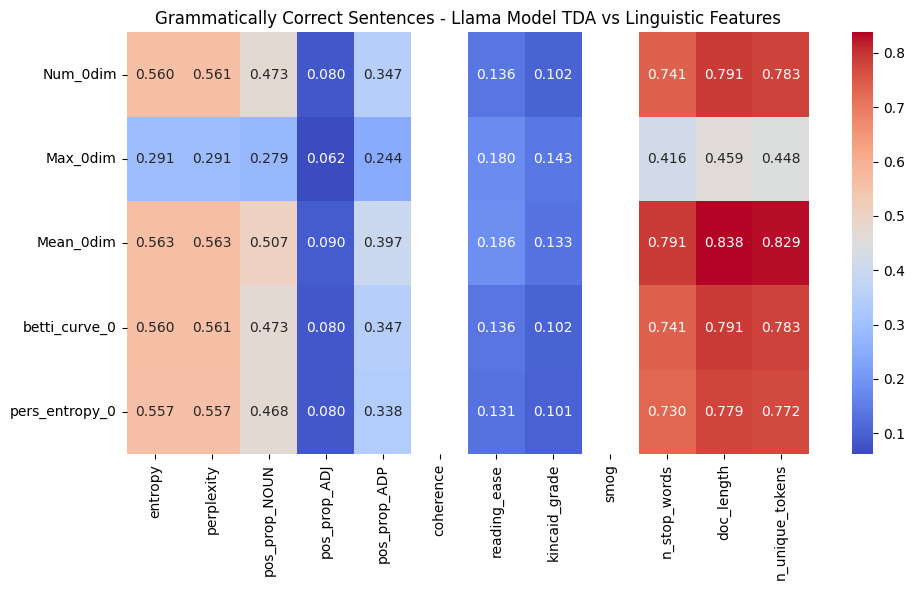

Computing correlations for grammatically incorrect sentences...


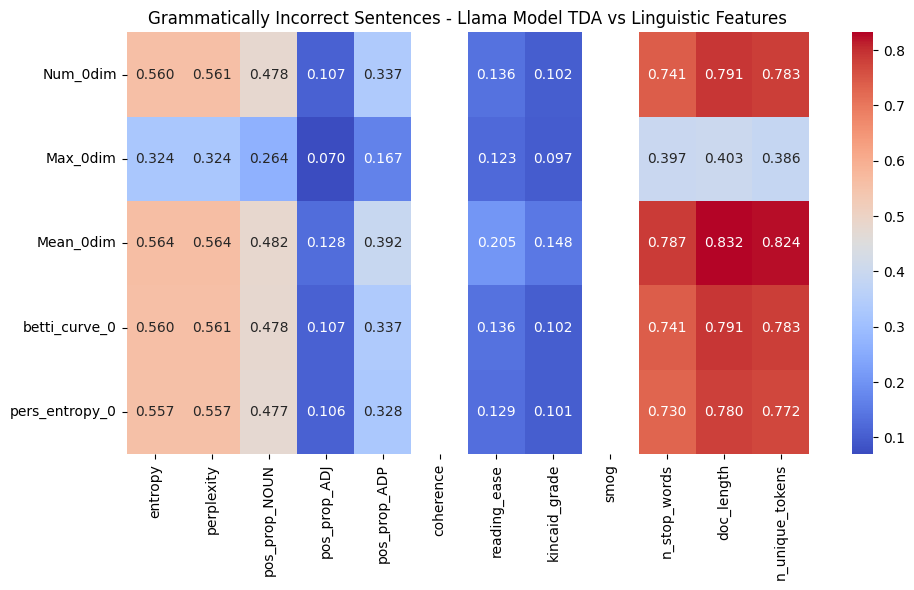

Computing difference between good and bad...


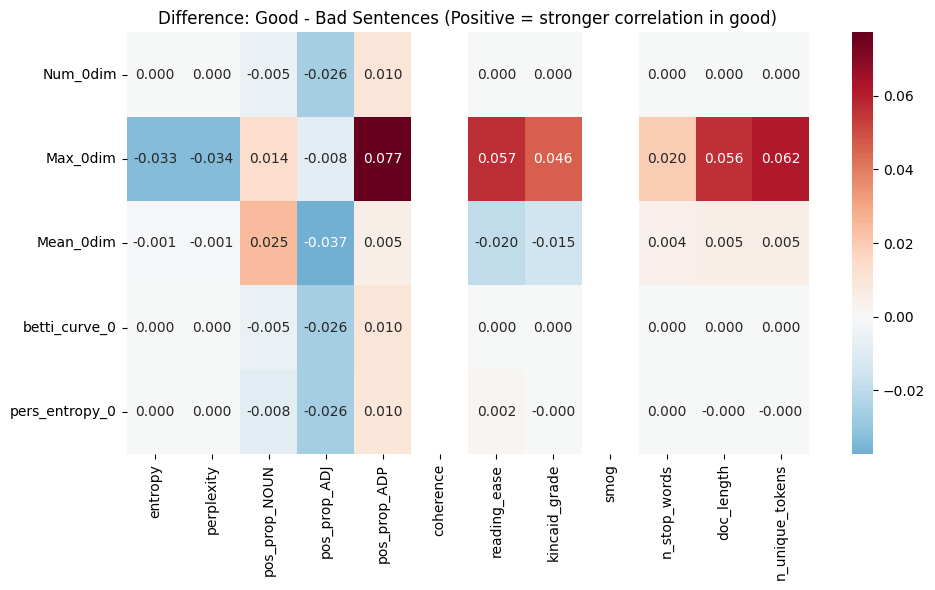


Analysis complete! All heatmaps saved to Google Drive.


In [11]:
!pip install dcor

import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import dcor

# Select focused features
focus_good_feat = good_feat[['entropy', 'perplexity', 'pos_prop_NOUN', 'pos_prop_ADJ', 'pos_prop_ADP',
                              'first_order_coherence', 'flesch_reading_ease', 'flesch_kincaid_grade', 'smog',
                              'n_stop_words', 'doc_length', 'n_unique_tokens']]

focus_bad_feat = bad_feat[['entropy', 'perplexity', 'pos_prop_NOUN', 'pos_prop_ADJ', 'pos_prop_ADP',
                            'first_order_coherence', 'flesch_reading_ease', 'flesch_kincaid_grade', 'smog',
                            'n_stop_words', 'doc_length', 'n_unique_tokens']]

focus_tda_good = good_tda[["Num_0dim", "Max_0dim", "Mean_0dim", "betti_curve_0", "persistence_entropy_0"]]
focus_tda_bad = bad_tda[["Num_0dim", "Max_0dim", "Mean_0dim", "betti_curve_0", "persistence_entropy_0"]]

# Compute correlations for GOOD sentences
print("Computing correlations for grammatically correct sentences...")
tda_features = focus_tda_good.to_numpy()
linguistic_features = focus_good_feat.to_numpy()

corr_matrix_good = np.zeros((tda_features.shape[1], linguistic_features.shape[1]))

for i in range(tda_features.shape[1]):
    for j in range(linguistic_features.shape[1]):
        corr_matrix_good[i, j] = dcor.distance_correlation(tda_features[:, i], linguistic_features[:, j])

# Plot heatmap for GOOD sentences
plt.figure(figsize=(10, 6))
sns.heatmap(corr_matrix_good, annot=True, cmap="coolwarm", fmt='.3f',
            xticklabels=['entropy', 'perplexity', 'pos_prop_NOUN', 'pos_prop_ADJ', 'pos_prop_ADP',
                        'coherence', 'reading_ease', 'kincaid_grade', 'smog',
                        'n_stop_words', 'doc_length', 'n_unique_tokens'],
            yticklabels=["Num_0dim", "Max_0dim", "Mean_0dim", "betti_curve_0", "pers_entropy_0"])
plt.title("Grammatically Correct Sentences - Llama Model TDA vs Linguistic Features")
plt.tight_layout()
plt.show()

# Compute correlations for BAD sentences
print("Computing correlations for grammatically incorrect sentences...")
tda_features = focus_tda_bad.to_numpy()
linguistic_features = focus_bad_feat.to_numpy()

corr_matrix_bad = np.zeros((tda_features.shape[1], linguistic_features.shape[1]))

for i in range(tda_features.shape[1]):
    for j in range(linguistic_features.shape[1]):
        corr_matrix_bad[i, j] = dcor.distance_correlation(tda_features[:, i], linguistic_features[:, j])

# Plot heatmap for BAD sentences
plt.figure(figsize=(10, 6))
sns.heatmap(corr_matrix_bad, annot=True, cmap="coolwarm", fmt='.3f',
            xticklabels=['entropy', 'perplexity', 'pos_prop_NOUN', 'pos_prop_ADJ', 'pos_prop_ADP',
                        'coherence', 'reading_ease', 'kincaid_grade', 'smog',
                        'n_stop_words', 'doc_length', 'n_unique_tokens'],
            yticklabels=["Num_0dim", "Max_0dim", "Mean_0dim", "betti_curve_0", "pers_entropy_0"])
plt.title("Grammatically Incorrect Sentences - Llama Model TDA vs Linguistic Features")
plt.tight_layout()
plt.show()

# Compute difference heatmap (Good - Bad)
print("Computing difference between good and bad...")
corr_matrix_diff = corr_matrix_good - corr_matrix_bad

plt.figure(figsize=(10, 6))
sns.heatmap(corr_matrix_diff, annot=True, cmap="RdBu_r", fmt='.3f', center=0,
            xticklabels=['entropy', 'perplexity', 'pos_prop_NOUN', 'pos_prop_ADJ', 'pos_prop_ADP',
                        'coherence', 'reading_ease', 'kincaid_grade', 'smog',
                        'n_stop_words', 'doc_length', 'n_unique_tokens'],
            yticklabels=["Num_0dim", "Max_0dim", "Mean_0dim", "betti_curve_0", "pers_entropy_0"])
plt.title("Difference: Good - Bad Sentences (Positive = stronger correlation in good)")
plt.tight_layout()
plt.show()

print("\nAnalysis complete! All heatmaps saved to Google Drive.")

In [12]:
from matplotlib.backends.backend_pdf import PdfPages
import matplotlib.pyplot as plt
import seaborn as sns

# Save to your workspace
pdf_path = "/workspace/blimp_correlation_analysis_llama.pdf"

with PdfPages(pdf_path) as pdf:
    # Heatmap 1: Good sentences
    fig1 = plt.figure(figsize=(12, 8))
    sns.heatmap(corr_matrix_good, annot=True, cmap="coolwarm", fmt='.3f',
                xticklabels=['entropy', 'perplexity', 'pos_prop_NOUN', 'pos_prop_ADJ', 'pos_prop_ADP',
                            'coherence', 'reading_ease', 'kincaid_grade', 'smog',
                            'n_stop_words', 'doc_length', 'n_unique_tokens'],
                yticklabels=["Num_0dim", "Max_0dim", "Mean_0dim", "betti_curve_0", "pers_entropy_0"])
    plt.title("Grammatically Correct Sentences - Llama Model TDA vs Linguistic Features", fontsize=14, pad=20)
    plt.tight_layout()
    pdf.savefig(fig1, bbox_inches='tight')
    plt.close()
    
    # Heatmap 2: Bad sentences
    fig2 = plt.figure(figsize=(12, 8))
    sns.heatmap(corr_matrix_bad, annot=True, cmap="coolwarm", fmt='.3f',
                xticklabels=['entropy', 'perplexity', 'pos_prop_NOUN', 'pos_prop_ADJ', 'pos_prop_ADP',
                            'coherence', 'reading_ease', 'kincaid_grade', 'smog',
                            'n_stop_words', 'doc_length', 'n_unique_tokens'],
                yticklabels=["Num_0dim", "Max_0dim", "Mean_0dim", "betti_curve_0", "pers_entropy_0"])
    plt.title("Grammatically Incorrect Sentences - Llama Model TDA vs Linguistic Features", fontsize=14, pad=20)
    plt.tight_layout()
    pdf.savefig(fig2, bbox_inches='tight')
    plt.close()
    
    # Heatmap 3: Difference
    fig3 = plt.figure(figsize=(12, 8))
    sns.heatmap(corr_matrix_diff, annot=True, cmap="RdBu_r", fmt='.3f', center=0,
                xticklabels=['entropy', 'perplexity', 'pos_prop_NOUN', 'pos_prop_ADJ', 'pos_prop_ADP',
                            'coherence', 'reading_ease', 'kincaid_grade', 'smog',
                            'n_stop_words', 'doc_length', 'n_unique_tokens'],
                yticklabels=["Num_0dim", "Max_0dim", "Mean_0dim", "betti_curve_0", "pers_entropy_0"])
    plt.title("Difference: Good - Bad Sentences (Positive = stronger in good)", fontsize=14, pad=20)
    plt.tight_layout()
    pdf.savefig(fig3, bbox_inches='tight')
    plt.close()

print(f"PDF saved to: {pdf_path}")

PDF saved to: /workspace/blimp_correlation_analysis_llama.pdf
